# Paper Abstracts Clustering

Author: Rafael Ballestiero

In [3]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

plt.rcParams['figure.figsize']=[50,30]
plt.rcParams['font.size']=22
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.labelsize'] = 24

In [4]:
from gensim.models import KeyedVectors

from gensim.utils import has_pattern, simple_preprocess
from gensim.parsing.preprocessing import preprocess_string, remove_stopwords

from gensim.scripts.glove2word2vec import glove2word2vec

from gensim.summarization import keywords, summarize_corpus
from gensim.summarization.textcleaner import clean_text_by_sentences
from gensim.test.utils import datapath, get_tmpfile

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import OneHotEncoder

from scipy import spatial
import scipy.cluster.hierarchy as shc

from pyemd import emd

assert has_pattern()

## Extract Abstracts

The first step in this is to parse the DOI links provided in the spreadsheet to retrieve the Abstracts of each of these players. This is done with the help of some HTML parsing libraries and a quick inspection of the page structure to find the HTML elements in which the abstracts appear.

In [3]:
import requests
import urllib.request
from bs4 import BeautifulSoup

df = pd.read_csv(FILENAME, header=None, names=['URL', 'Descriptive/Prescriptive', 'Type', 'Area'])
df[['Descriptive/Prescriptive', 'Type', 'Area']] = df[['Descriptive/Prescriptive', 'Type', 'Area']].astype('category')

In [7]:
def retrieve_abstract(url):
    response = requests.get(url)
    
    soup = BeautifulSoup(response.text, "html.parser")
    
    abstract_section = soup.find("div", {"class": "abstractSection"})
    return abstract_section.p.get_text()

In [8]:
if 'abstracts.csv' in os.listdir('data'):
    print('Reading abstracts from CSV')
    df = pd.read_csv('data/abstracts.csv', index_col=0)
else:
    df["Abstract"] = None
    
    for i, url in enumerate(df["URL"]):
        print(f'({i}/{len(df["URL"])})Retrieving abstract for {url}...')
        df["Abstract"][i] = retrieve_abstract(url)

    # Ensure integrity of abstracts (none of them are null)
    assert (df['Abstract'].isna() == False).all()

    df.to_csv('data/abstracts.csv')

Reading abstracts from CSV


## Clustering Methods

In [9]:
def cluster(X, n_clusters):
    return shc.fcluster(shc.linkage(X, method='ward'), n_clusters, criterion='maxclust')

### 1. Labeled Clustering

Use 3 human-generated categories to cluster papers (ignoring abstracts).

In [10]:
def generate_label_df(df):
    ohe = OneHotEncoder()
    sparse_data = ohe.fit_transform(df[['Descriptive/Prescriptive', 'Type', 'Area']])
    
    return pd.SparseDataFrame(sparse_data, columns=ohe.get_feature_names()).set_index(df["URL"], drop=True).fillna(0)

label_df = generate_label_df(df)

#### Dendrogram

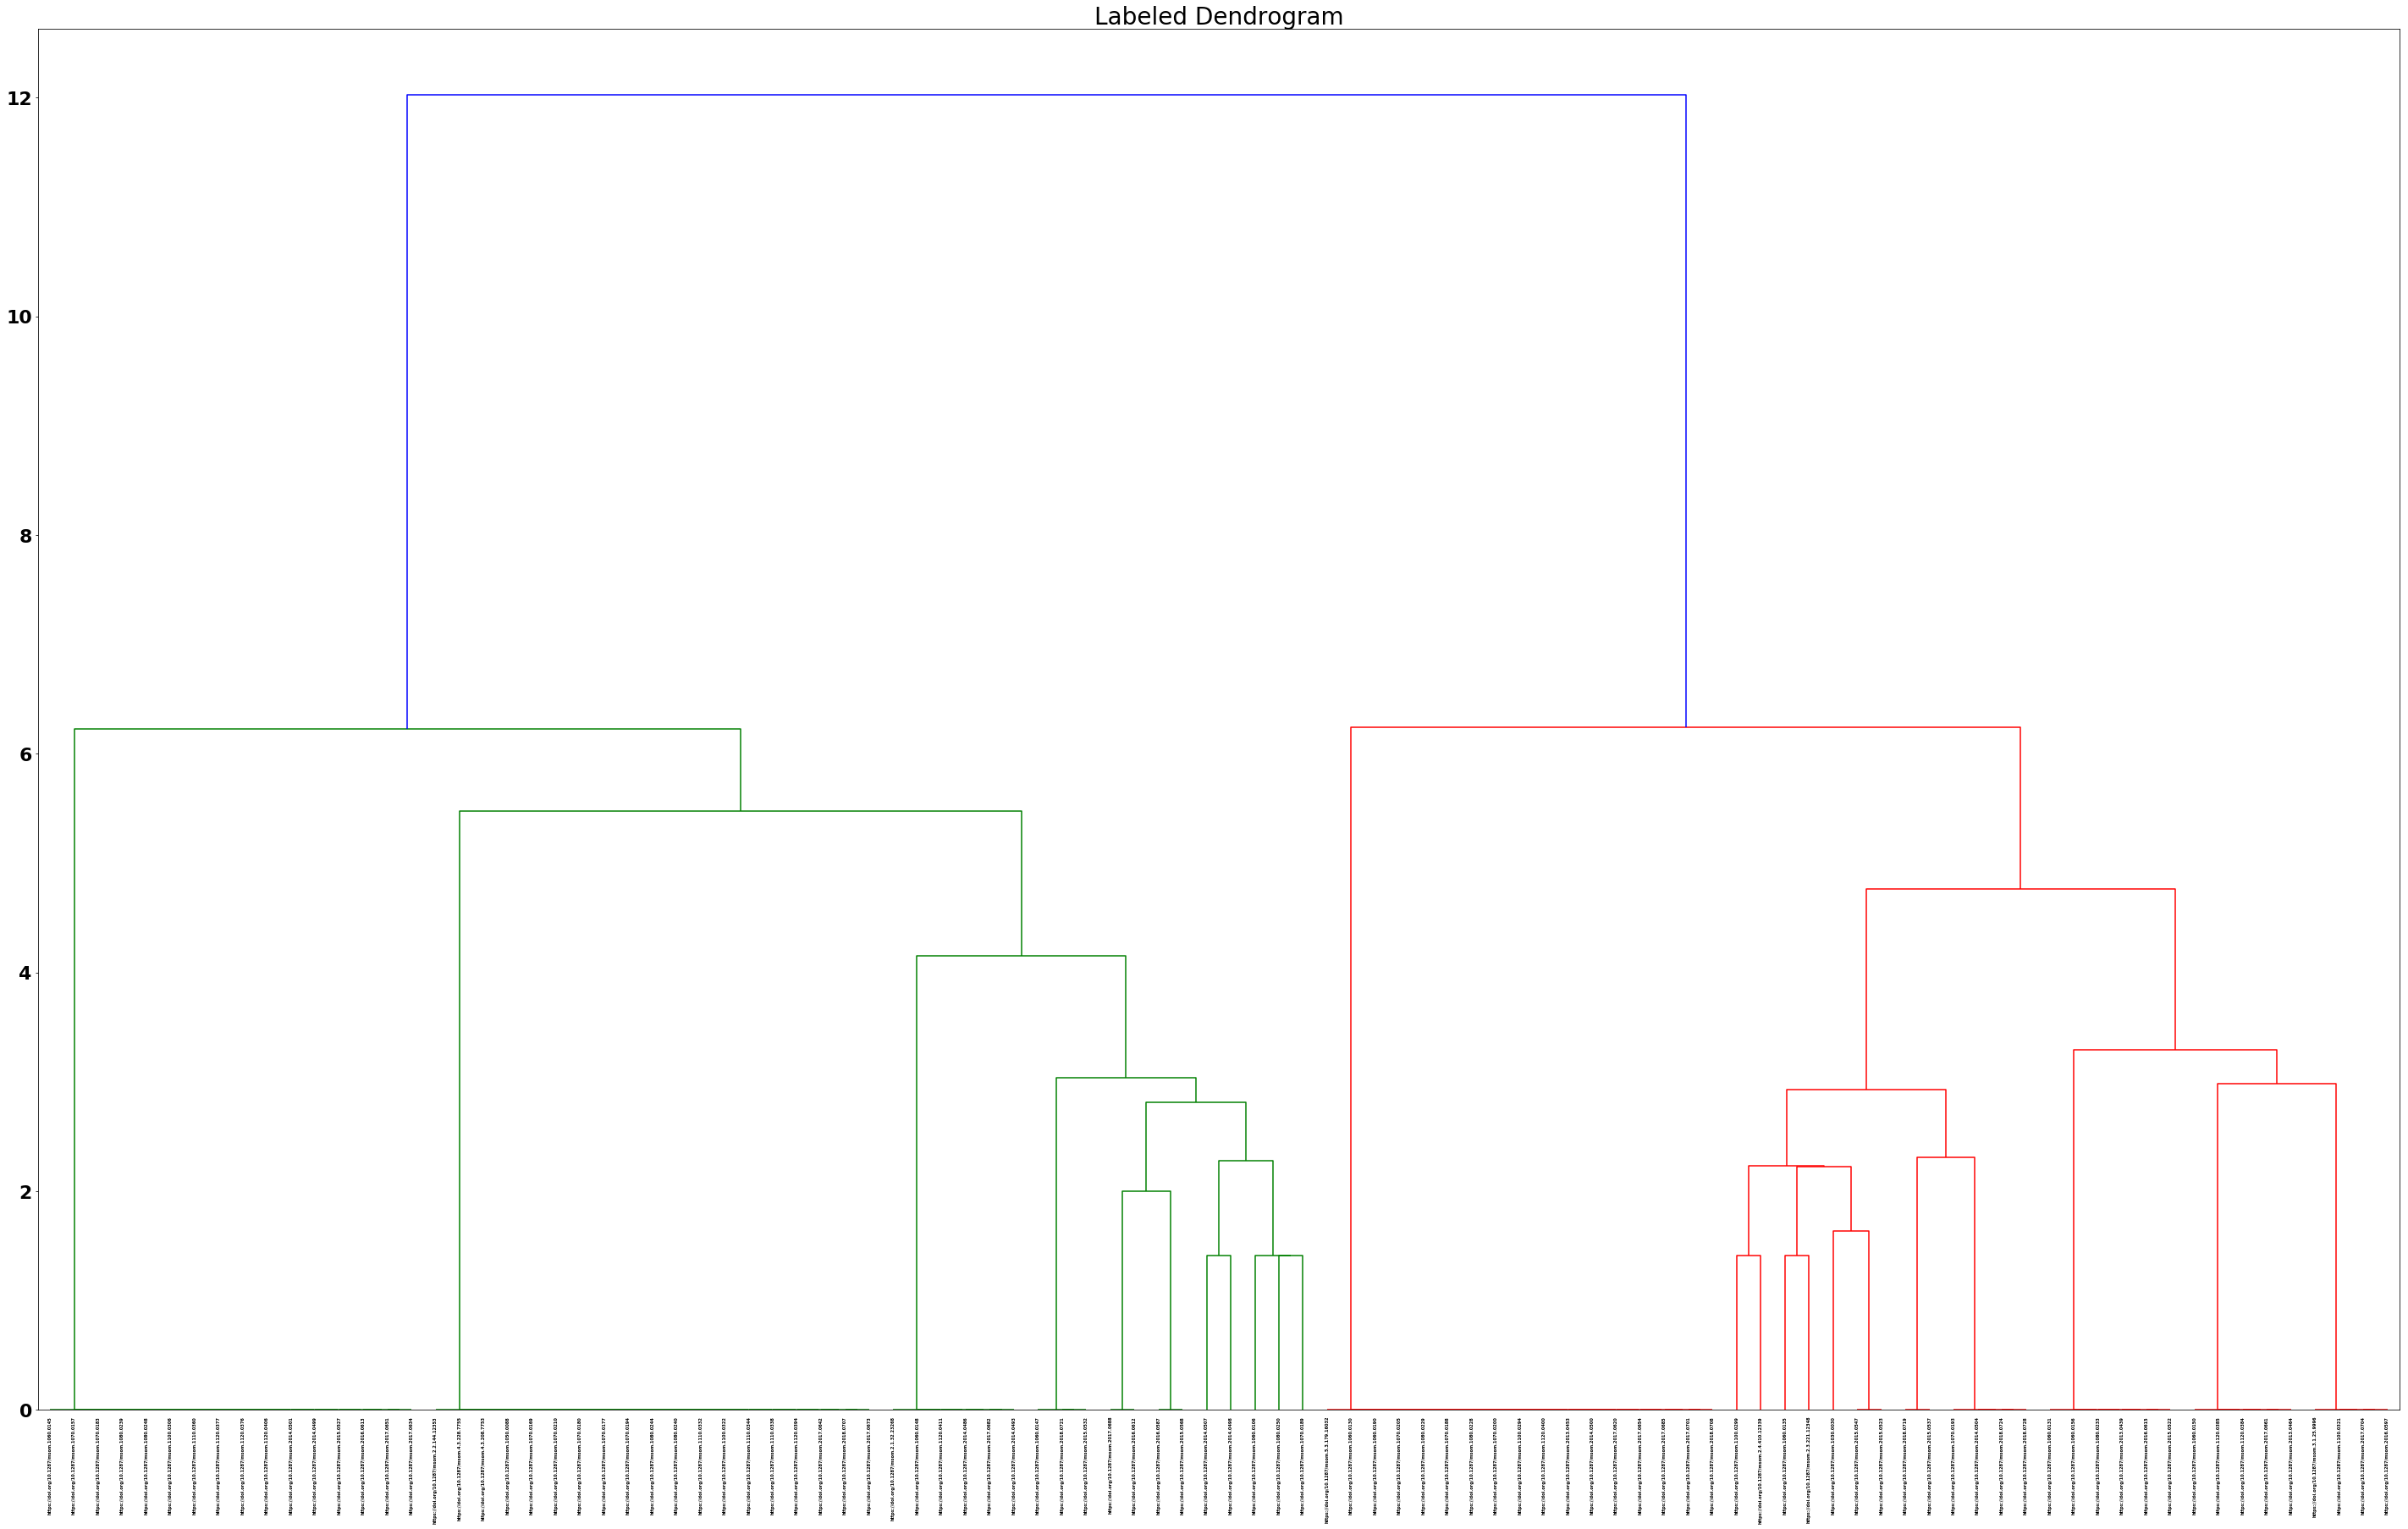

In [170]:
plt.title("Labeled Dendrogram")
dend = shc.dendrogram(shc.linkage(labeled_df, method='ward'), labels=label_df.index)
plt.savefig('plots/dendrograms/labeled_dendrogram.pdf', format='pdf')

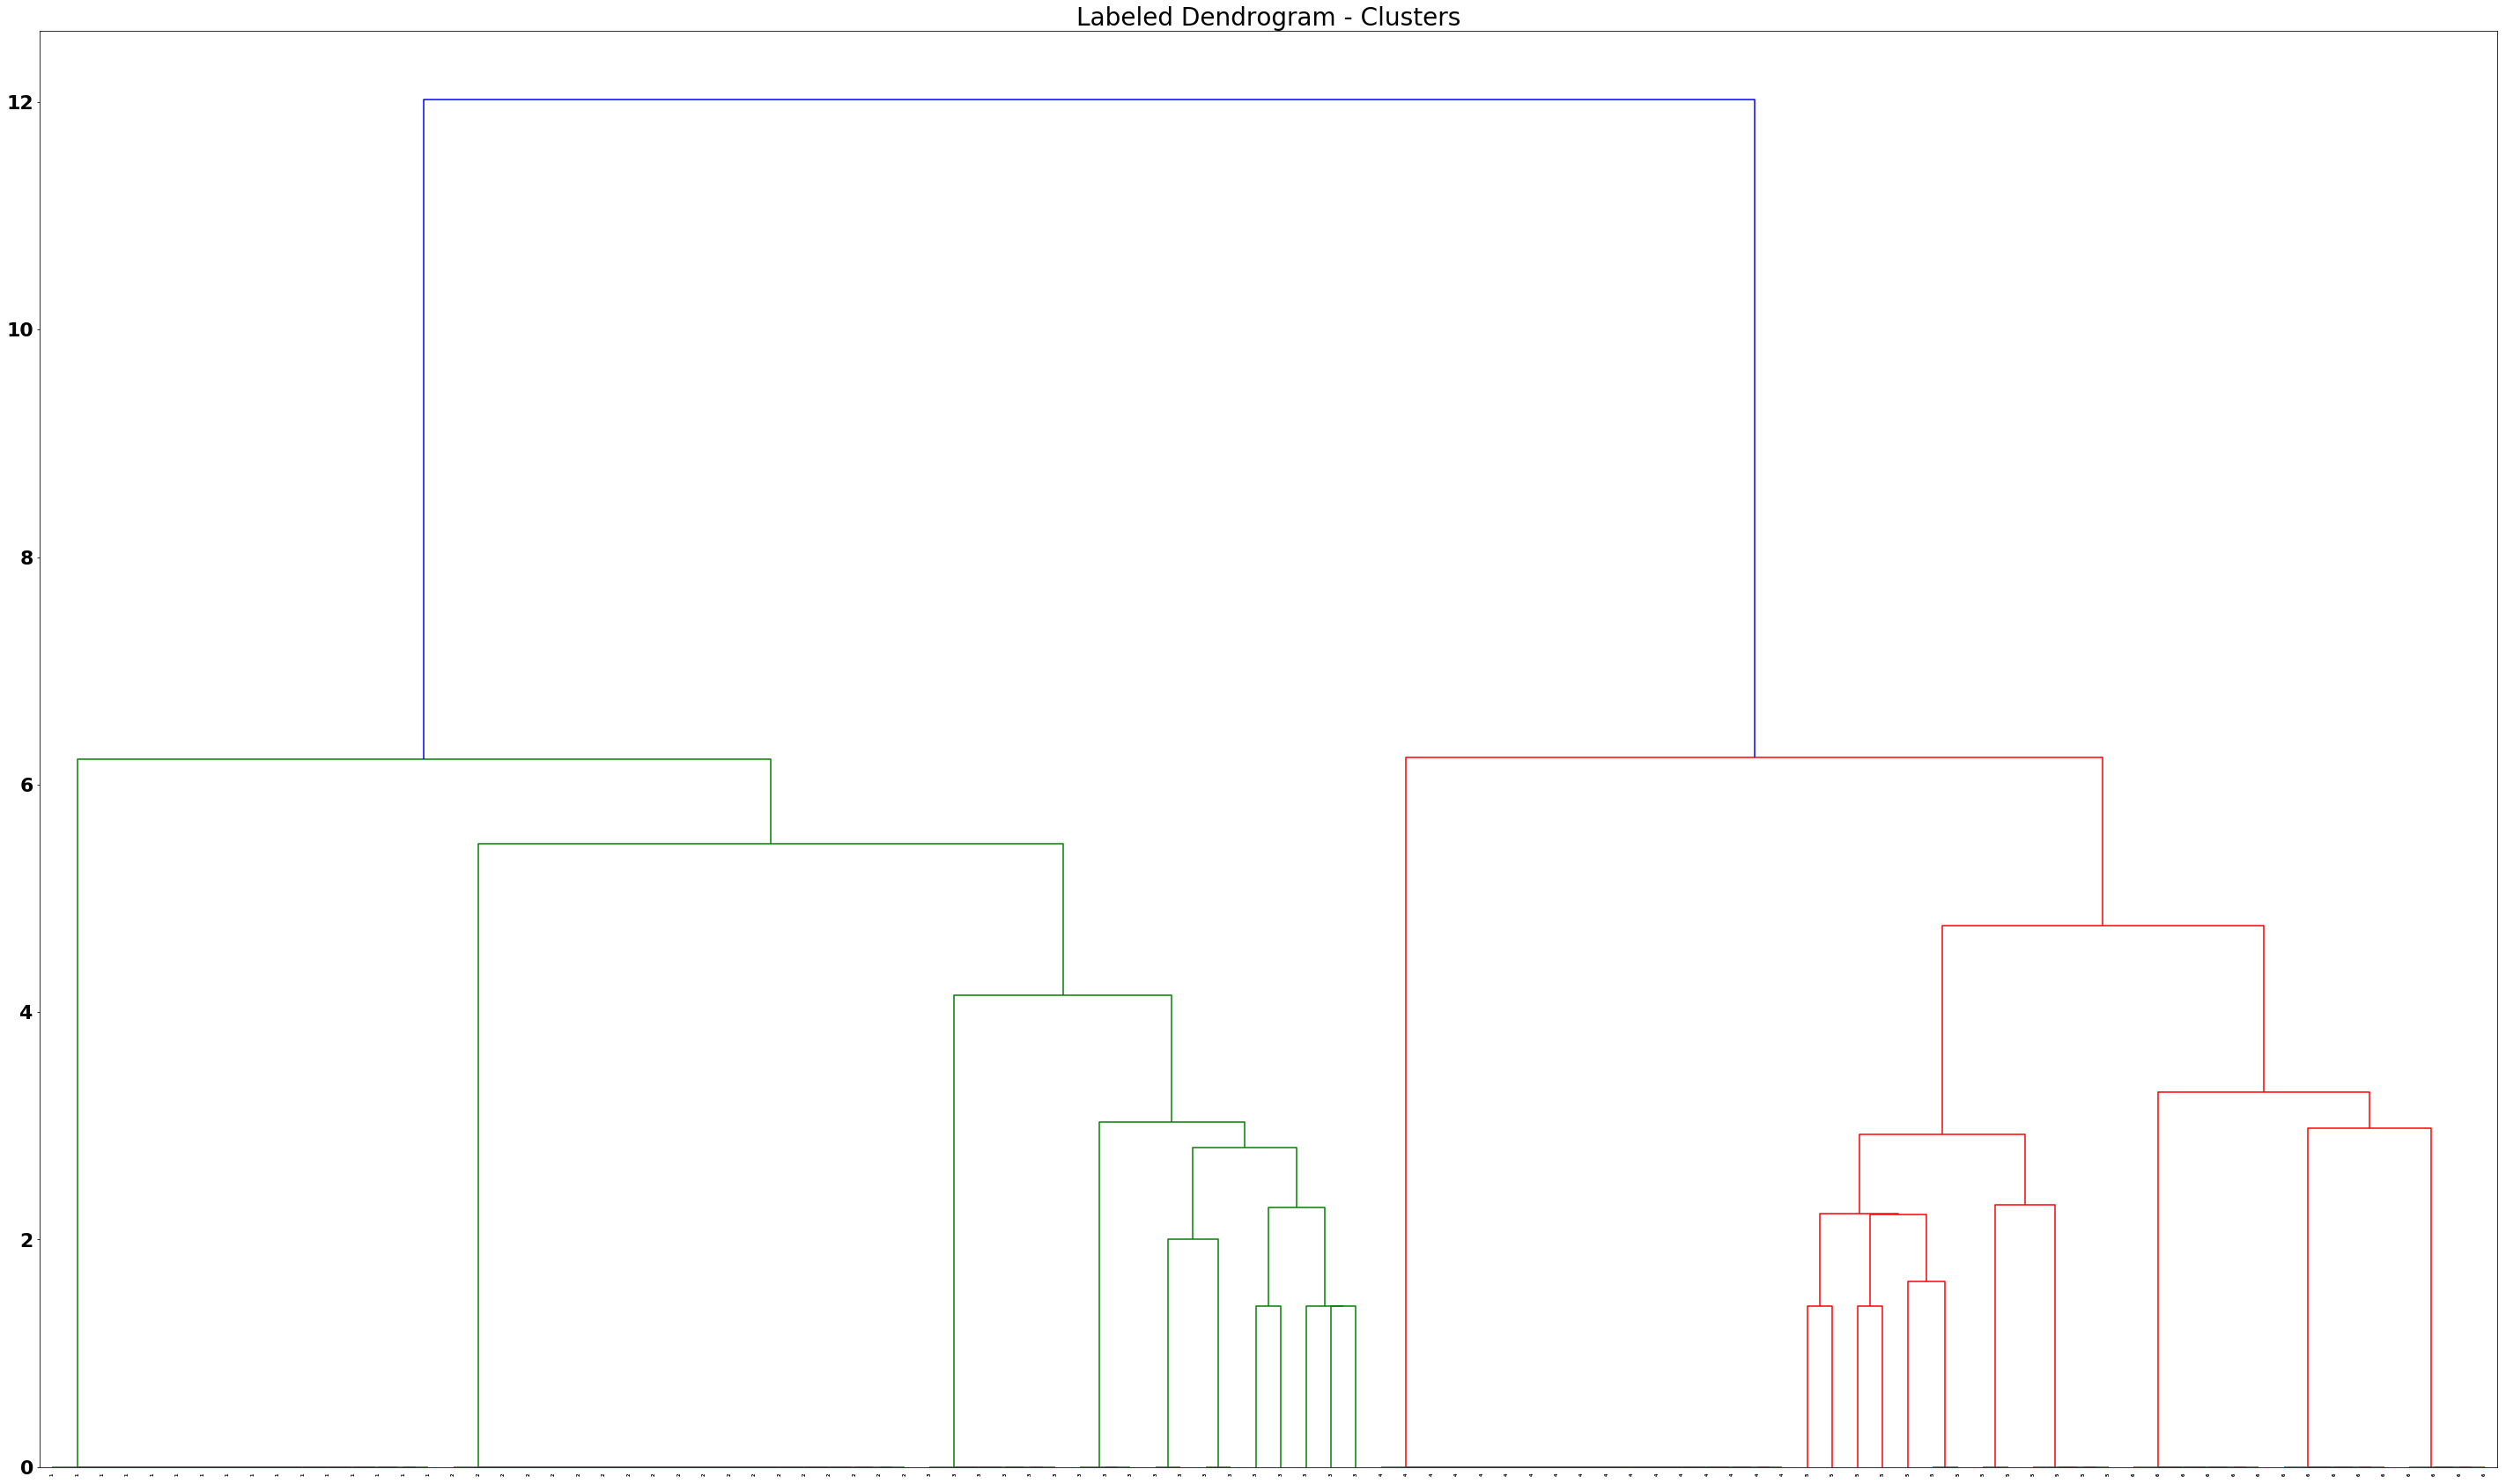

In [172]:
plt.title("Labeled Dendrogram - Clusters")
dend = shc.dendrogram(shc.linkage(labeled_df, method='ward'), labels=cluster(label_df, 6))
plt.savefig('plots/dendrograms/labeled_dendrogram_cluster_labels.pdf', format='pdf')

### 2. Keyword Clustering

#### Extract Keywords from Abstracts

In [14]:
abstract_keywords = df['Abstract'].apply(lambda x: keywords(x, lemmatize=True, words=10, pos_filter=('NN', 'VB'), scores=True))

#### Generate Embeddings Dict from GloVe Files

In [16]:
def generate_embeddings():
    result = {}
    # code below was found in a medium article
    with open("data/glove.6B/glove.6B.100d.txt", 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            result[word] = vector
            
    return result
        
embeddings_dict = generate_embeddings()

In [17]:
def process_keywords(keywords):
    result = []
    
    for (keyword, score) in keywords:
        embedding = embeddings_dict.get(keyword)
        
        if embedding is not None:
            result.append((embedding, score))
    
    return result
    
abstract_embeddings = abstract_keywords.apply(process_keywords)

#### Calculate WMD

In [18]:
def word_movers_distance(left_index, right_index):
    left = abstract_embeddings[left_index]
    right = abstract_embeddings[right_index]
    
    minimum_size = min(len(left), len(right))
    
    left_weights = np.zeros(minimum_size)
    right_weights = np.zeros(minimum_size)
    distance_matrix = np.zeros((minimum_size, minimum_size))
    
    for i in range(minimum_size):
        left_weights[i] = left[i][1]
        for j in range(minimum_size):
            right_weights[j] = right[j][1]
            distance_matrix[i][j] = spatial.distance.euclidean(left[i][0], right[j][0])
    
    return emd(left_weights, right_weights, distance_matrix)

In [19]:
def generate_keyword_distance_matrix():
    s = abstract_embeddings.size
    return np.array([[word_movers_distance(i, j) for i in range(s)] for j in range(s)])

keyword_distance_matrix = generate_keyword_distance_matrix()

In [21]:
keyword_df = spatial.distance.squareform(keyword_distance_matrix)

#### Dendrogram

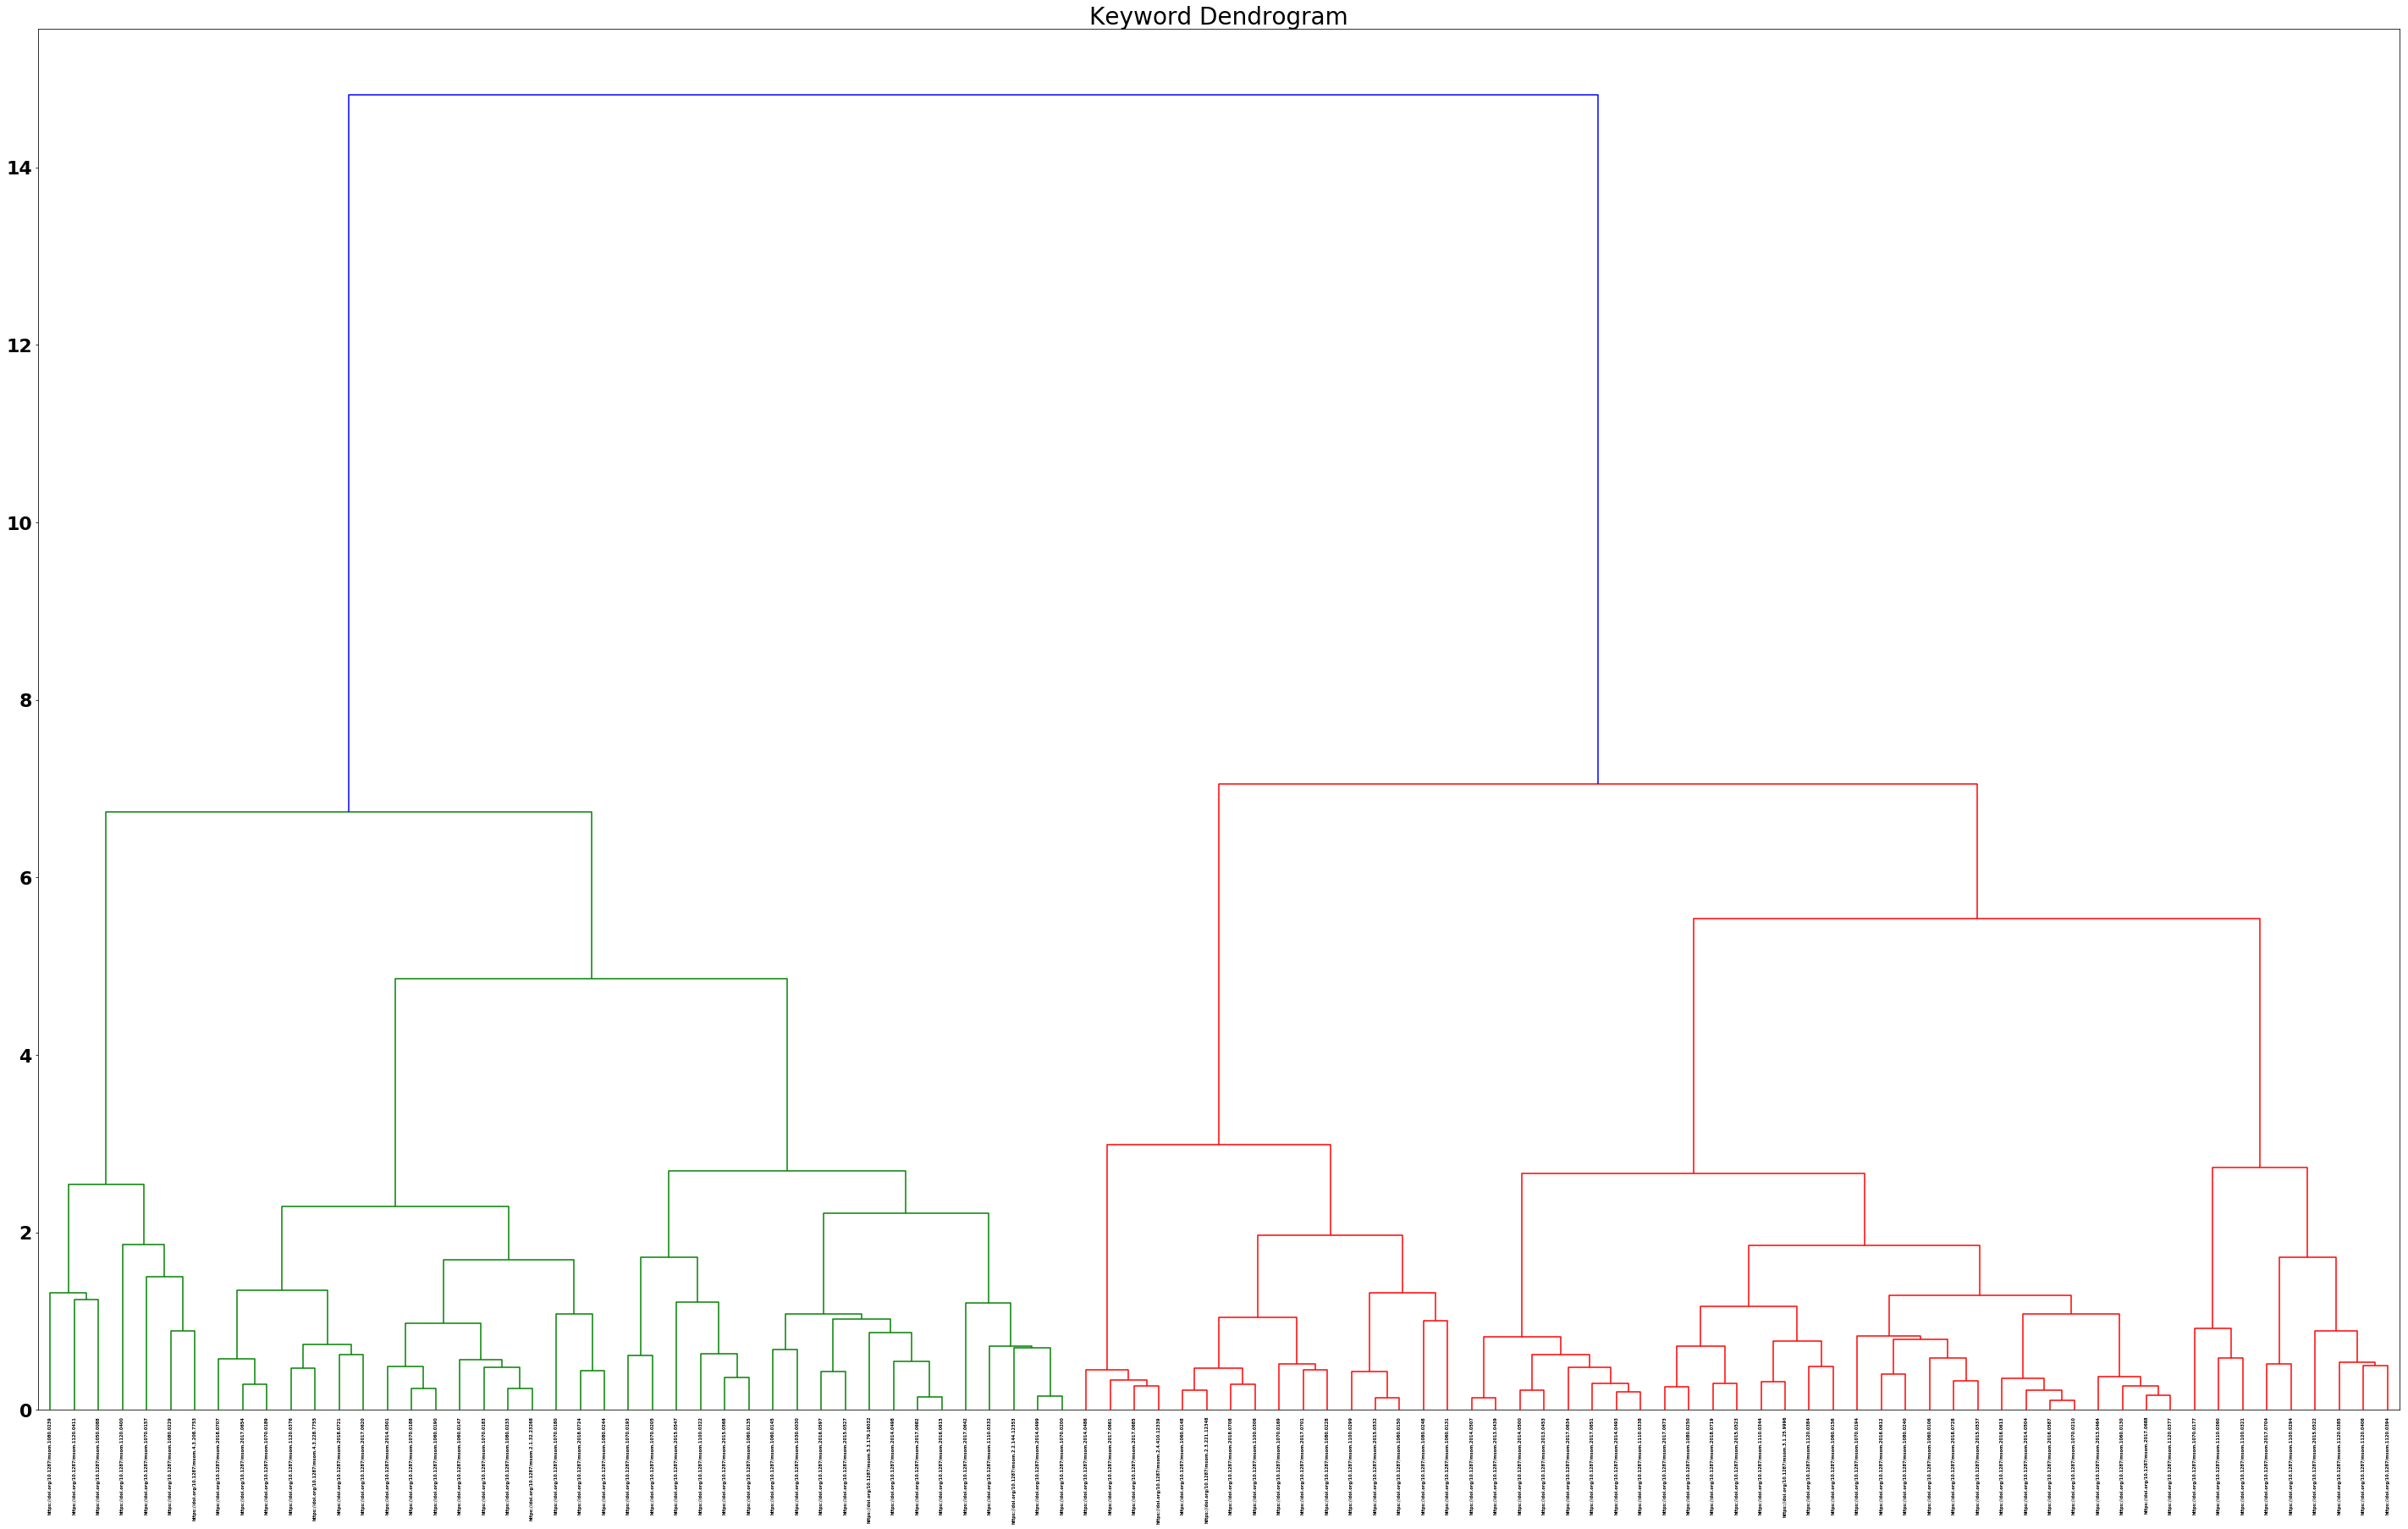

In [81]:
plt.title("Keyword Dendrogram")
dend = shc.dendrogram(shc.linkage(keyword_df, method='ward'), labels=df["URL"].values)
plt.savefig('plots/dendrograms/keyword_dendrogram.pdf', format='pdf')

### 3. Abstract Clustering

In [23]:
processed_abstracts = df['Abstract'].apply(lambda x: x.lower()).apply(remove_stopwords).apply(simple_preprocess)

#### Convert GloVe to Word2Vec

In [27]:
def convert_glove_2_w2v():
    glove_file = datapath(PATH + "/data/glove.6B/glove.6B.50d.txt")
    tmp_file = get_tmpfile("test_word2vec.txt")

    glove2word2vec(glove_file, tmp_file)

    return KeyedVectors.load_word2vec_format(tmp_file)
    
# model = convert_glove_2_w2v()

In [24]:
def abstract_distance_matrix():
    s = processed_abstracts.size
    result = np.ndarray((s,s))
    
    for i, abstract in enumerate(processed_abstracts):
        print(f"({i}/{s}) Running abstract: {abstract}")
        
        result[i] = processed_abstracts.apply(lambda x: model.wmdistance(abstract, x))
        
        print(f"({i}/{s}) Finished running abstract.\n{result[i]}")
            
    return result
    return np.array([[model.wmdistance(processed_abstracts[i], processed_abstracts[j]) for i in range(s)] for j in range(s)])

# abstract_distance_matrix = abstract_distance_matrix()

In [22]:
# pd.DataFrame(whole_abstract_distance_matrix).to_csv('data/whole_abstract_distance_matrix.csv')
abstract_distance_matrix = pd.read_csv('data/whole_abstract_distance_matrix.csv', index_col=0).values
abstract_df = spatial.distance.squareform(np.round(abstract_distance_matrix, 11))

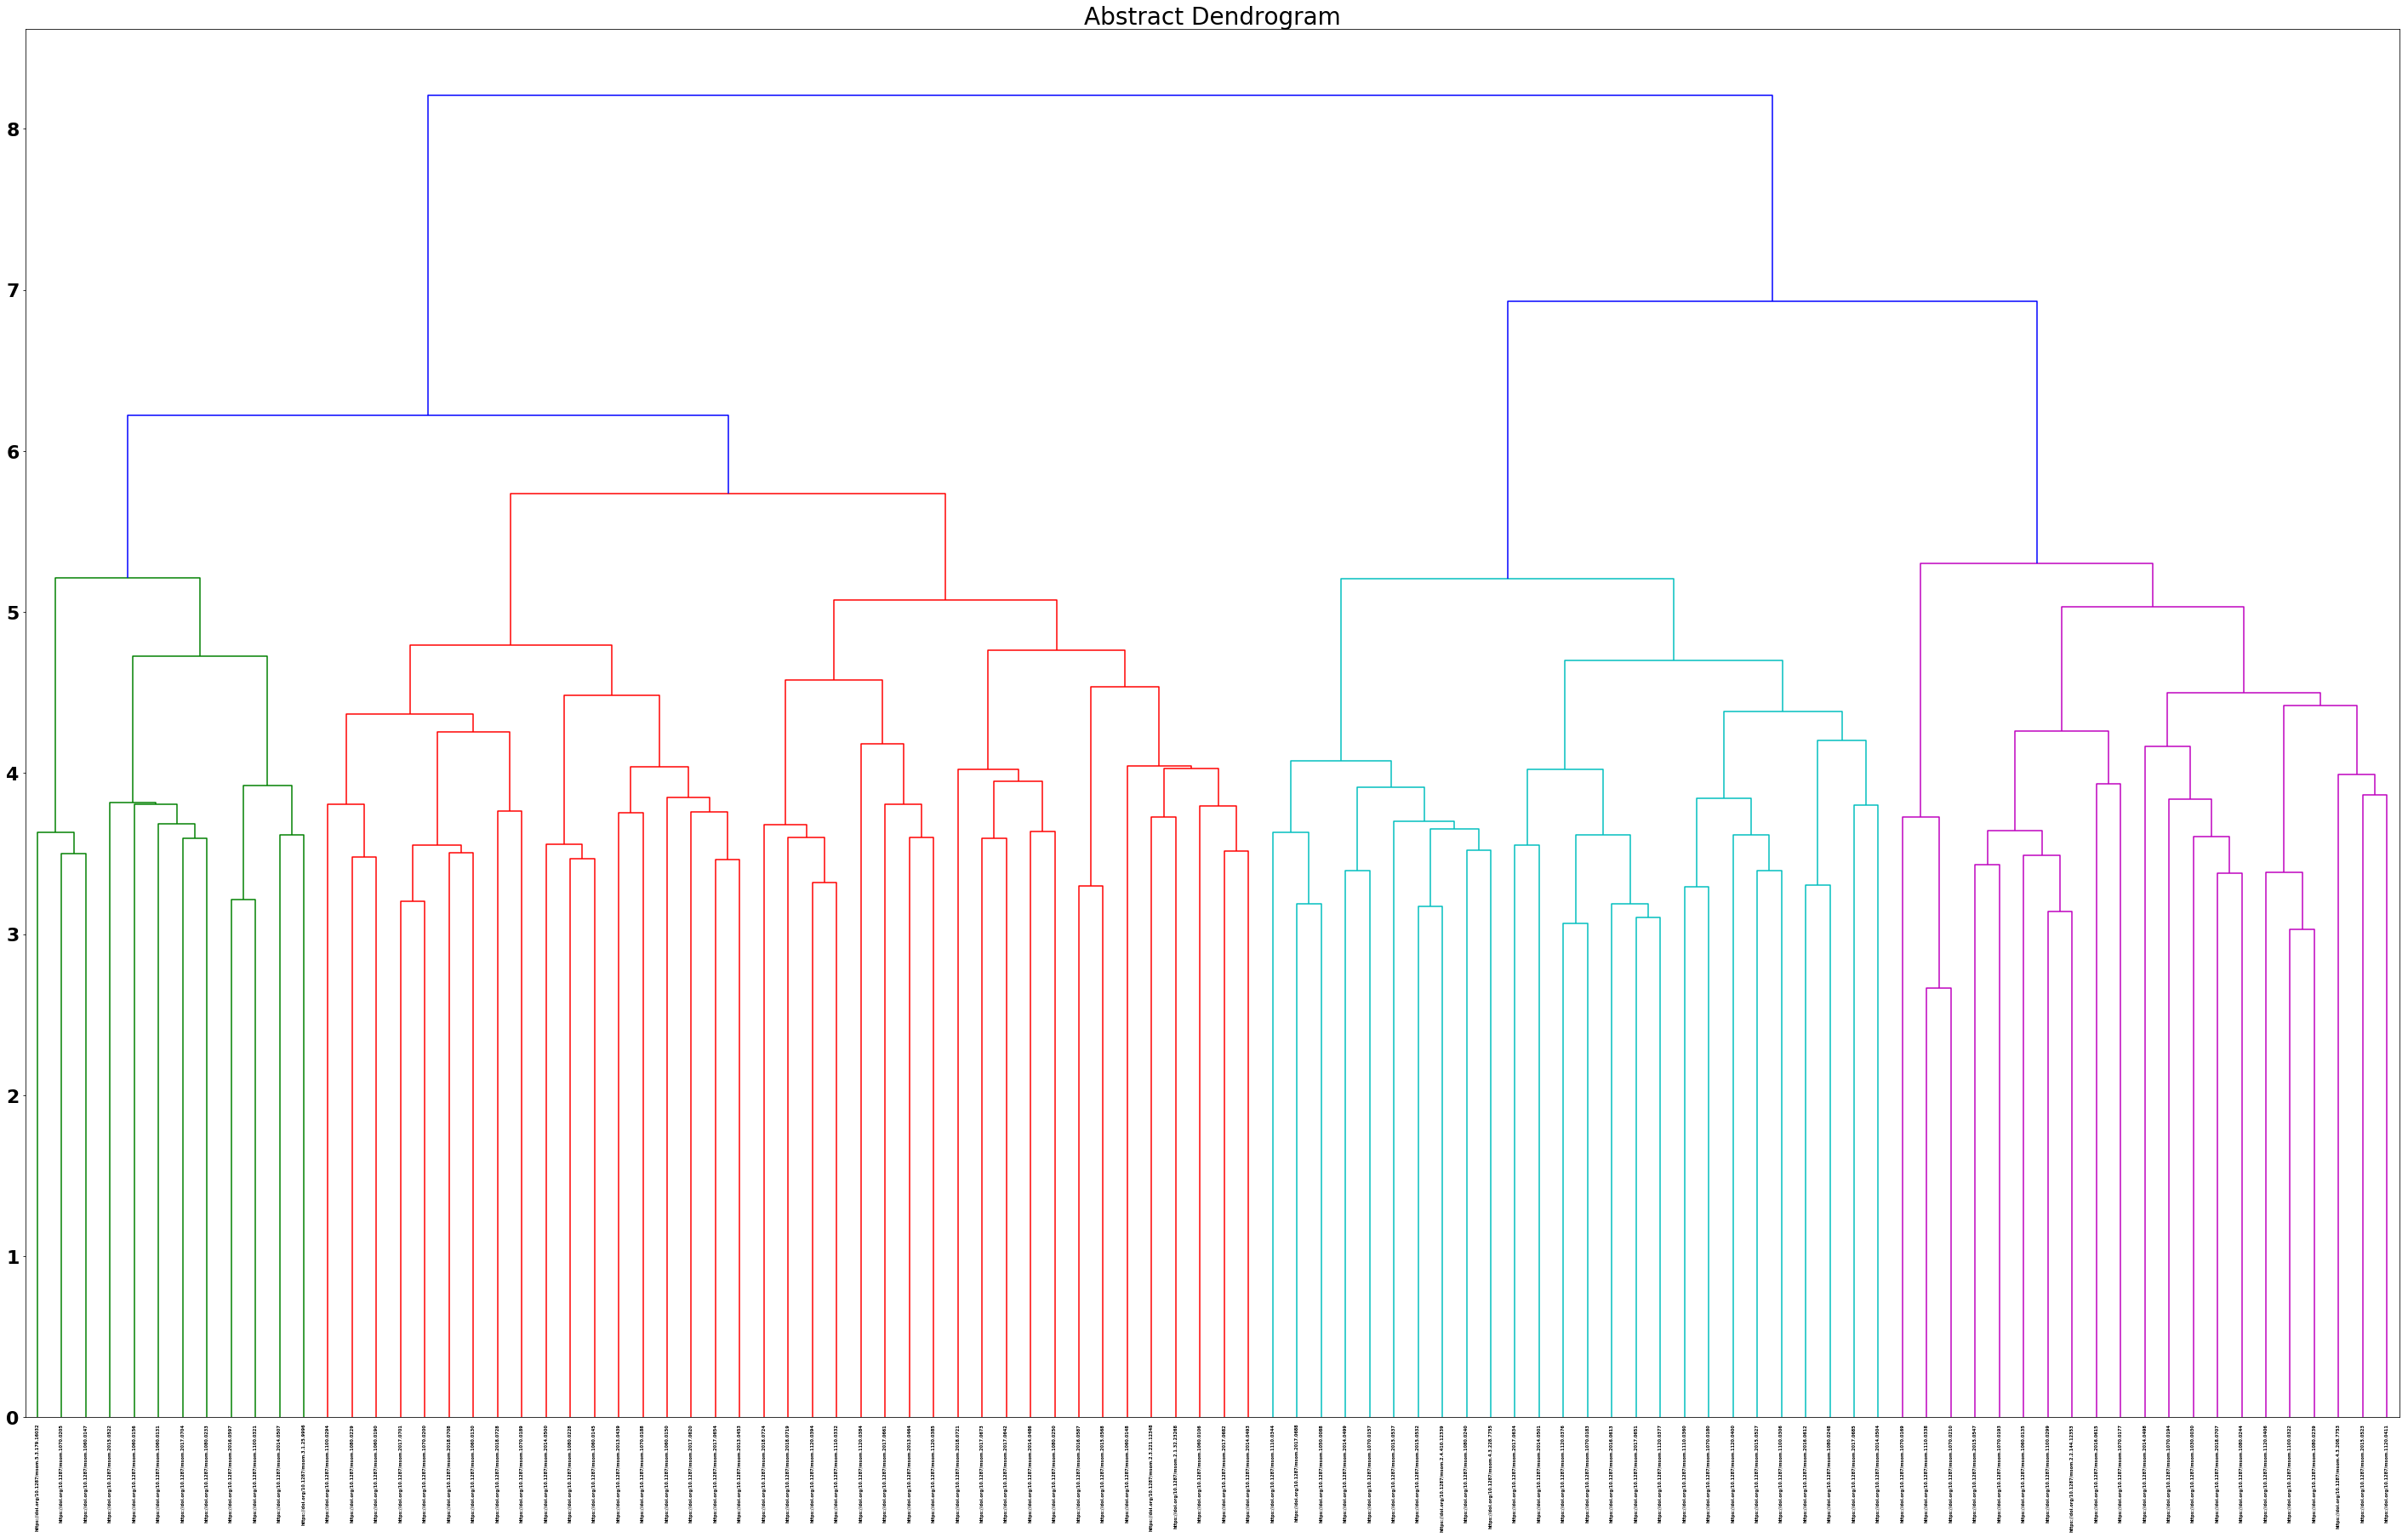

In [82]:
plt.title("Abstract Dendrogram")
dend = shc.dendrogram(shc.linkage(abstract_df, method='ward'), labels=df["URL"].values)
plt.savefig('plots/dendrograms/abstract_dendrogram.pdf', format='pdf')

## Evaluating Clustering Methods

### Cumulative Frequency Evaluation

#### Labeled

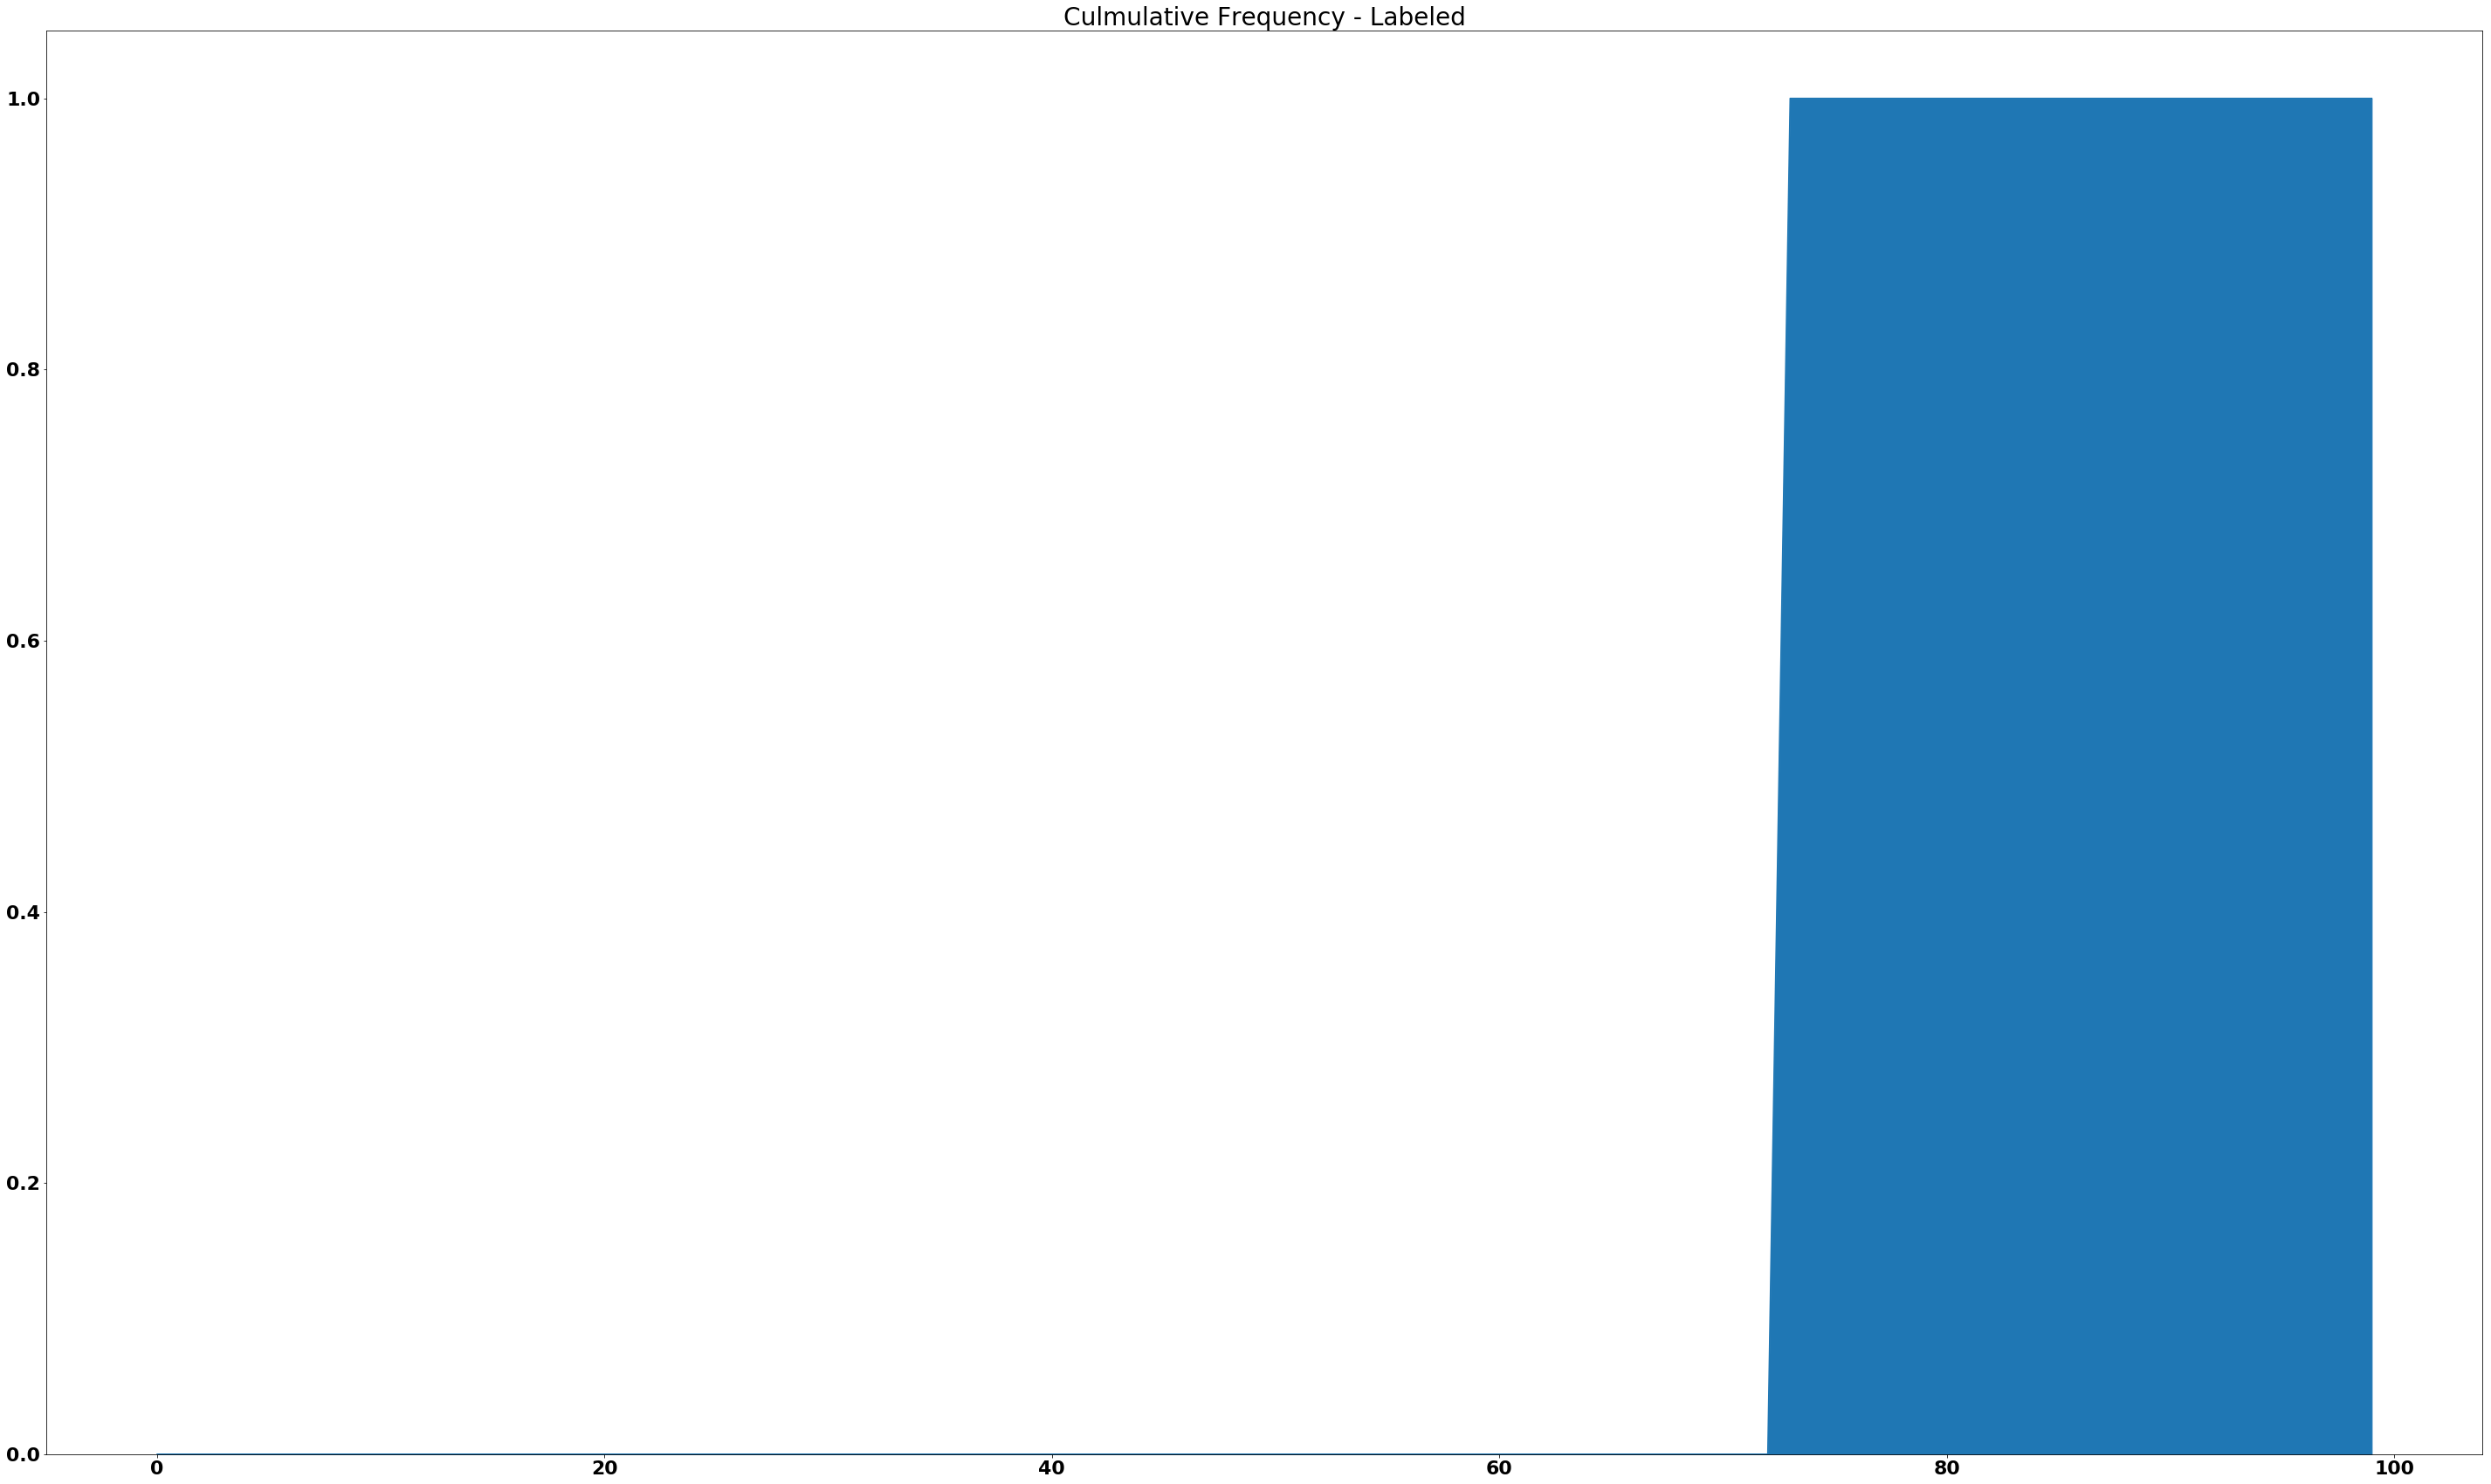

In [190]:
plt.title("Culmulative Frequency - Labeled")
pd.Series(np.percentile(label_df, q=[i for i in range(100)])).plot.area()
plt.savefig("plots/cumulative/labeled")

#### Abstract

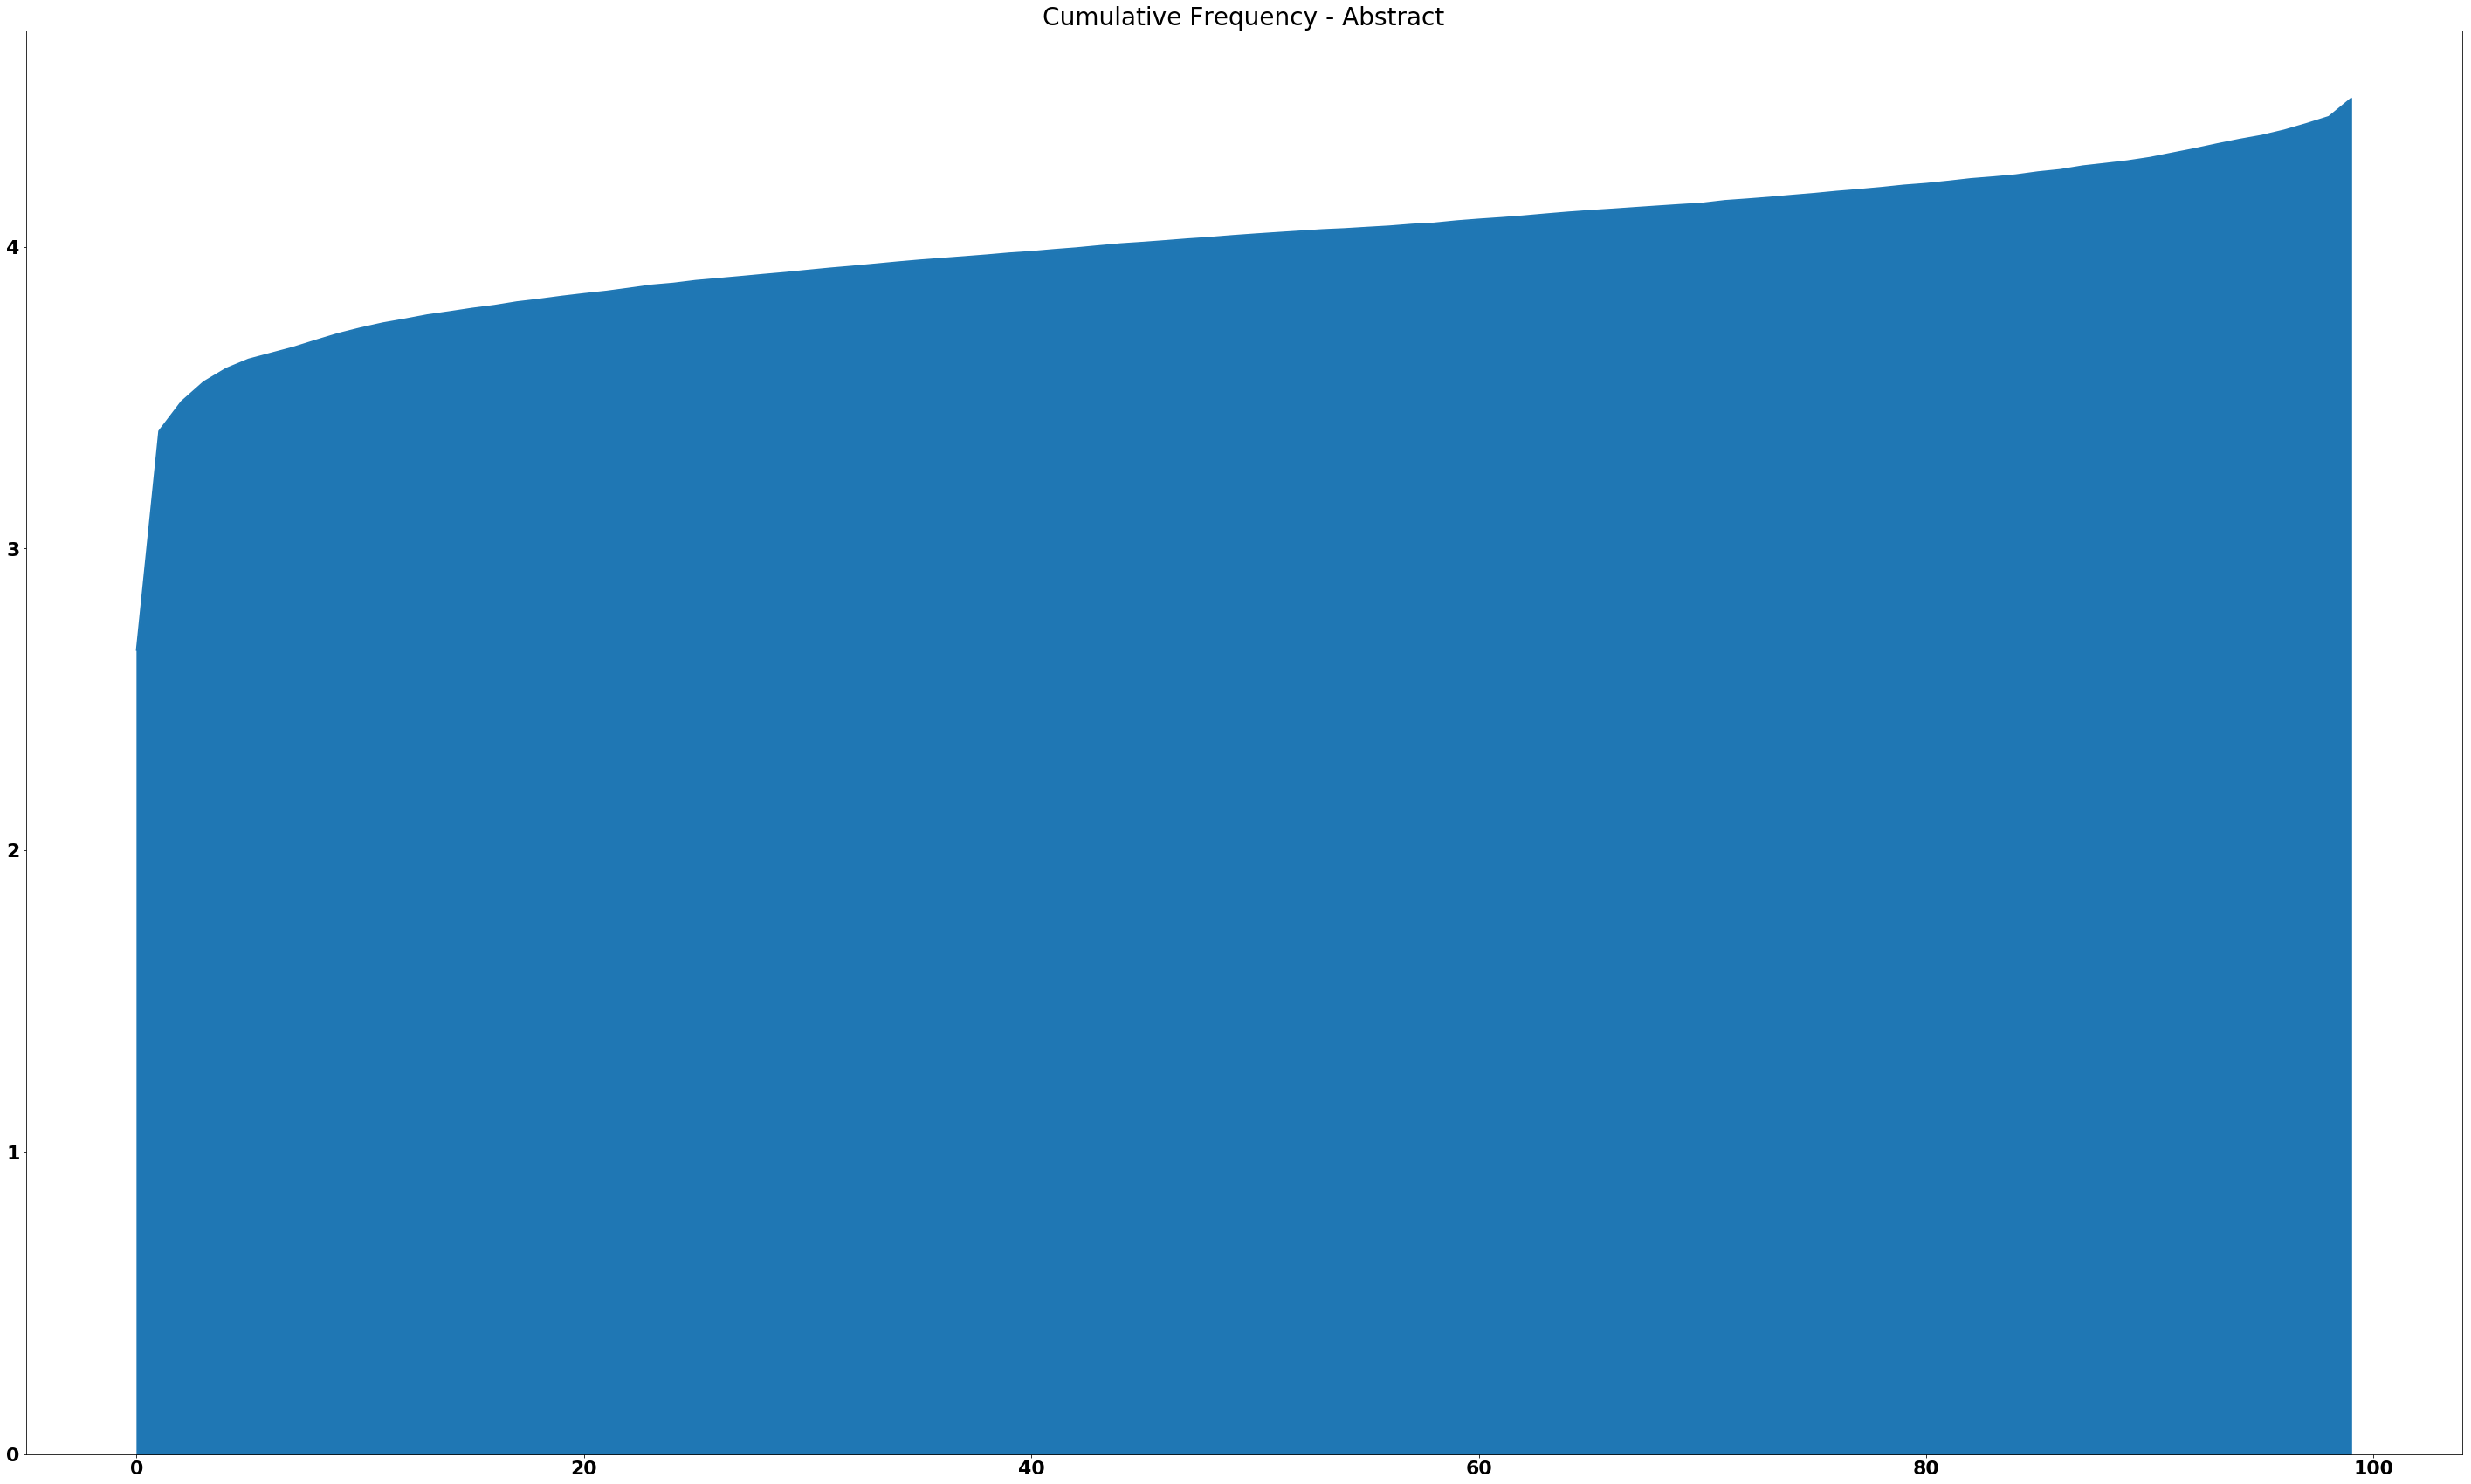

In [187]:
plt.title("Cumulative Frequency - Abstract")
pd.Series(np.percentile(abstract_df, q=[i for i in range(100)])).plot.area()
plt.savefig("plots/cumulative/abstract")

#### Keyword

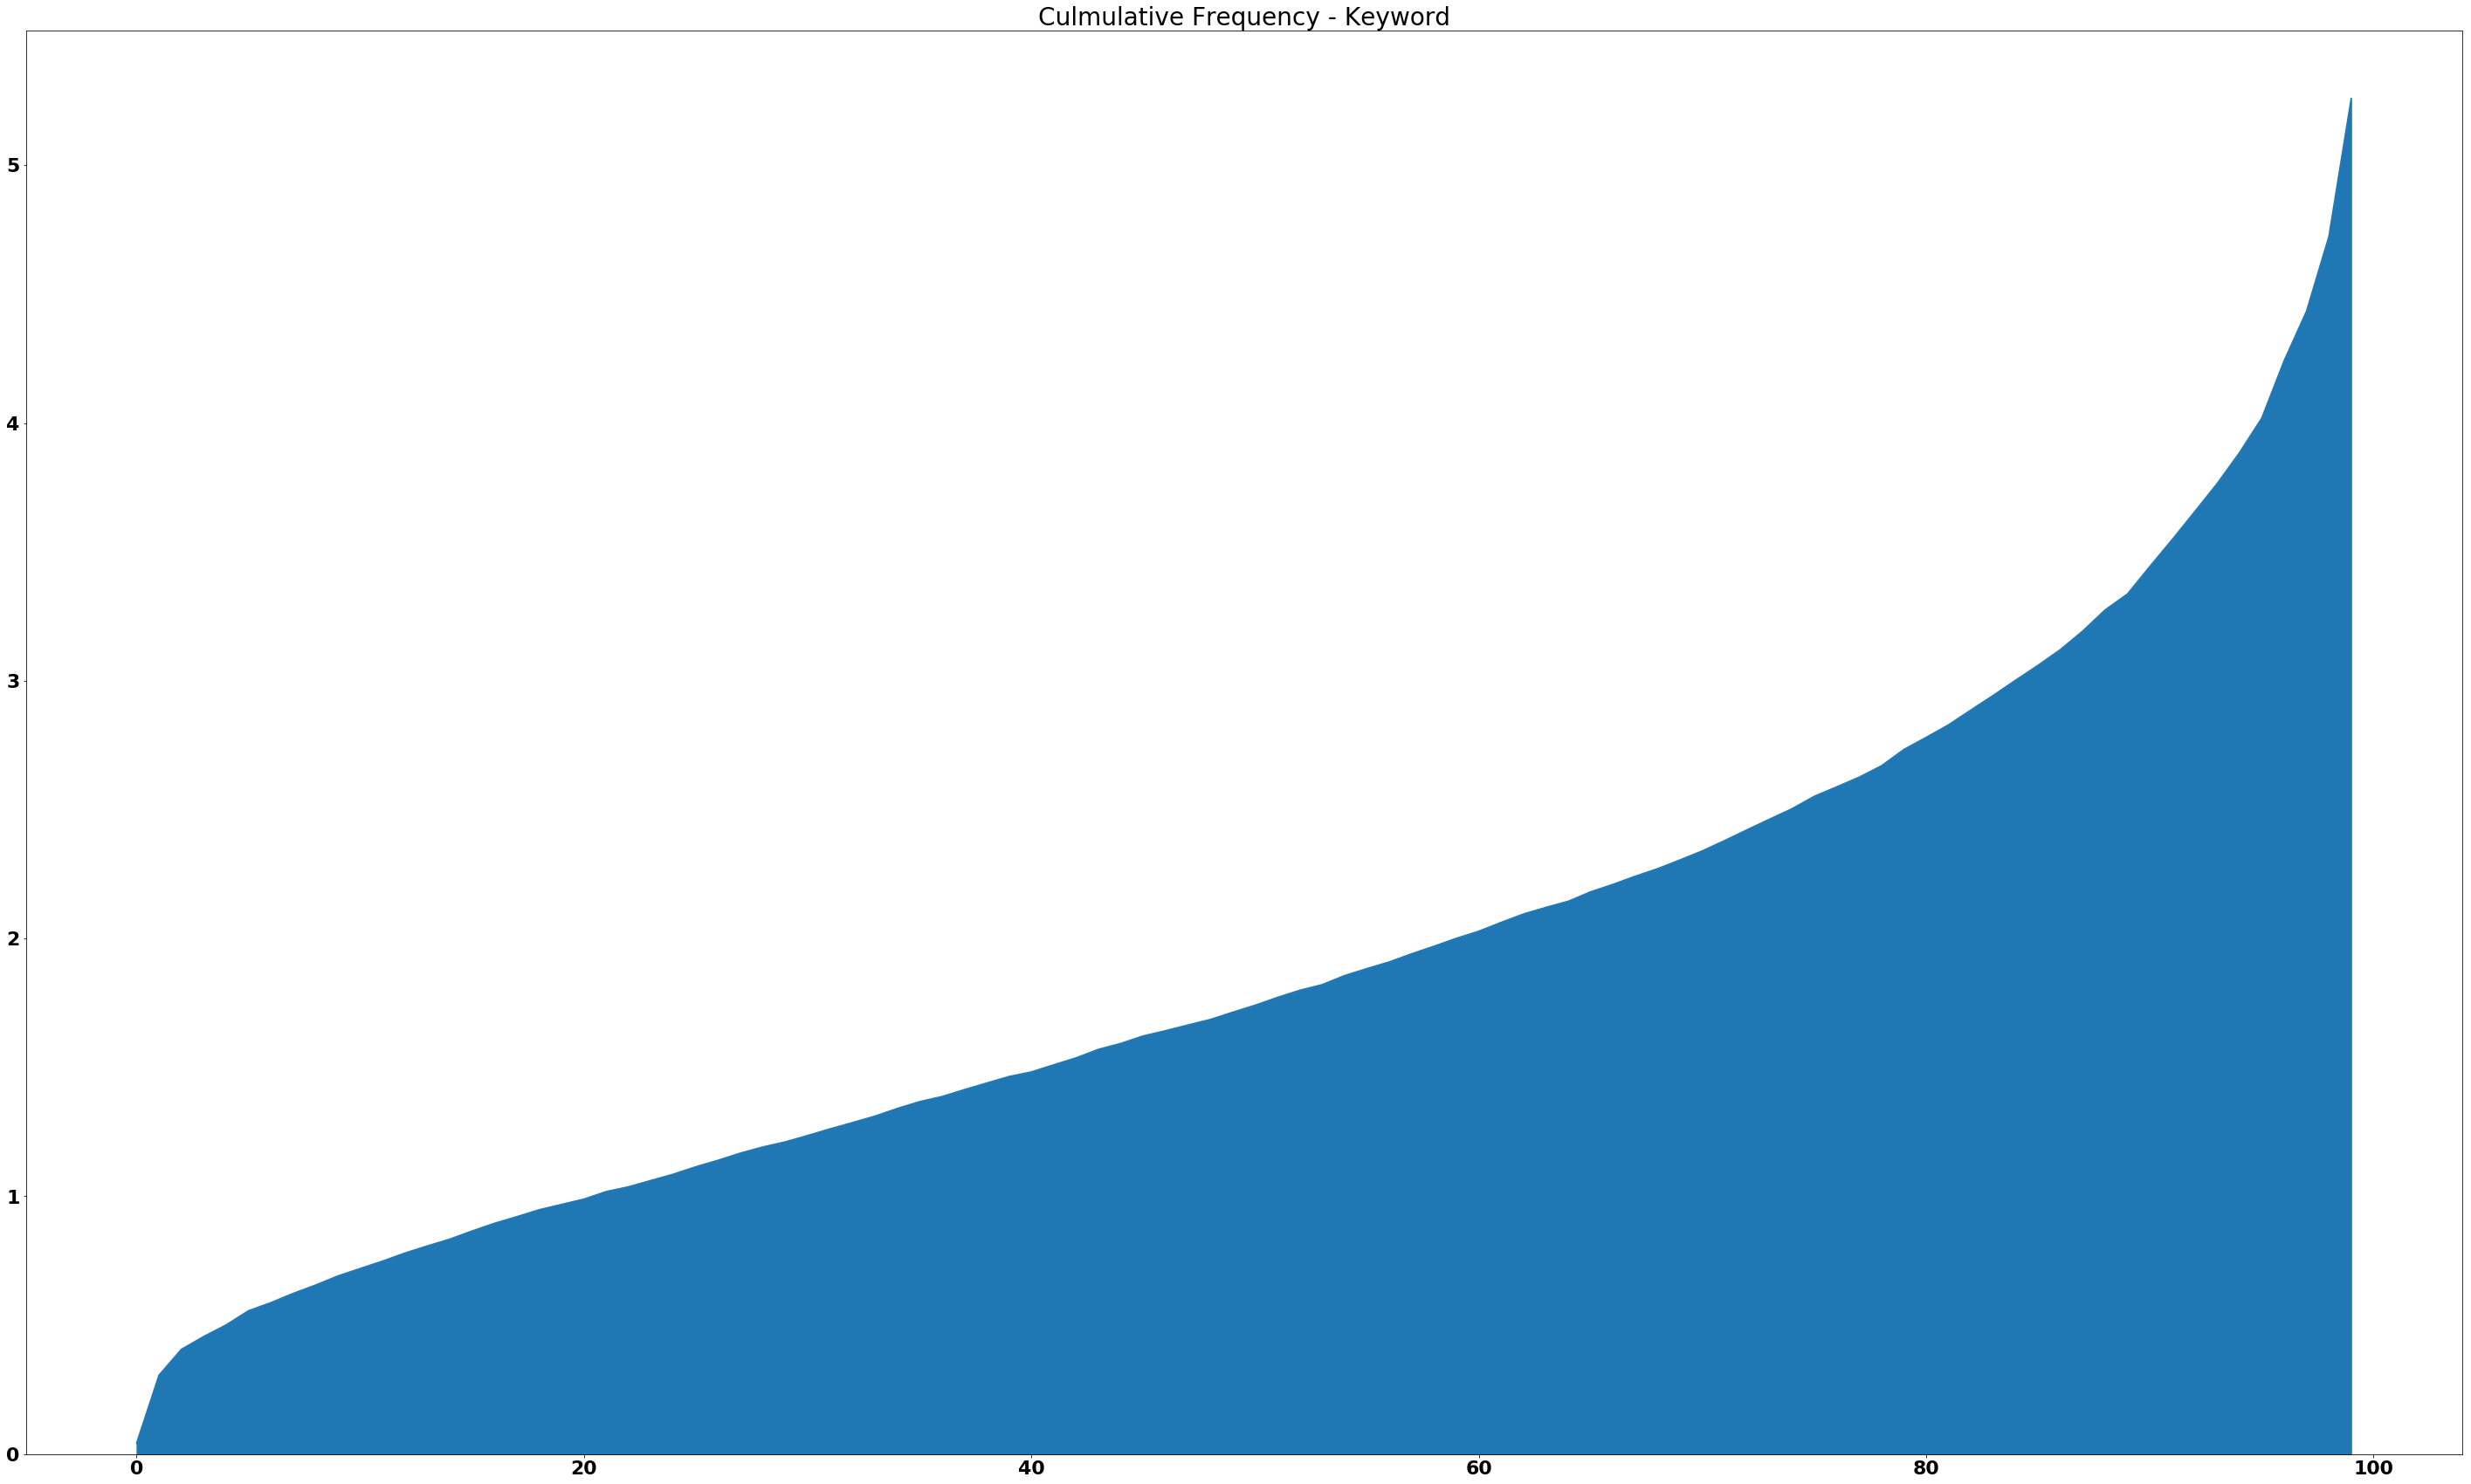

In [188]:
plt.title("Culmulative Frequency - Keyword")
pd.Series(np.percentile(keyword_df, q=[i for i in range(100)])).plot.area()
plt.savefig("plots/cumulative/keyword")

### Silhouette Evaluation

In [6]:
def silhouette_evaluation(X, n_clusters, name, squareform=False):
    fig, ax1 = plt.subplots(figsize=(30, 15))

    clusters = cluster(X, n_clusters)
    
    if squareform:
        X = spatial.distance.squareform(X)

    silhouette_avg = silhouette_score(X, clusters, sample_size=None)
    samples = silhouette_samples(X, clusters)

    y_lower = 10
    for i in range(1, n_clusters + 1):
        cluster_silhouette_scores = samples[clusters == i]
        cluster_silhouette_scores.sort()

        cluster_size = cluster_silhouette_scores.shape[0]
        y_upper = y_lower + cluster_size

        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_scores)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * cluster_size, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title(f'Silhouette Graph (k={n_clusters}) - {name}')

    ax1.set_yticks([])
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.text(silhouette_avg + 0.01,20,f'silhouette_avg={np.round(silhouette_avg, 4)}')
    plt.savefig(f'plots/silhouette/{name}/silhouette_{n_clusters}')
    plt.show()

#### Whole text Evaluation

In [7]:
for i in range(2, 12):
    silhouette_evaluation(abstract_df, i, "abstract", True)

NameError: name 'abstract_df' is not defined

#### Word-based Evaluation

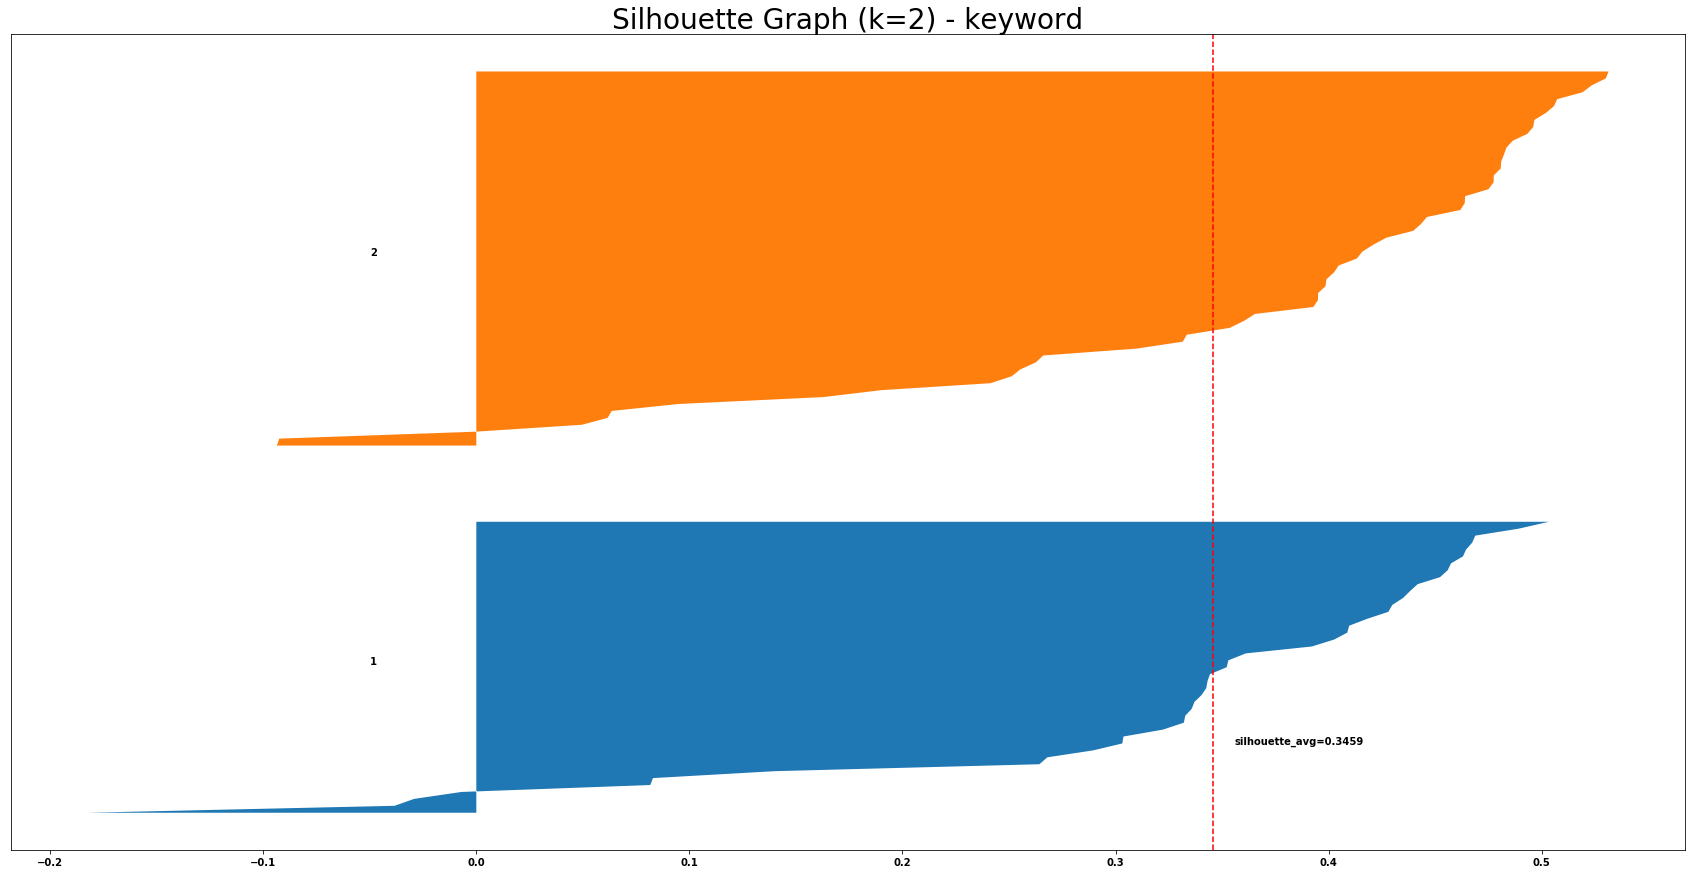

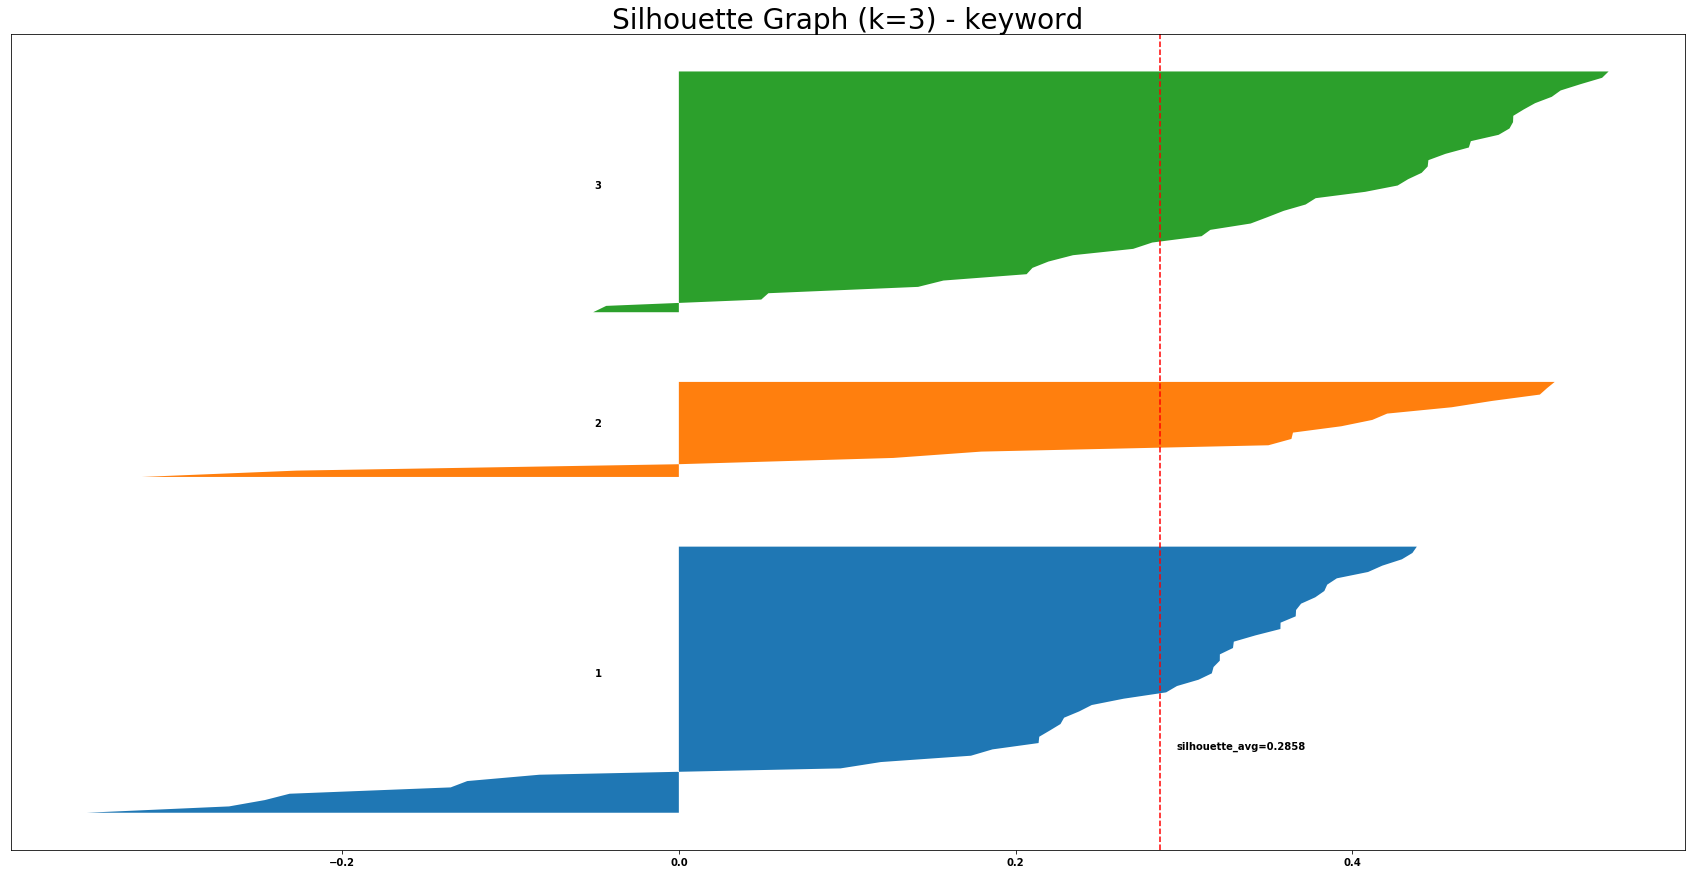

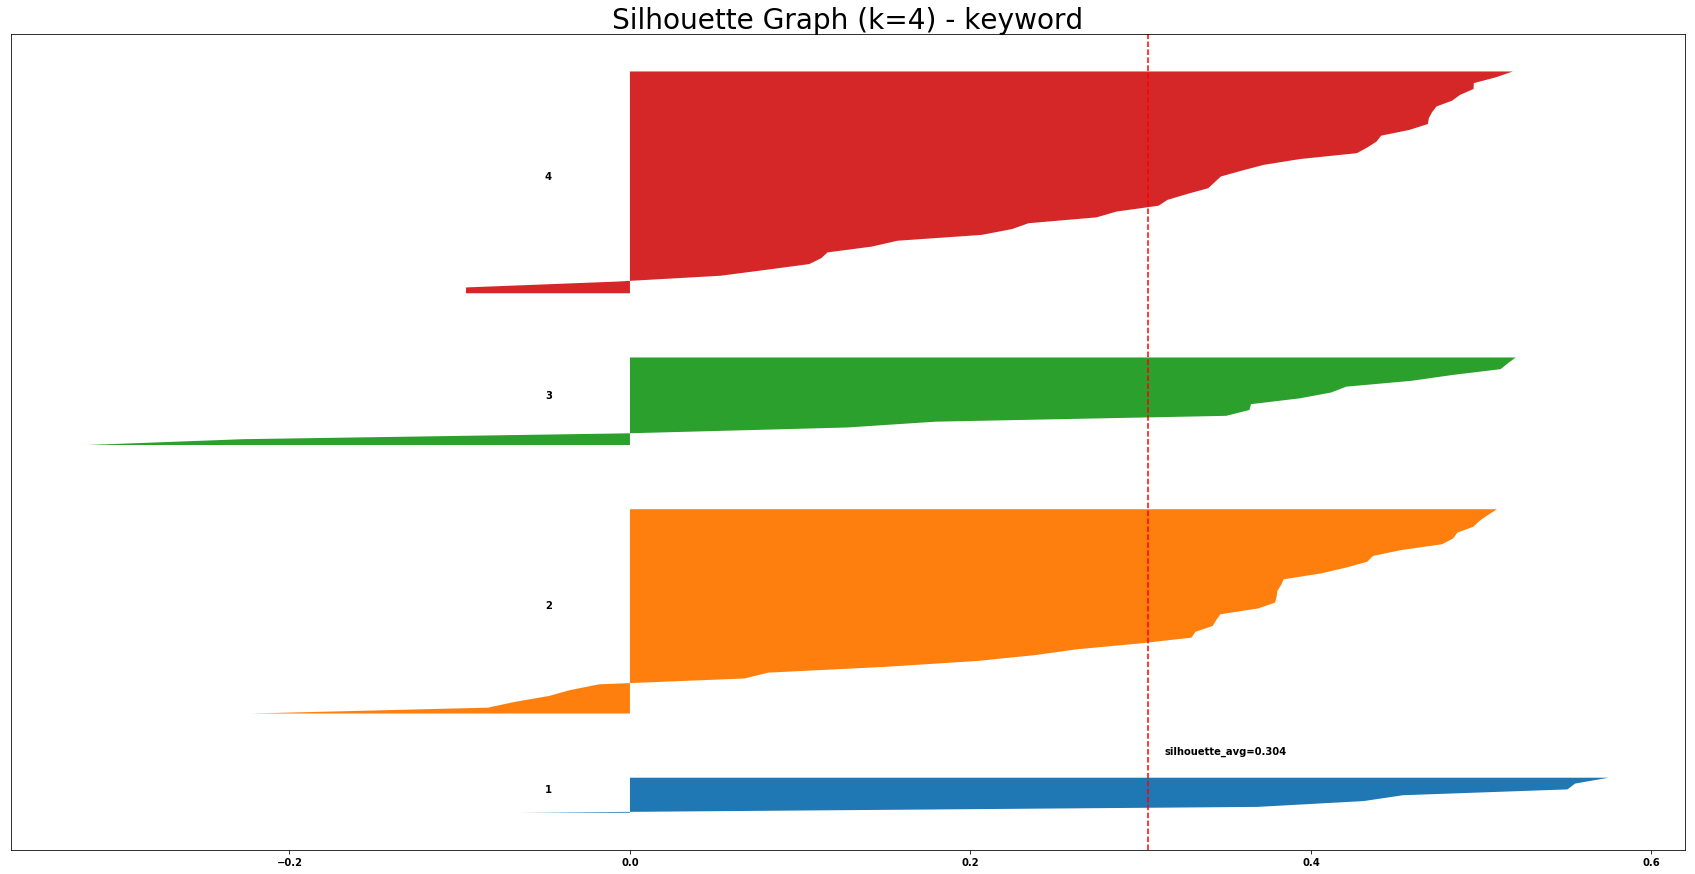

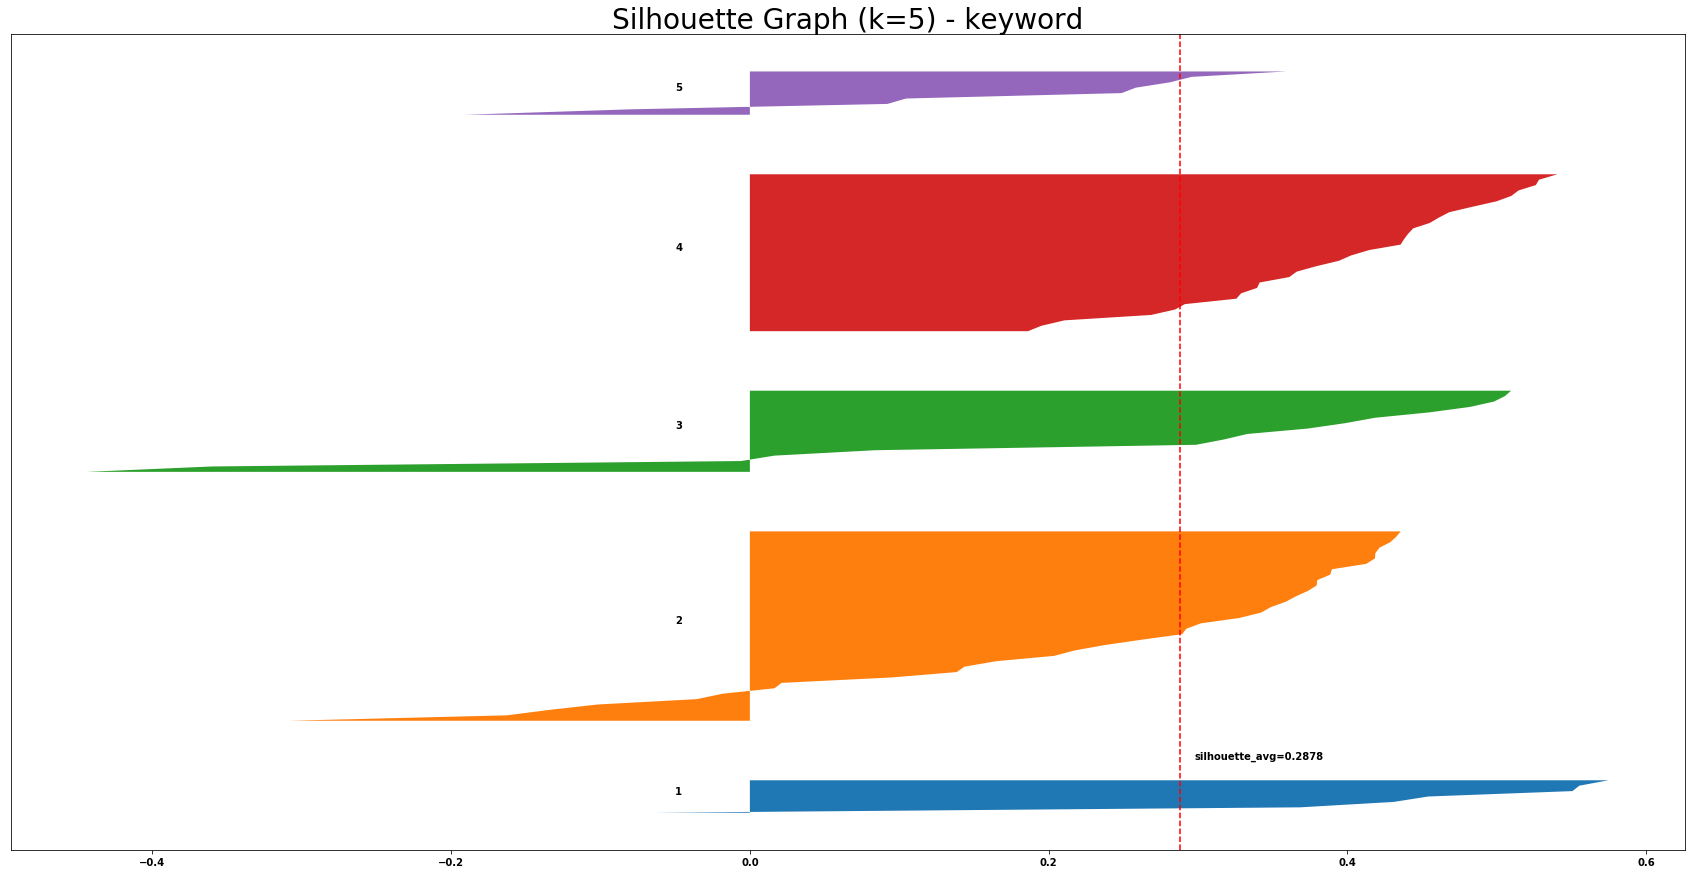

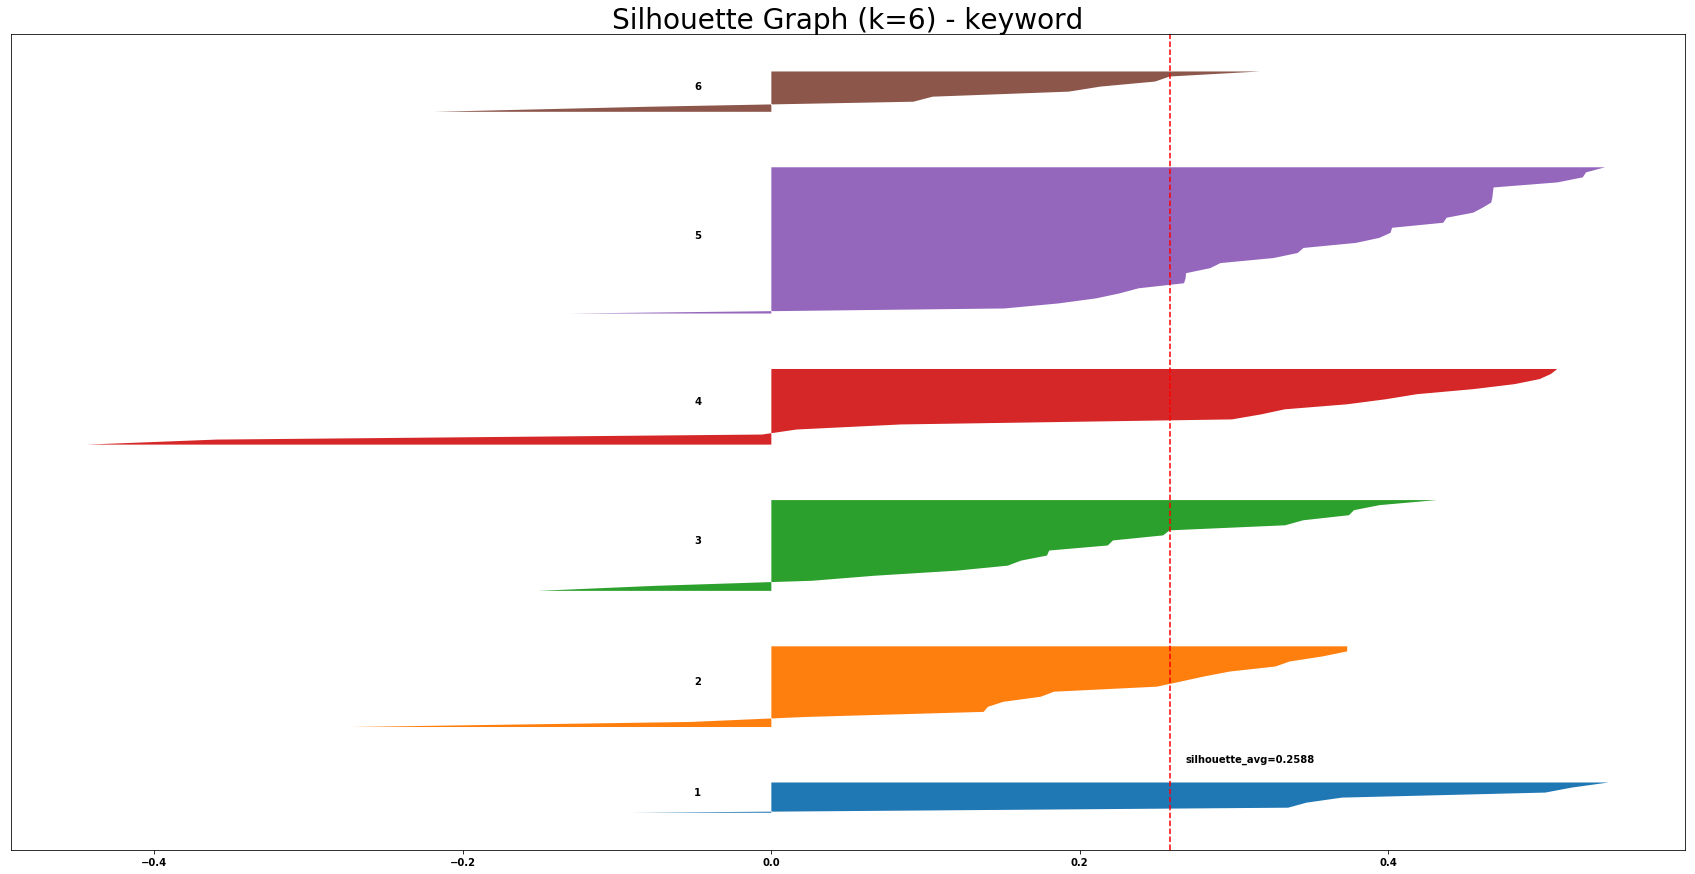

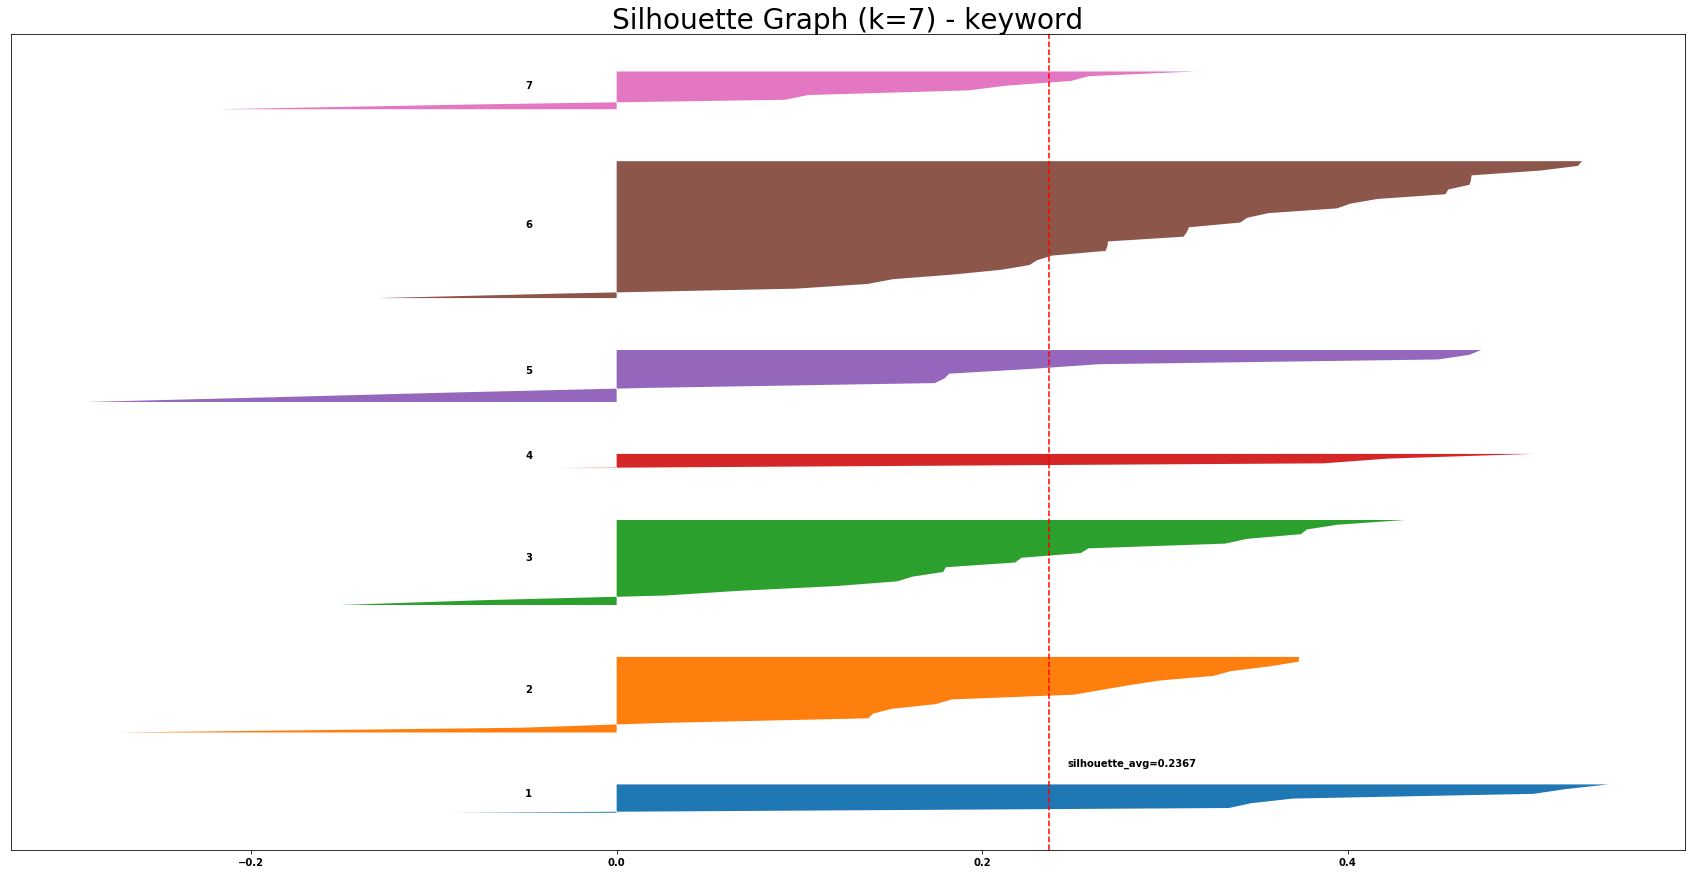

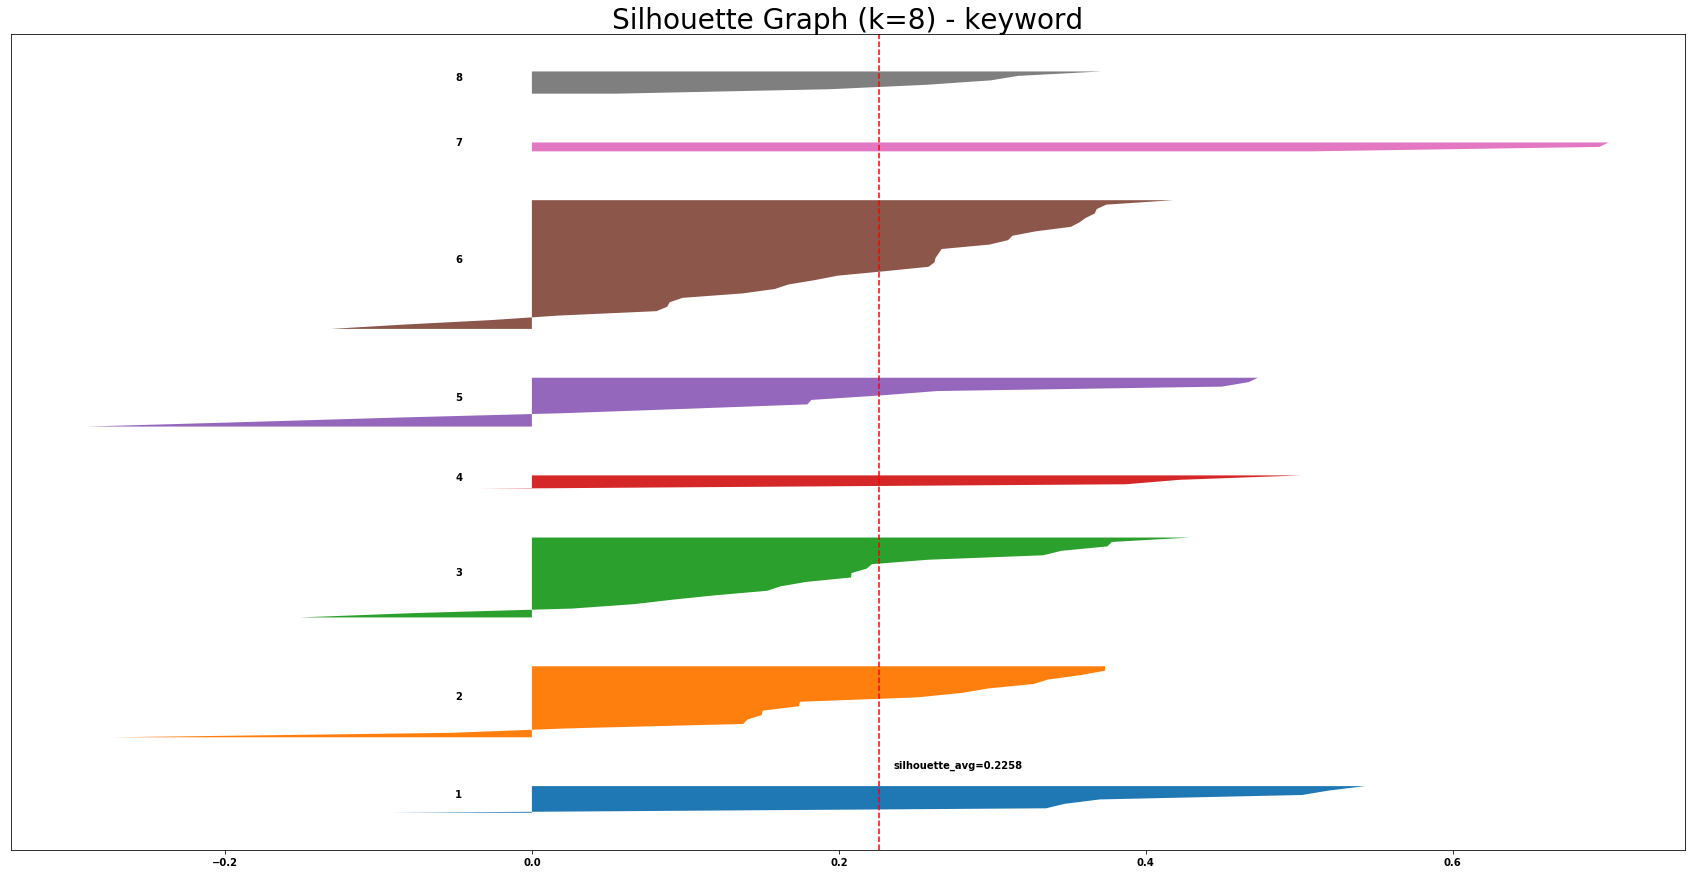

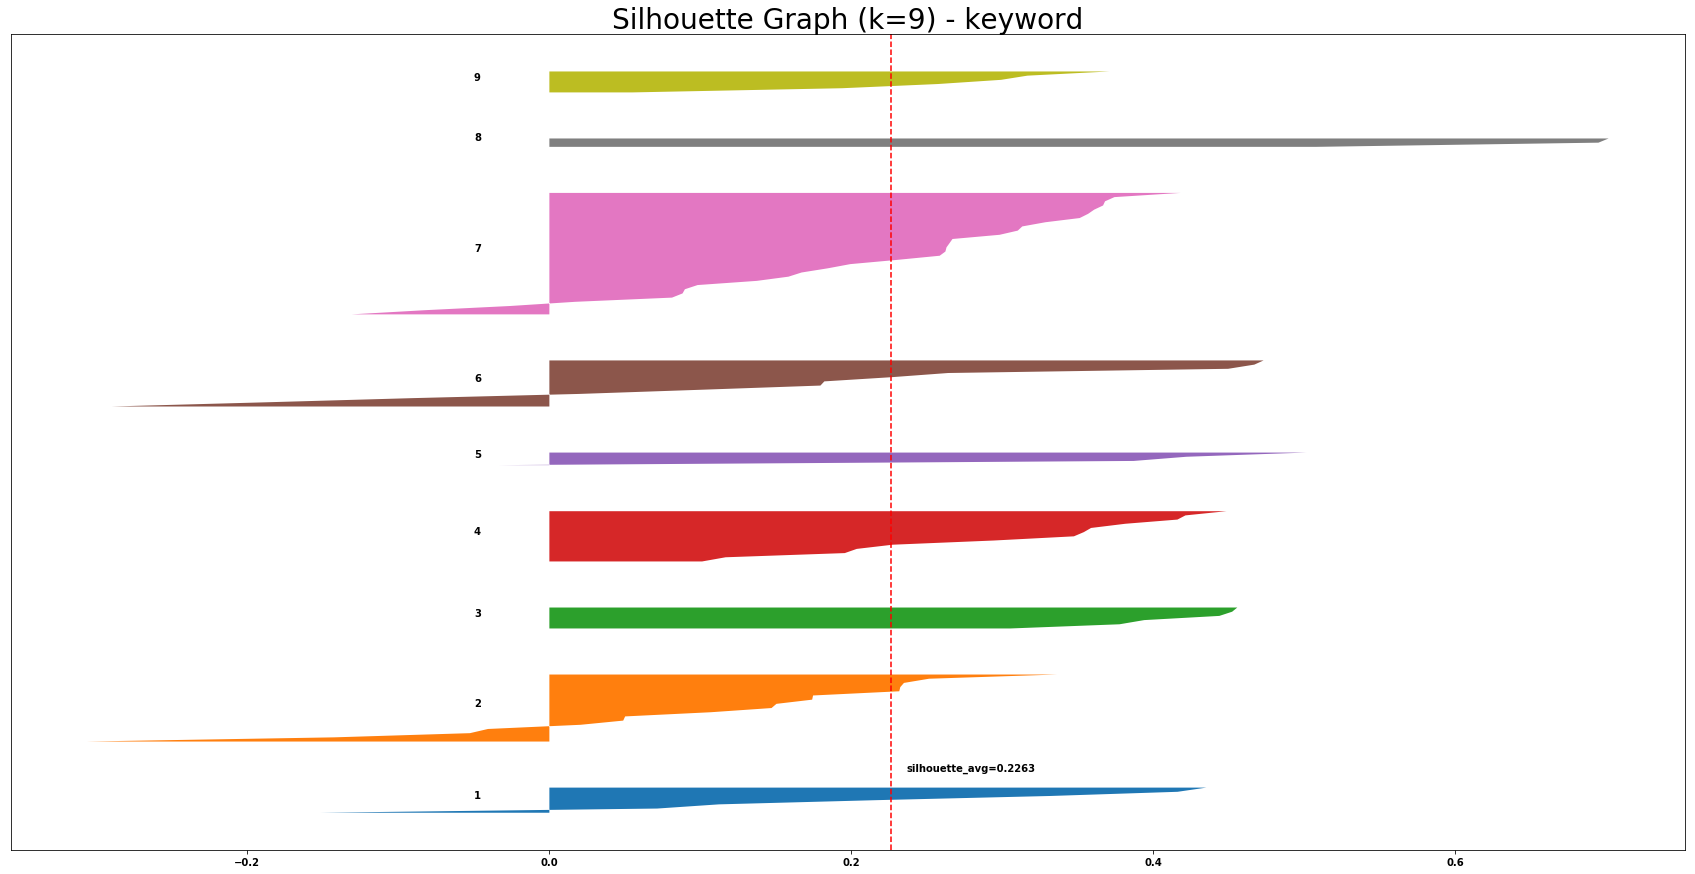

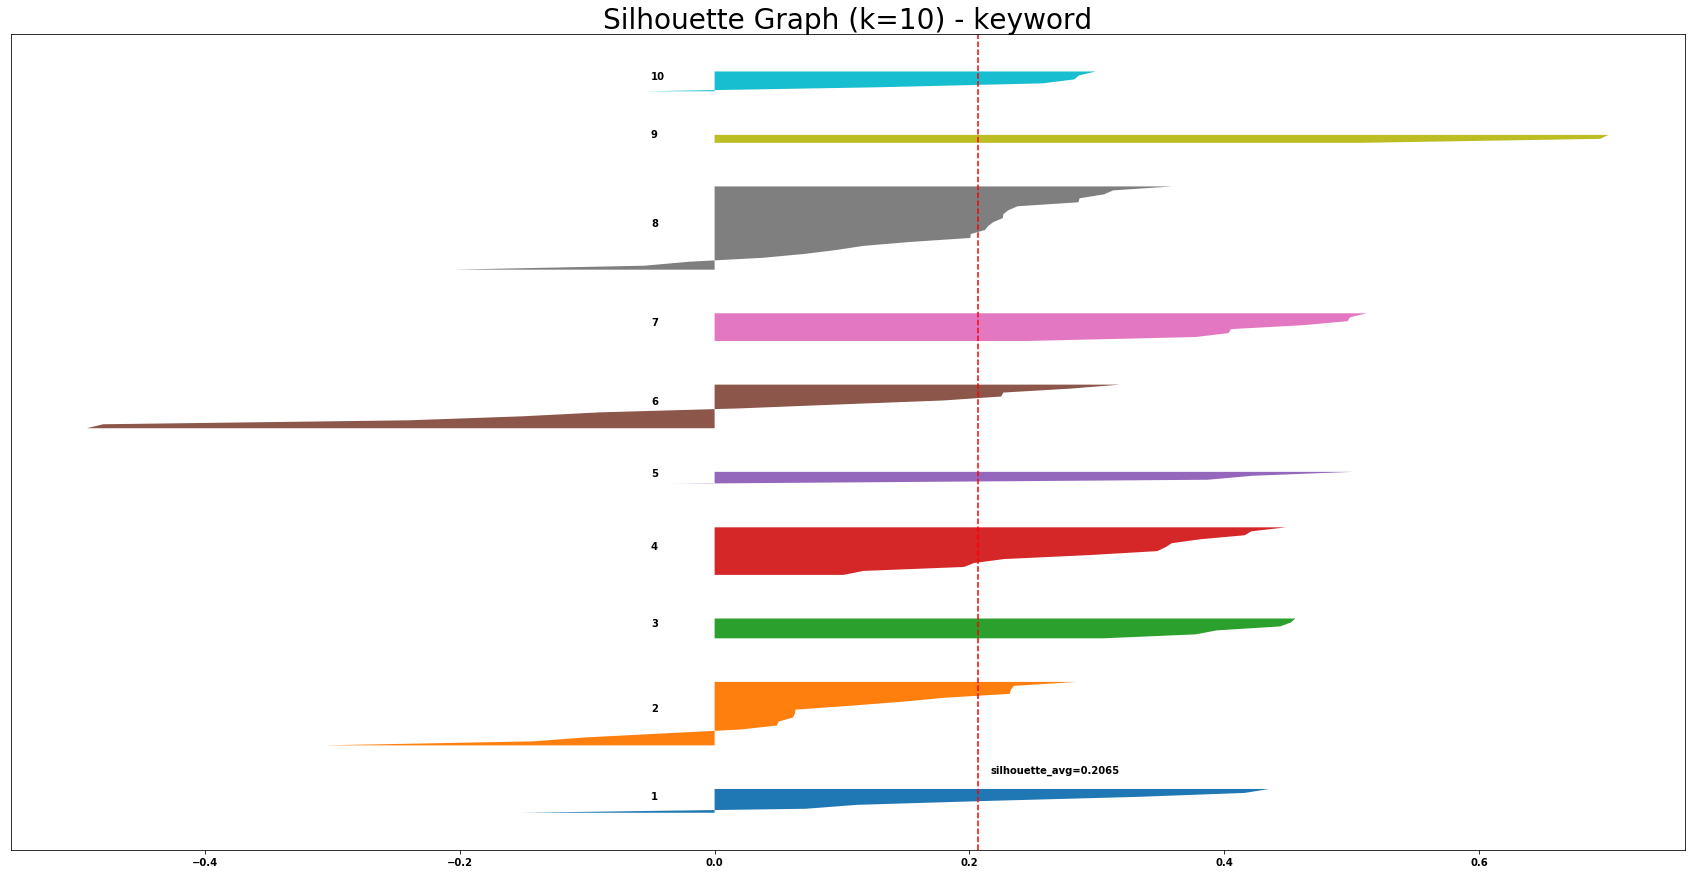

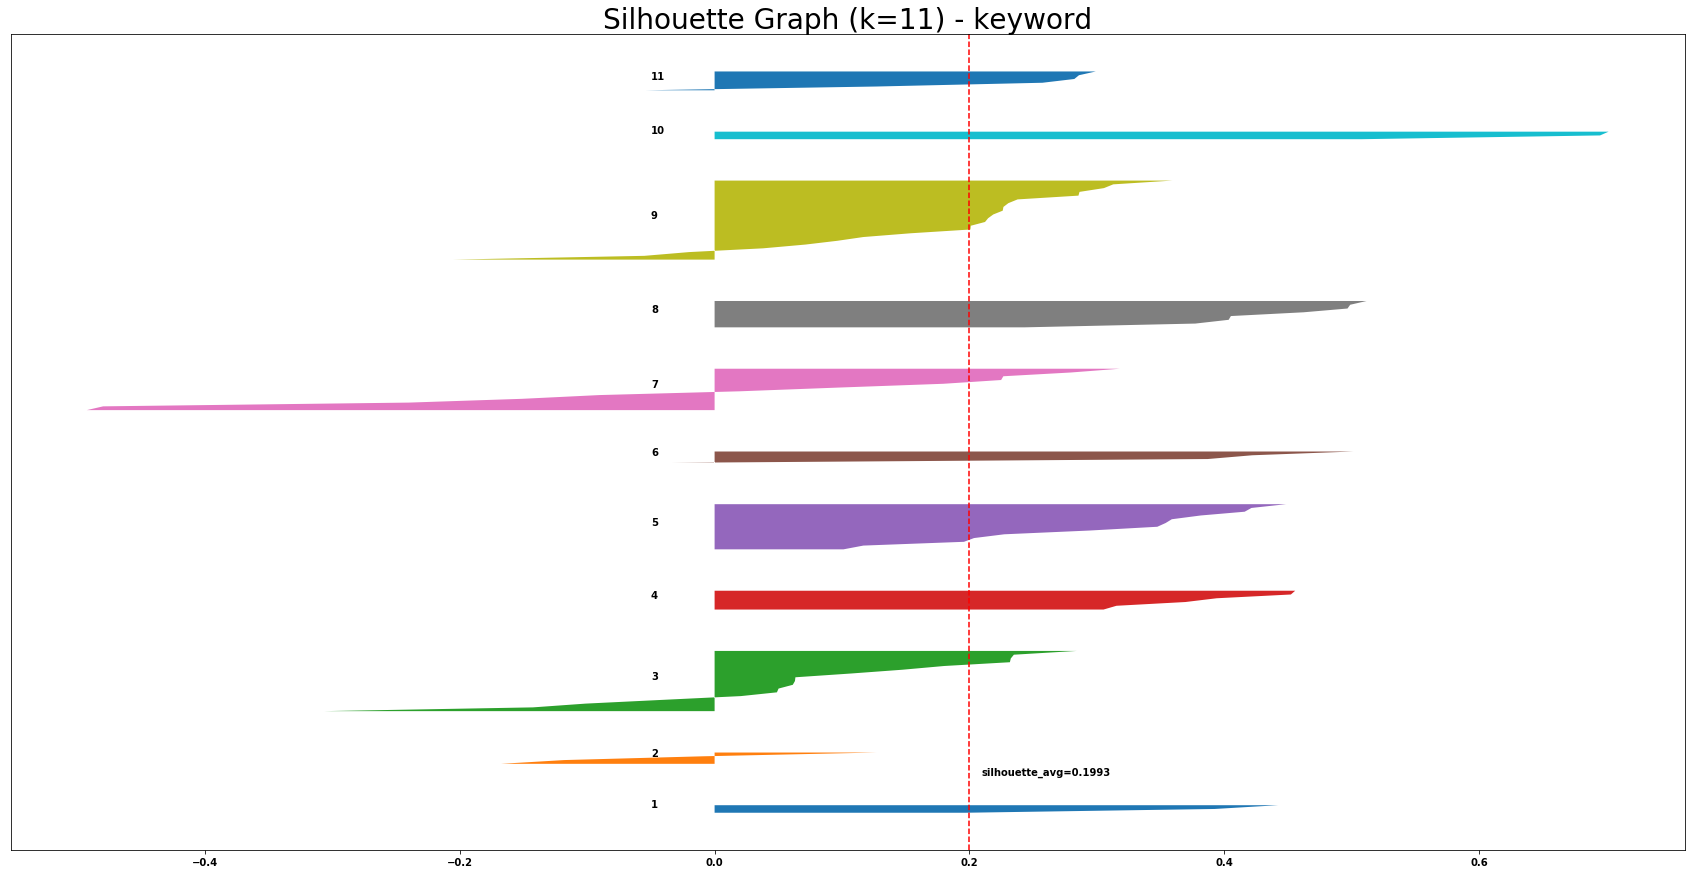

In [26]:
for i in range(2, 12):
    silhouette_evaluation(keyword_df, i, "keyword", True)

#### Labeled Evaluation

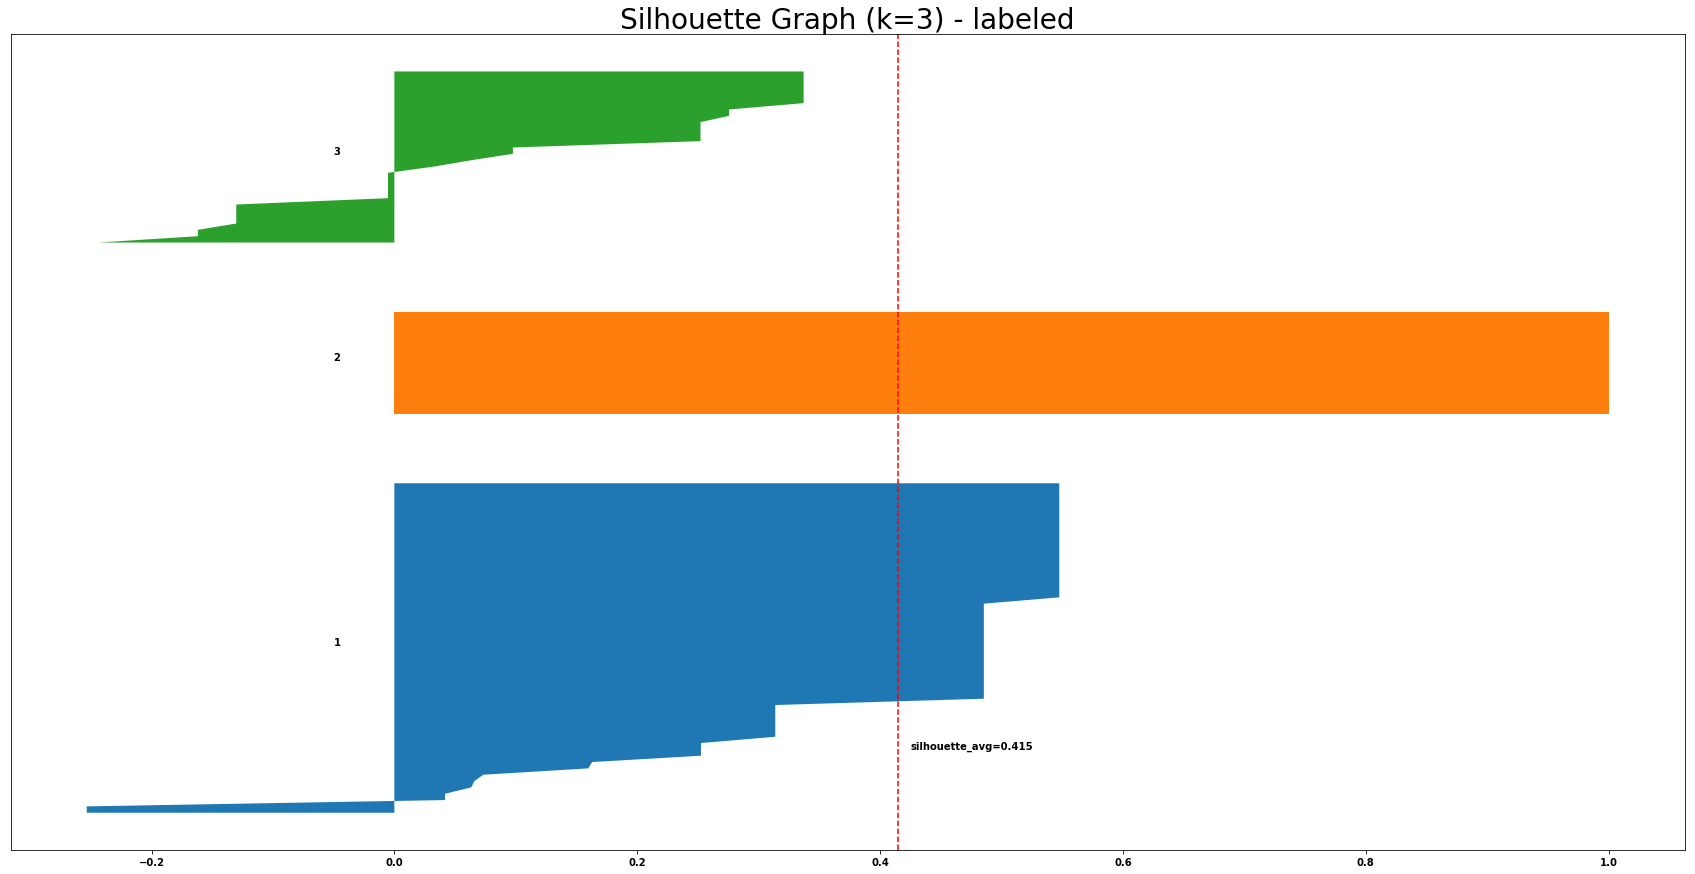

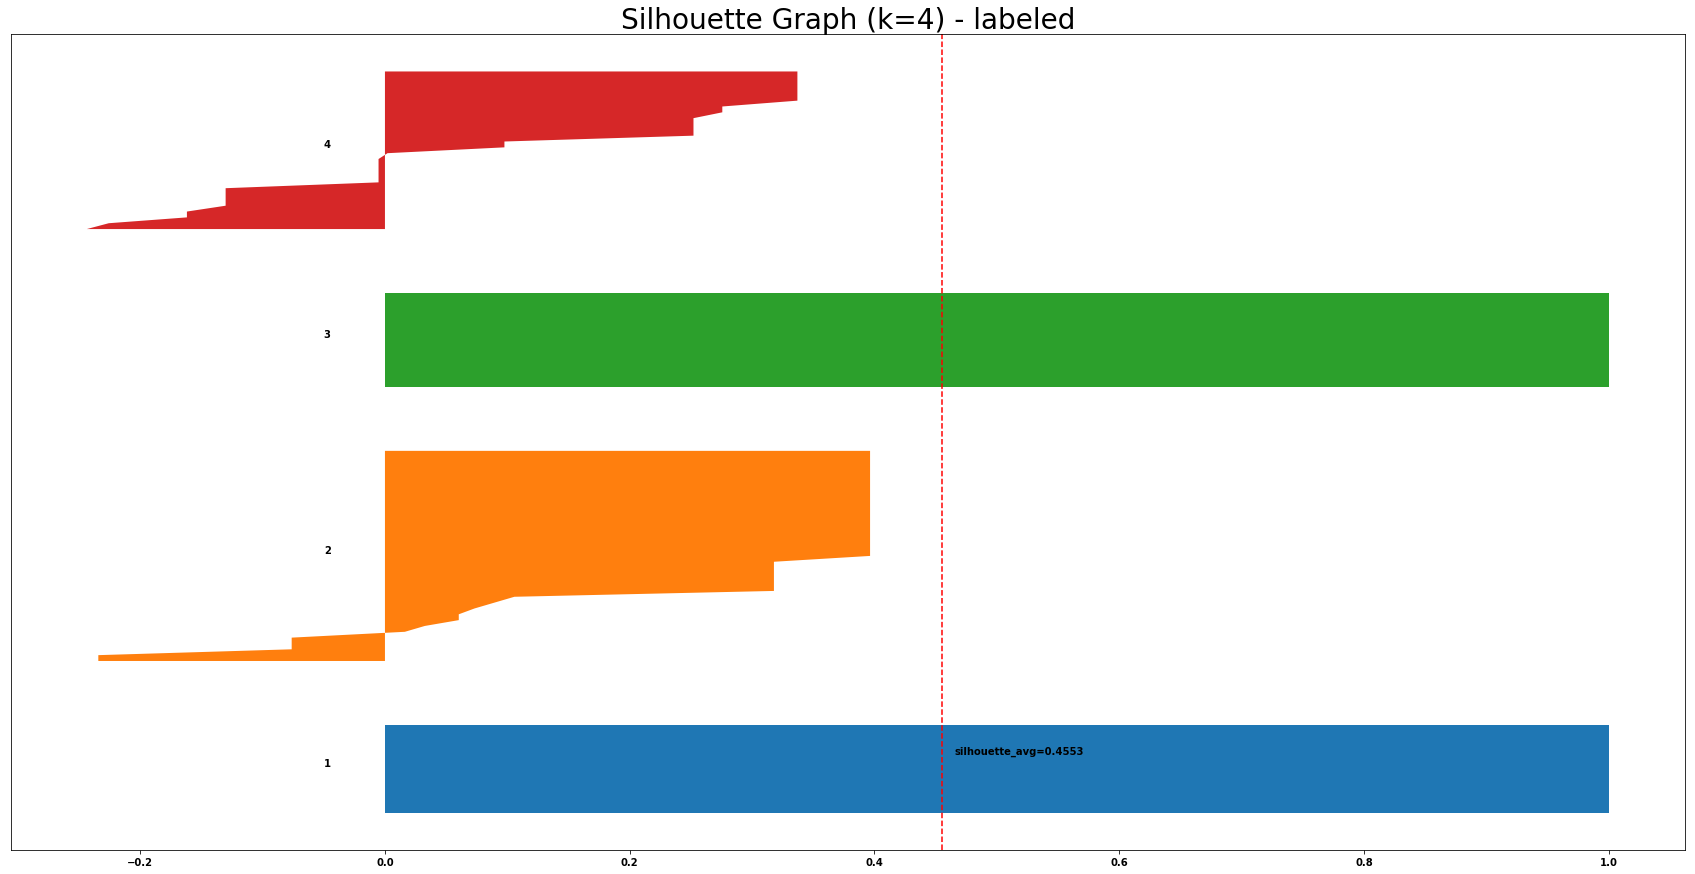

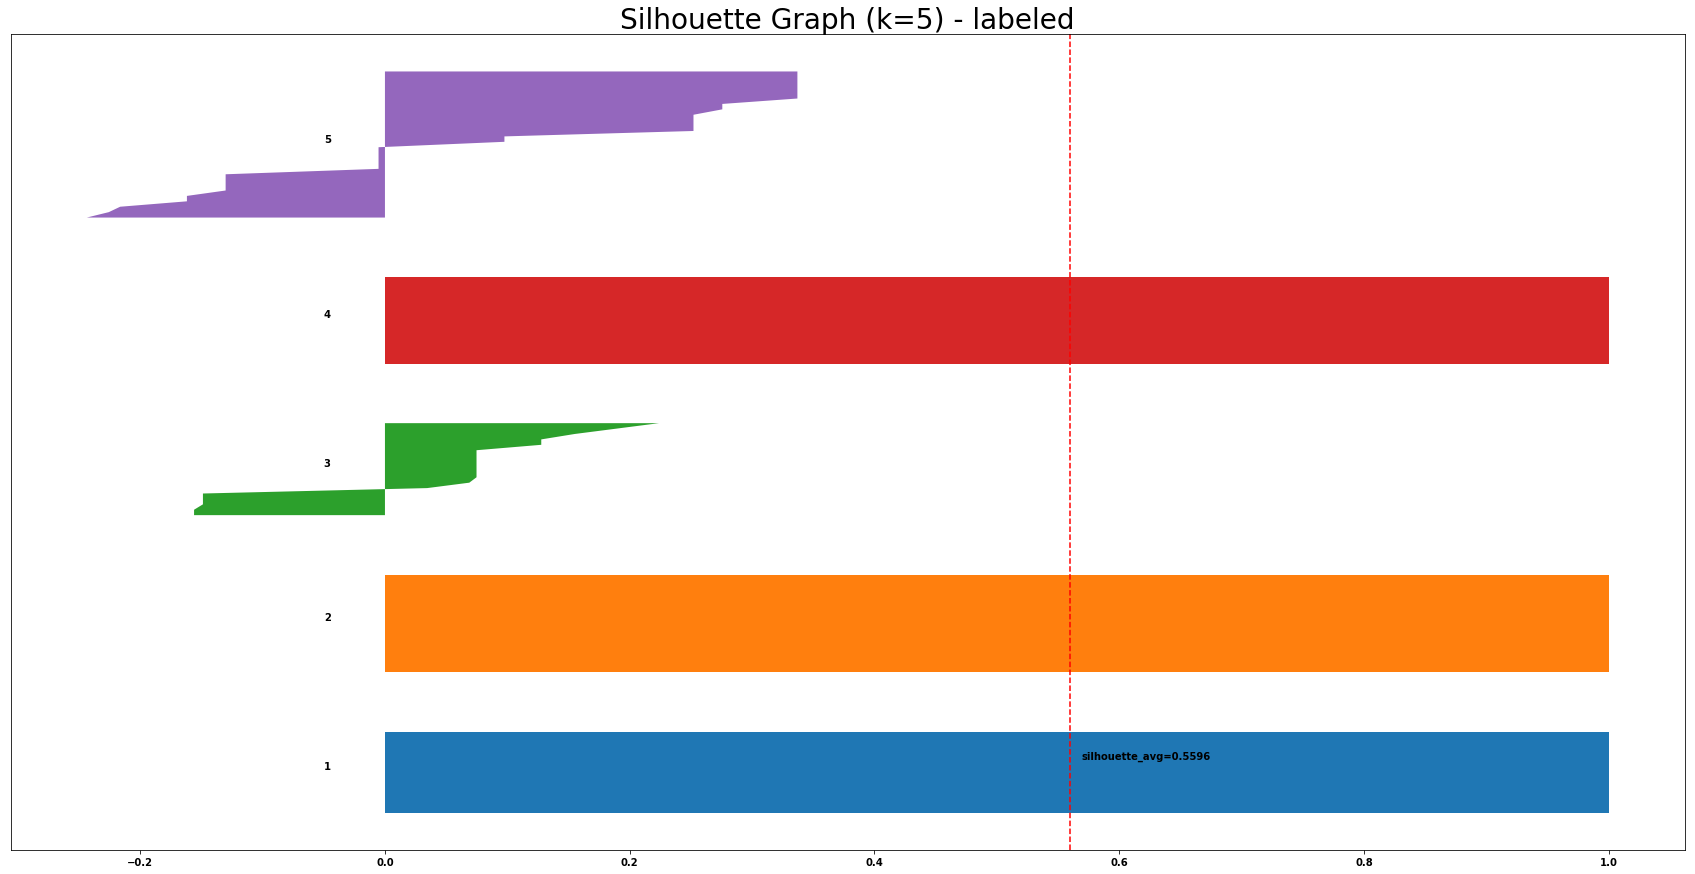

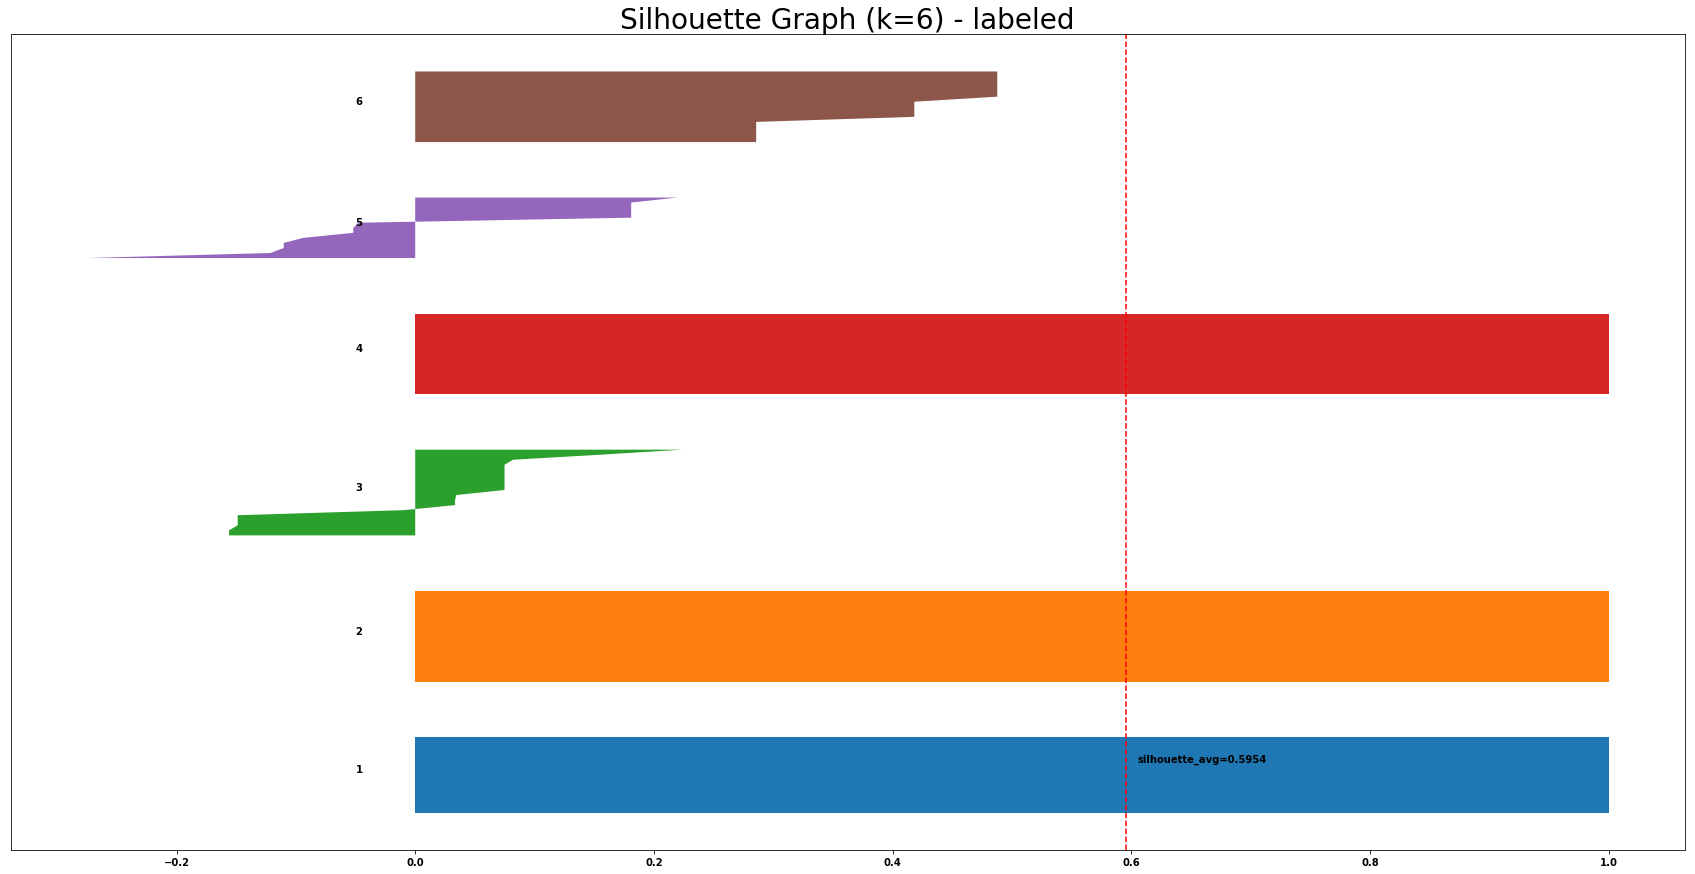

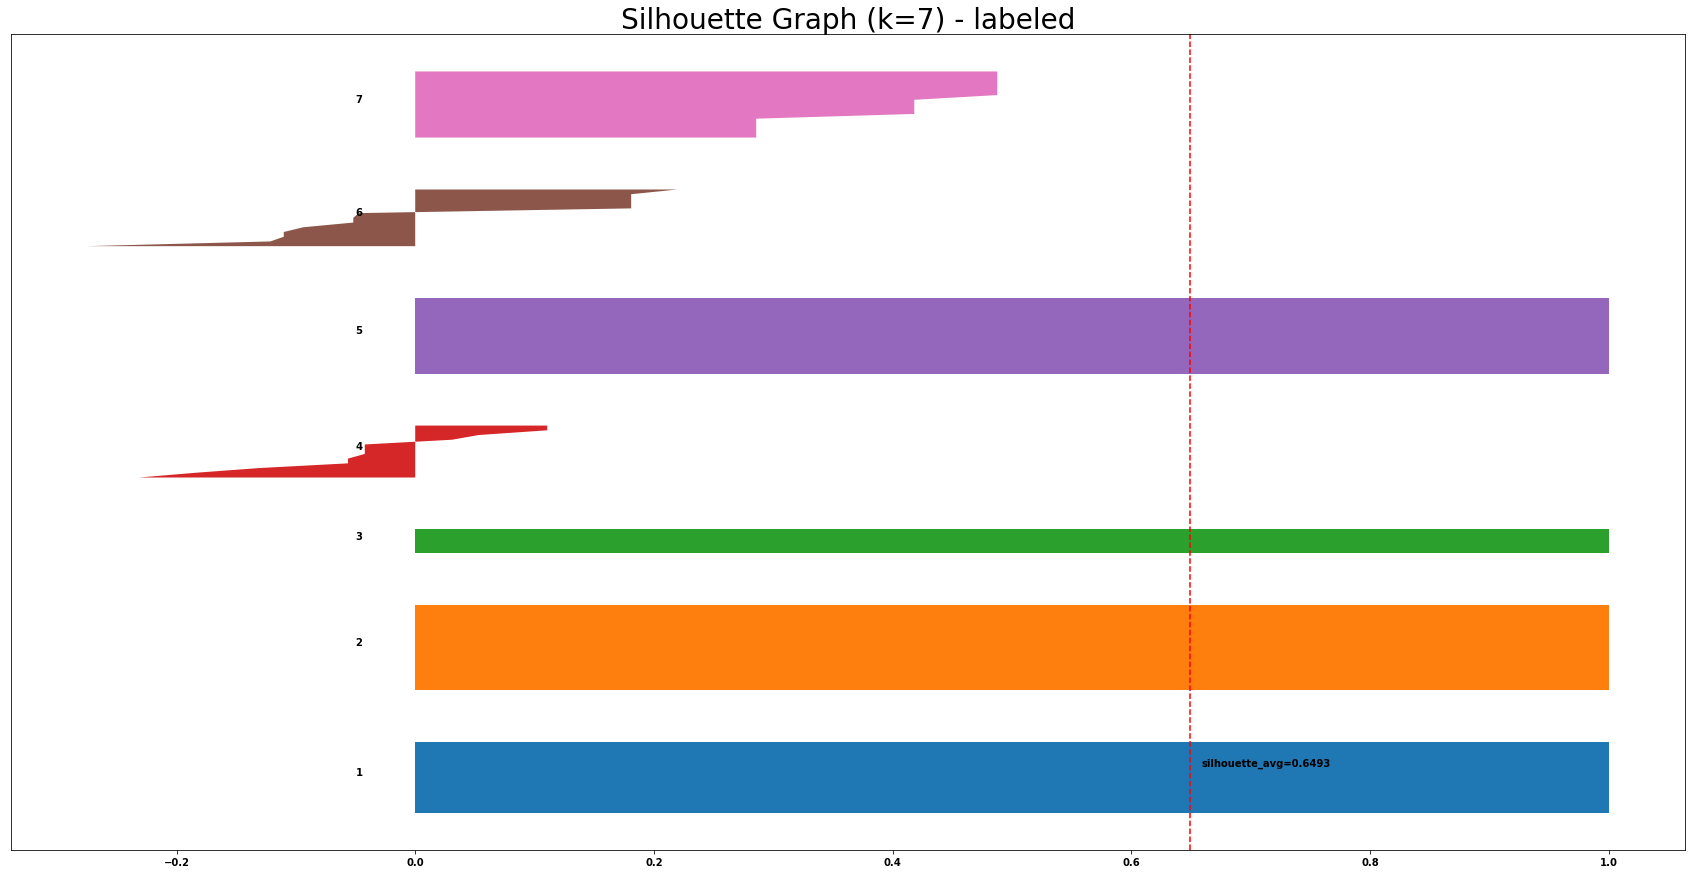

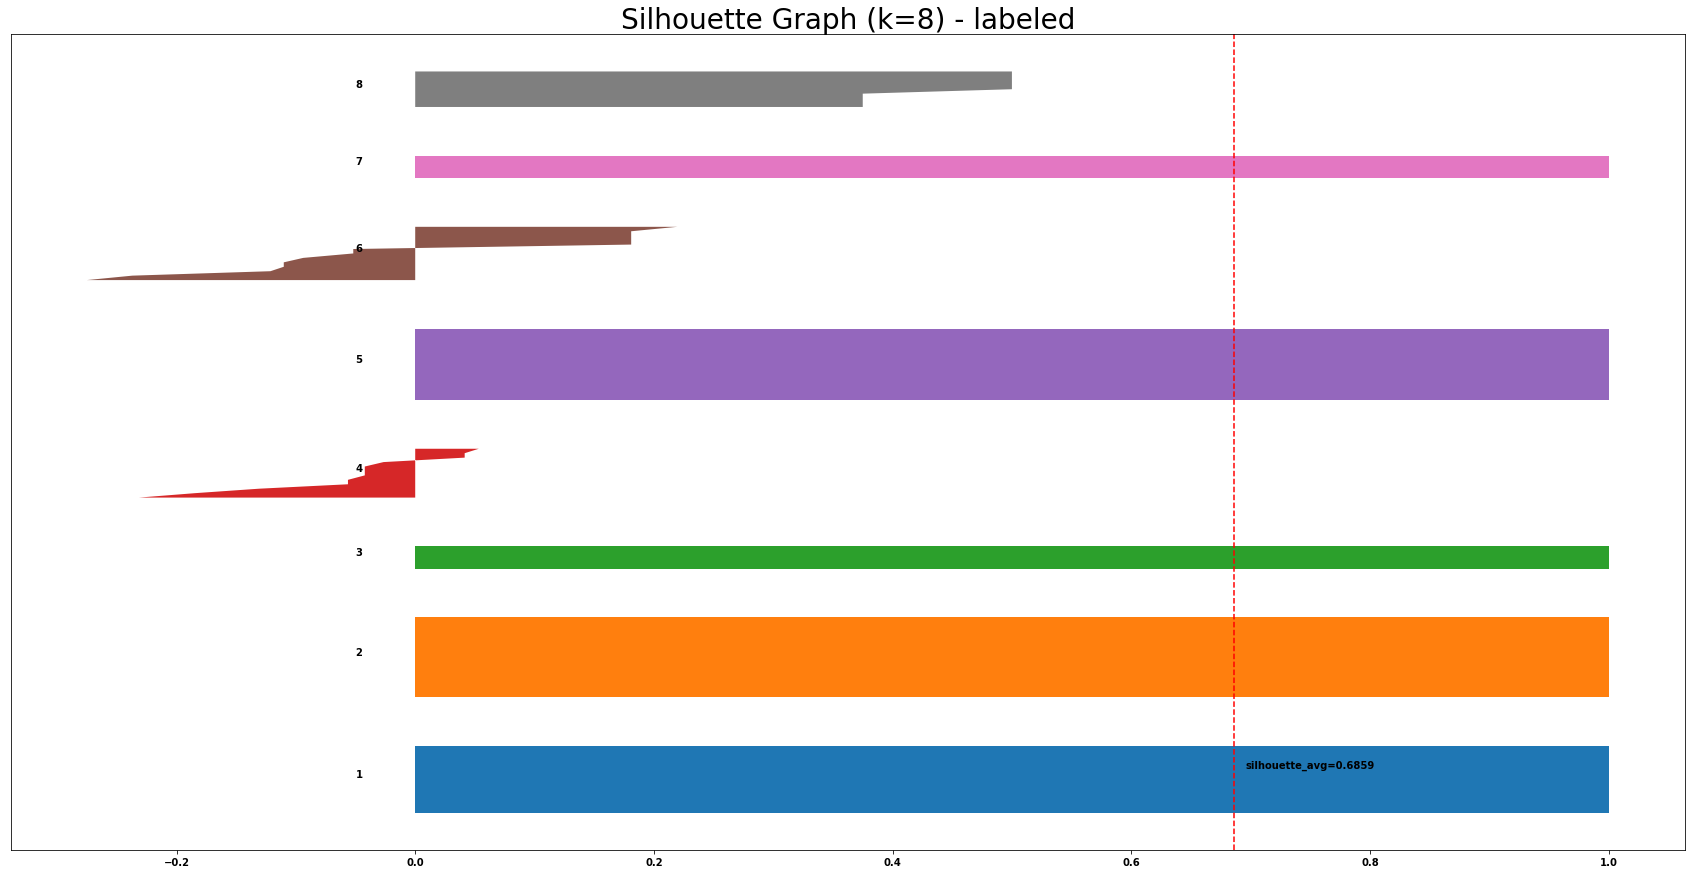

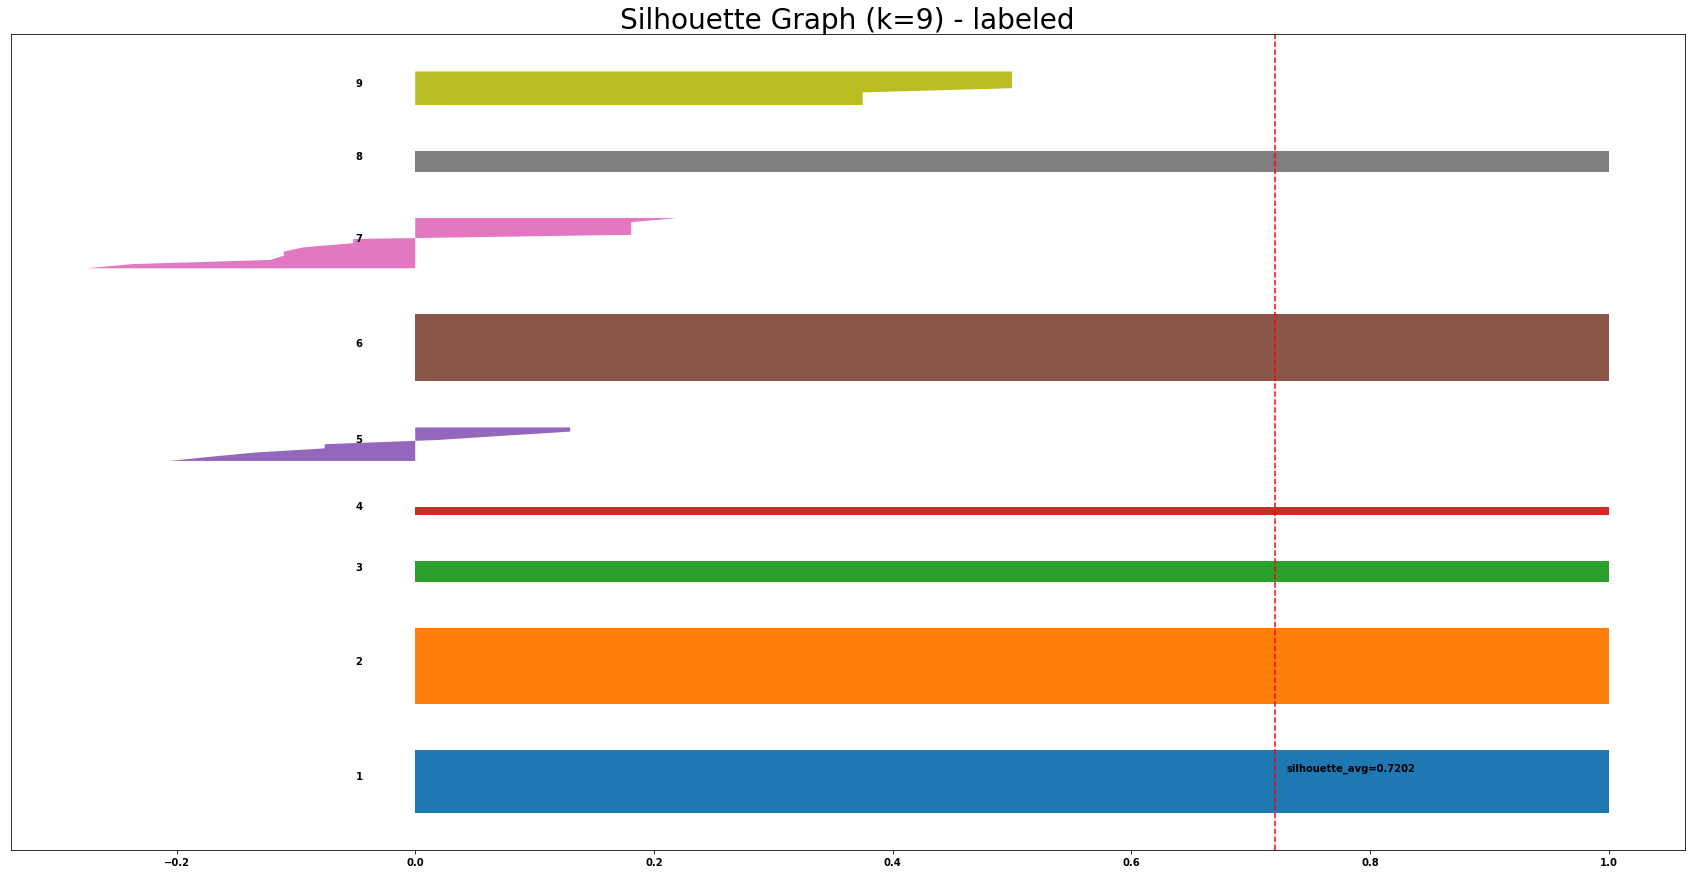

In [27]:
for i in range(3, 10):
    silhouette_evaluation(label_df, i, "labeled")

### Topic Evaluation

In [73]:
def cluster_keyword_scores(clusters):
    result = []
    
    scored_keywords = df.groupby(clusters)["Abstract"]\
                        .apply("\n".join)\
                        .apply(lambda x: keywords(x, lemmatize=True, scores=True, words=5))\

    for i, (group, kw_list) in enumerate(scored_keywords.iteritems()):
        for keyword, score in kw_list:
            result.append((group, keyword, score))
            
    return pd.DataFrame(result, columns=["cluster", "keyword", "score"])

In [74]:
def plot_cluster_keywords(X, n_clusters, title):
    X_scores = cluster_keyword_scores(cluster(X, n_clusters))
    
    fig, axes = plt.subplots(nrows=n_clusters, sharey=True)
        
    fig.suptitle(title, fontsize=35)
    fig.set_figheight(50)
    
    for i, ax in enumerate(axes):
        cluster_num = i + 1
        
        sns.barplot(
            x='keyword',  
            y='score',  
            data=X_scores[X_scores['cluster'] == cluster_num],
            ax=ax
        )

        ax.set_title(f"cluster={cluster_num}")
        ax.set_xlabel(None)
        ax.tick_params(axis='x', labelsize=40)
        
    
    fig.savefig(f'plots/keywords/{title}.pdf', format='pdf')


#### Labeled Clusters

    cluster     keyword     score
0         1      priced  0.413691
1         1    customer  0.340210
2         1      demand  0.154412
3         1    consumer  0.149823
4         1    products  0.144395
5         2    customer  0.317756
6         2     modeled  0.259598
7         2    services  0.232347
8         2    consumer  0.214324
9         2     pricing  0.152791
10        3      models  0.244139
11        3     pricing  0.215846
12        3  processing  0.201441
13        3  optimality  0.187643
14        3      agents  0.176811
15        4      models  0.304590
16        4   decisions  0.223061
17        4      orders  0.190879
18        4      levels  0.176533
19        4   inventory  0.165630
20        5   customers  0.458539
21        5    services  0.317882
22        5     pricing  0.176442
23        5      models  0.169223
24        5       times  0.158100
25        6    operated  0.256605
26        6   knowledge  0.256048
27        6        team  0.240679
28        6   

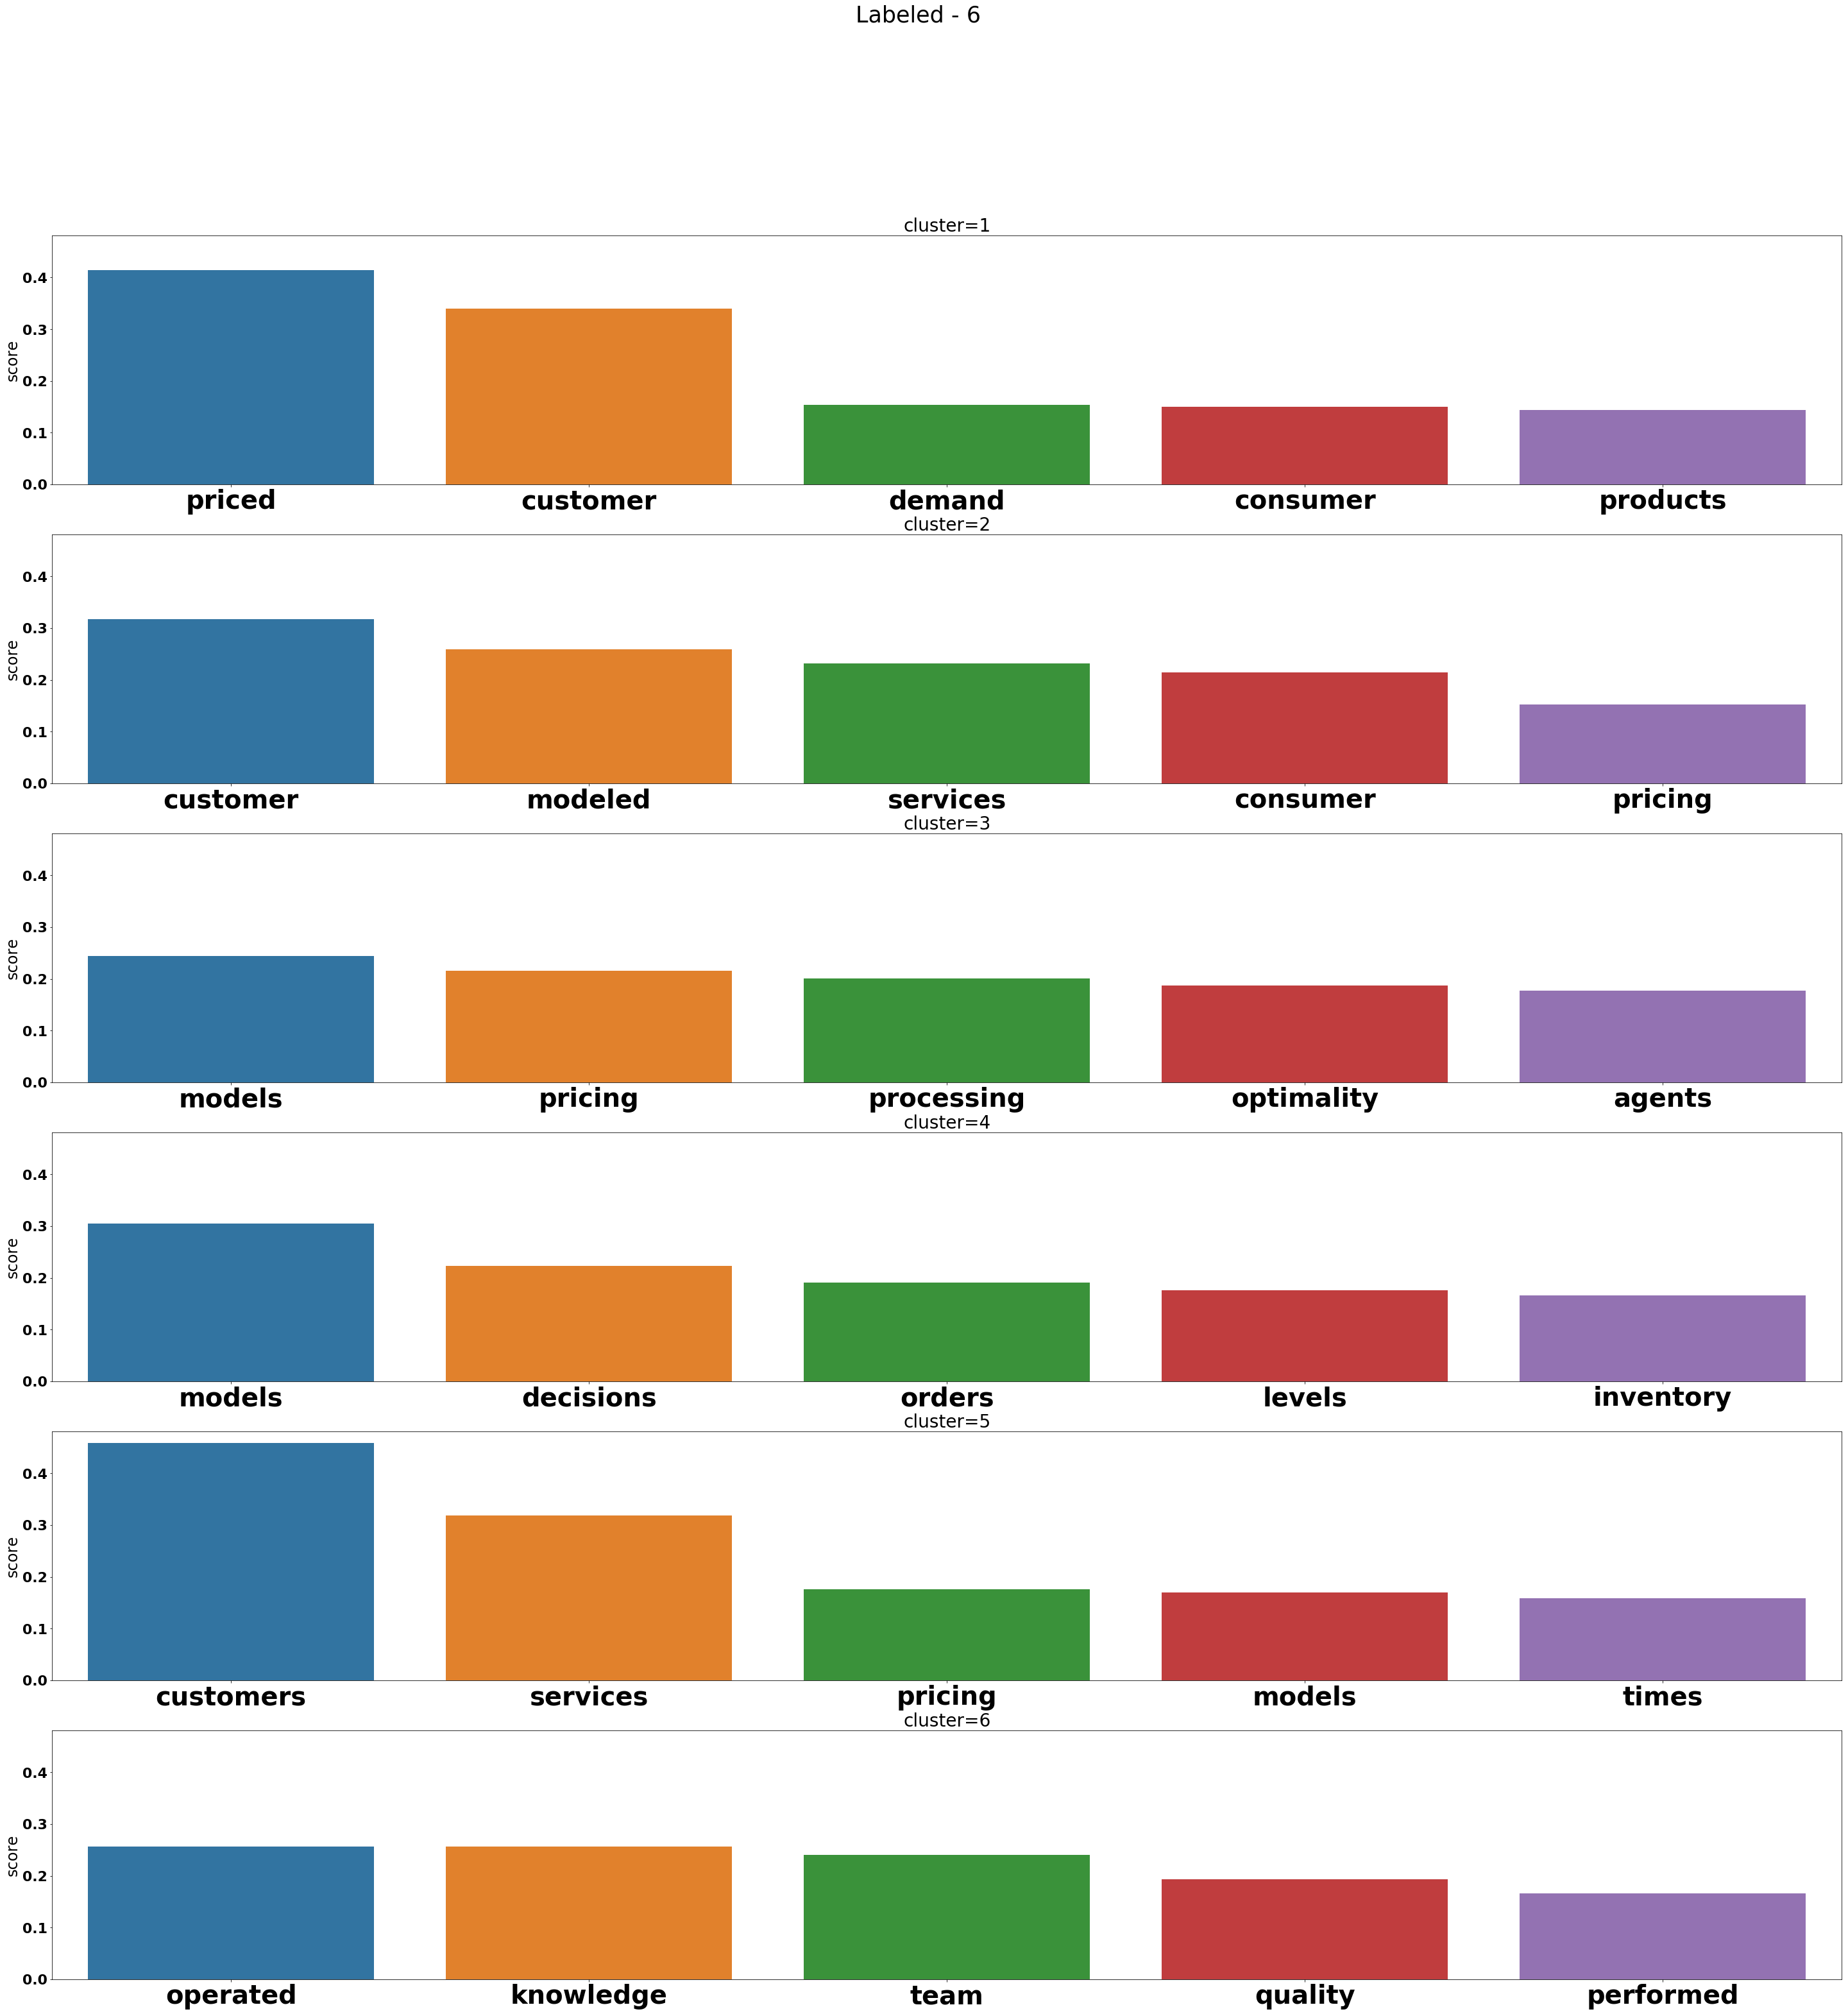

In [75]:
plot_cluster_keywords(label_df, 6, "Labeled - 6")

#### Keyword Evaluation

    cluster      keyword     score
0         1     customer  0.368023
1         1  information  0.233129
2         1   profitable  0.225439
3         1    decisions  0.221866
4         1      service  0.204035
5         2     customer  0.347274
6         2     services  0.291445
7         2       priced  0.190418
8         2       models  0.166954
9         2   optimizers  0.153926
10        3      pricing  0.253224
11        3     modeling  0.231432
12        3     consumer  0.205550
13        3      manager  0.183882
14        3   production  0.154597
15        4      modeled  0.287601
16        4      pricing  0.274376
17        4    customers  0.264833
18        4   production  0.195686
19        4        level  0.185869
20        5     services  0.262283
21        5      perform  0.240036
22        5    knowledge  0.212548
23        5    customers  0.201613
24        5     channels  0.184550


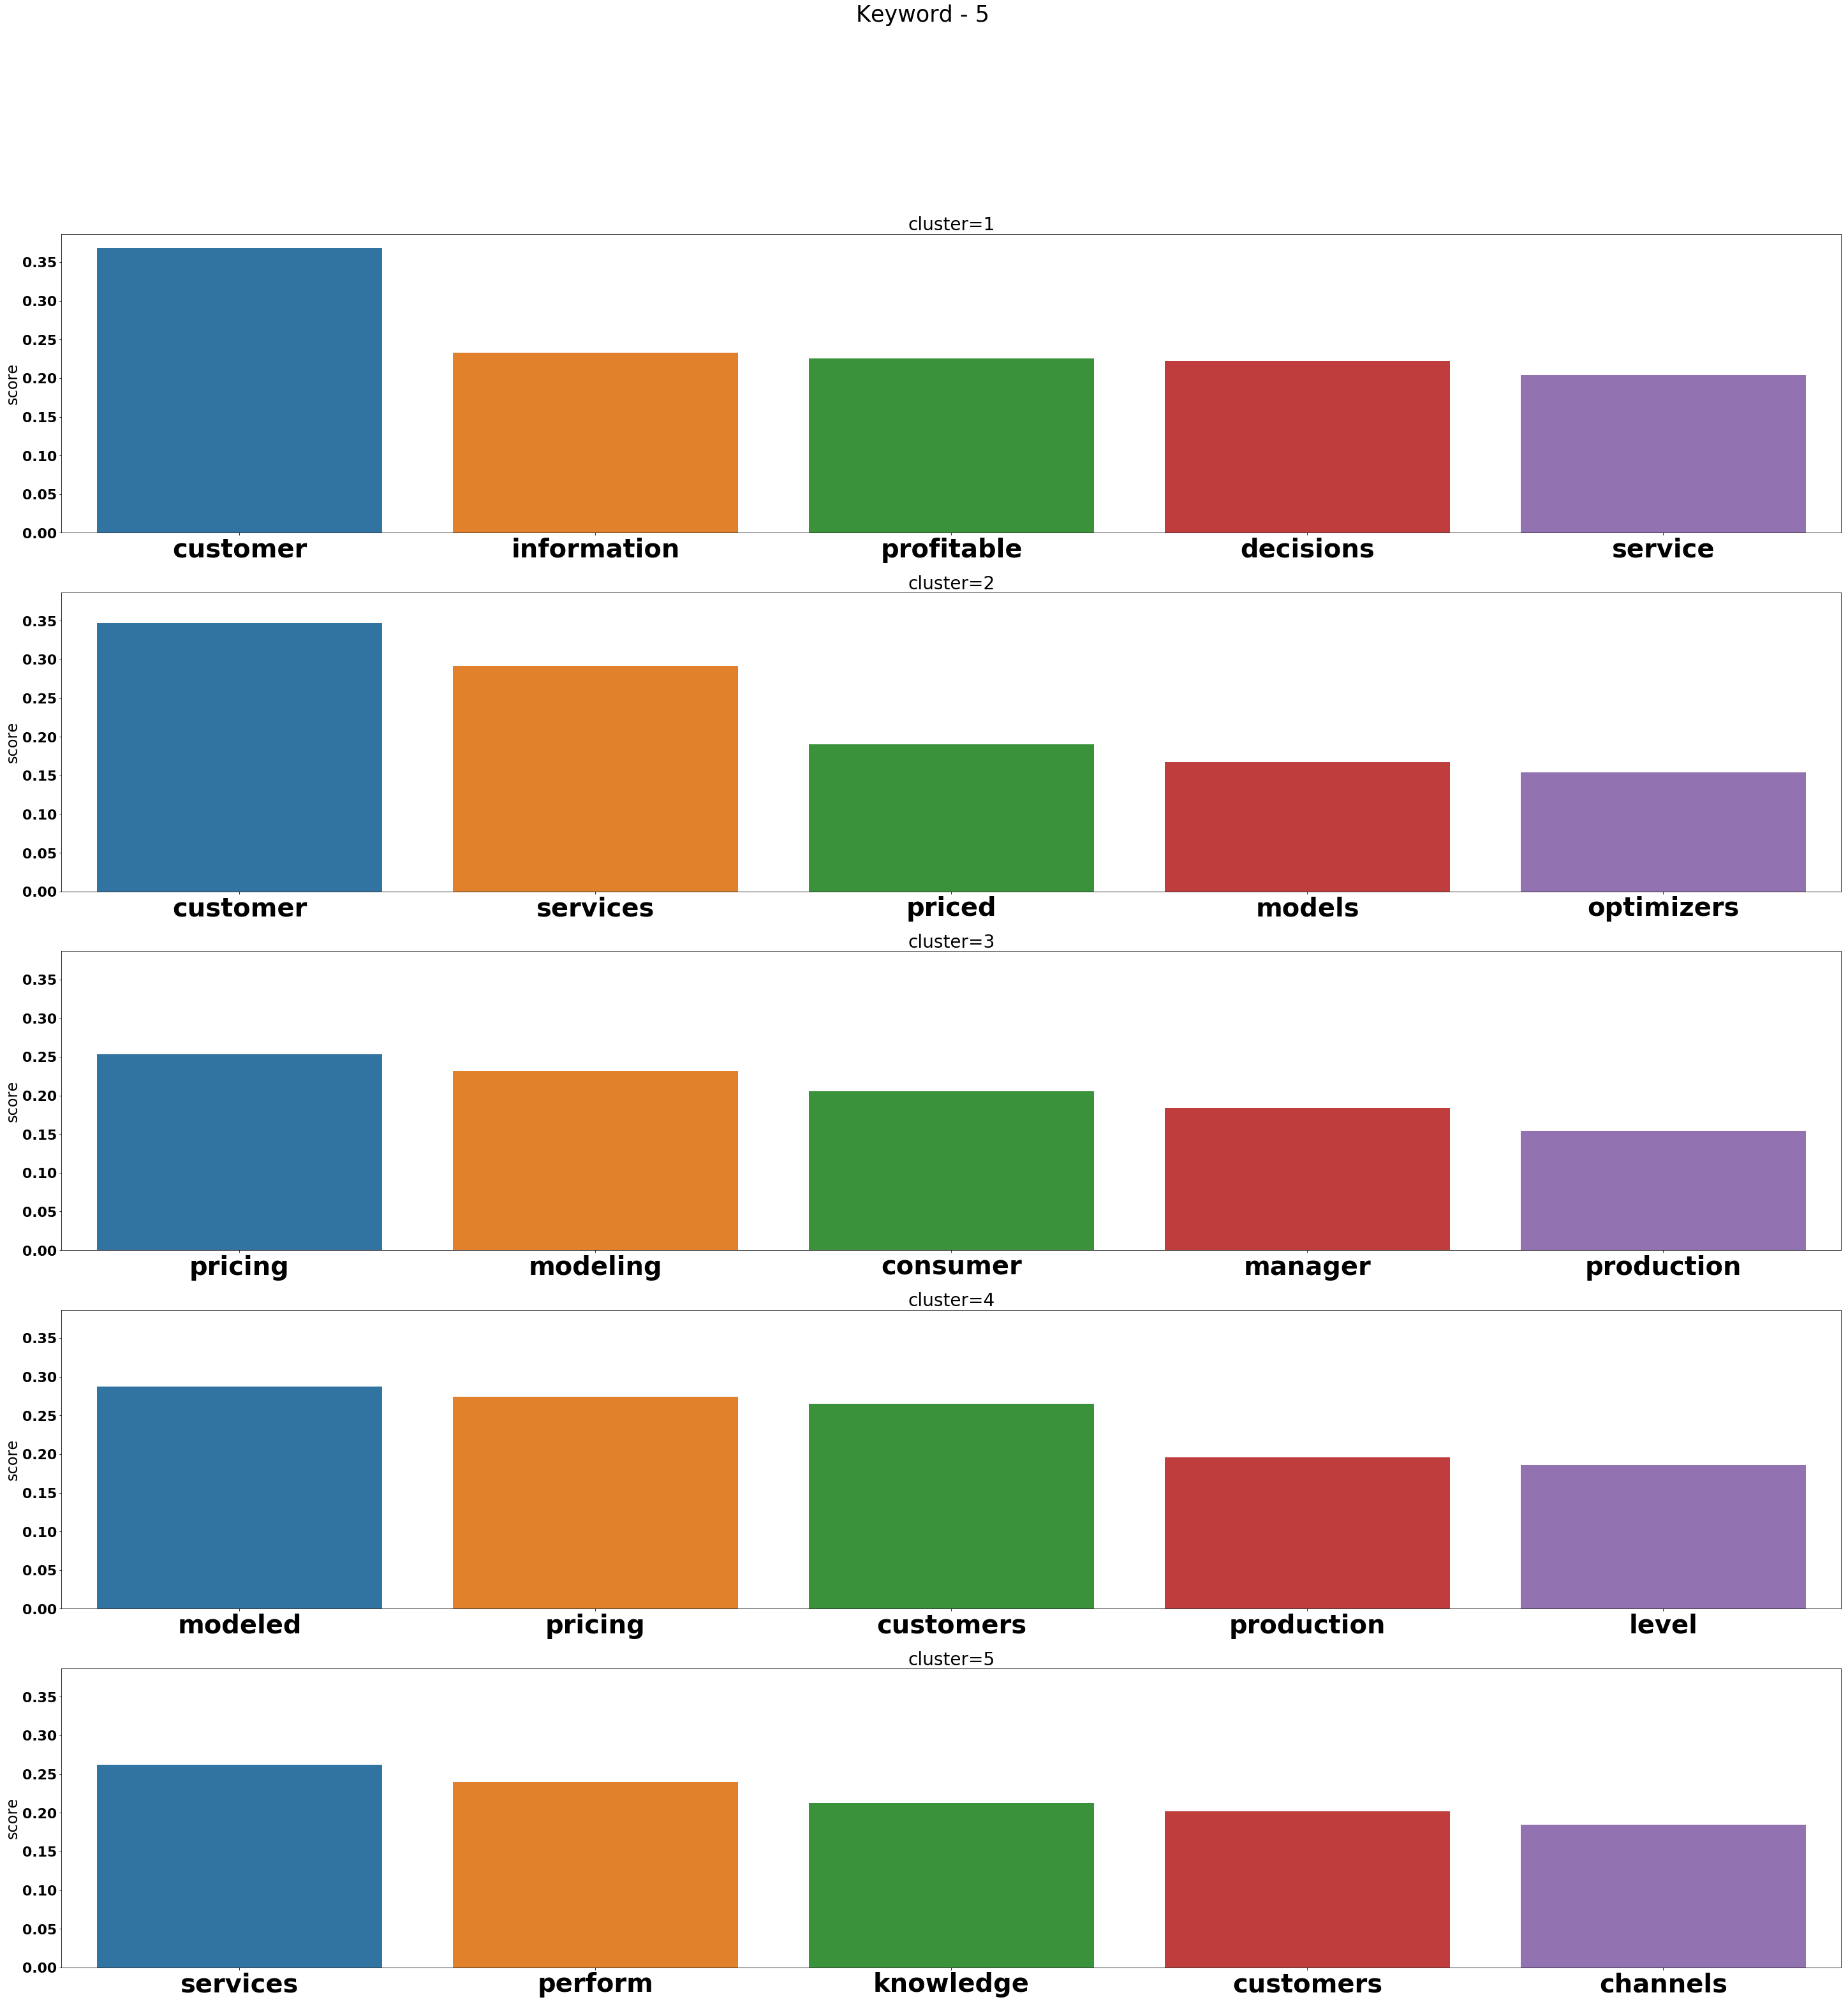

In [76]:
plot_cluster_keywords(keyword_df, 5, "Keyword - 5")

#### Whole Abstract

    cluster      keyword     score
0         1  operational  0.404320
1         1     managers  0.234322
2         1     research  0.197577
3         1    behaviors  0.194248
4         1        human  0.193959
5         2    knowledge  0.379732
6         2         team  0.362018
7         2     operated  0.254278
8         2      quality  0.164675
9         2  performance  0.146965
10        3       models  0.295585
11        3    decisions  0.226057
12        3       orders  0.194525
13        3    inventory  0.179396
14        3       levels  0.161477
15        4      modeled  0.224371
16        4        times  0.218601
17        4      patient  0.177420
18        4   experience  0.159301
19        4      perform  0.143775
20        5       priced  0.479609
21        5     consumer  0.263931
22        5     customer  0.260632
23        5        model  0.216809
24        5      product  0.192394
25        6       choice  0.272475
26        6     controls  0.258560
27        6     netw

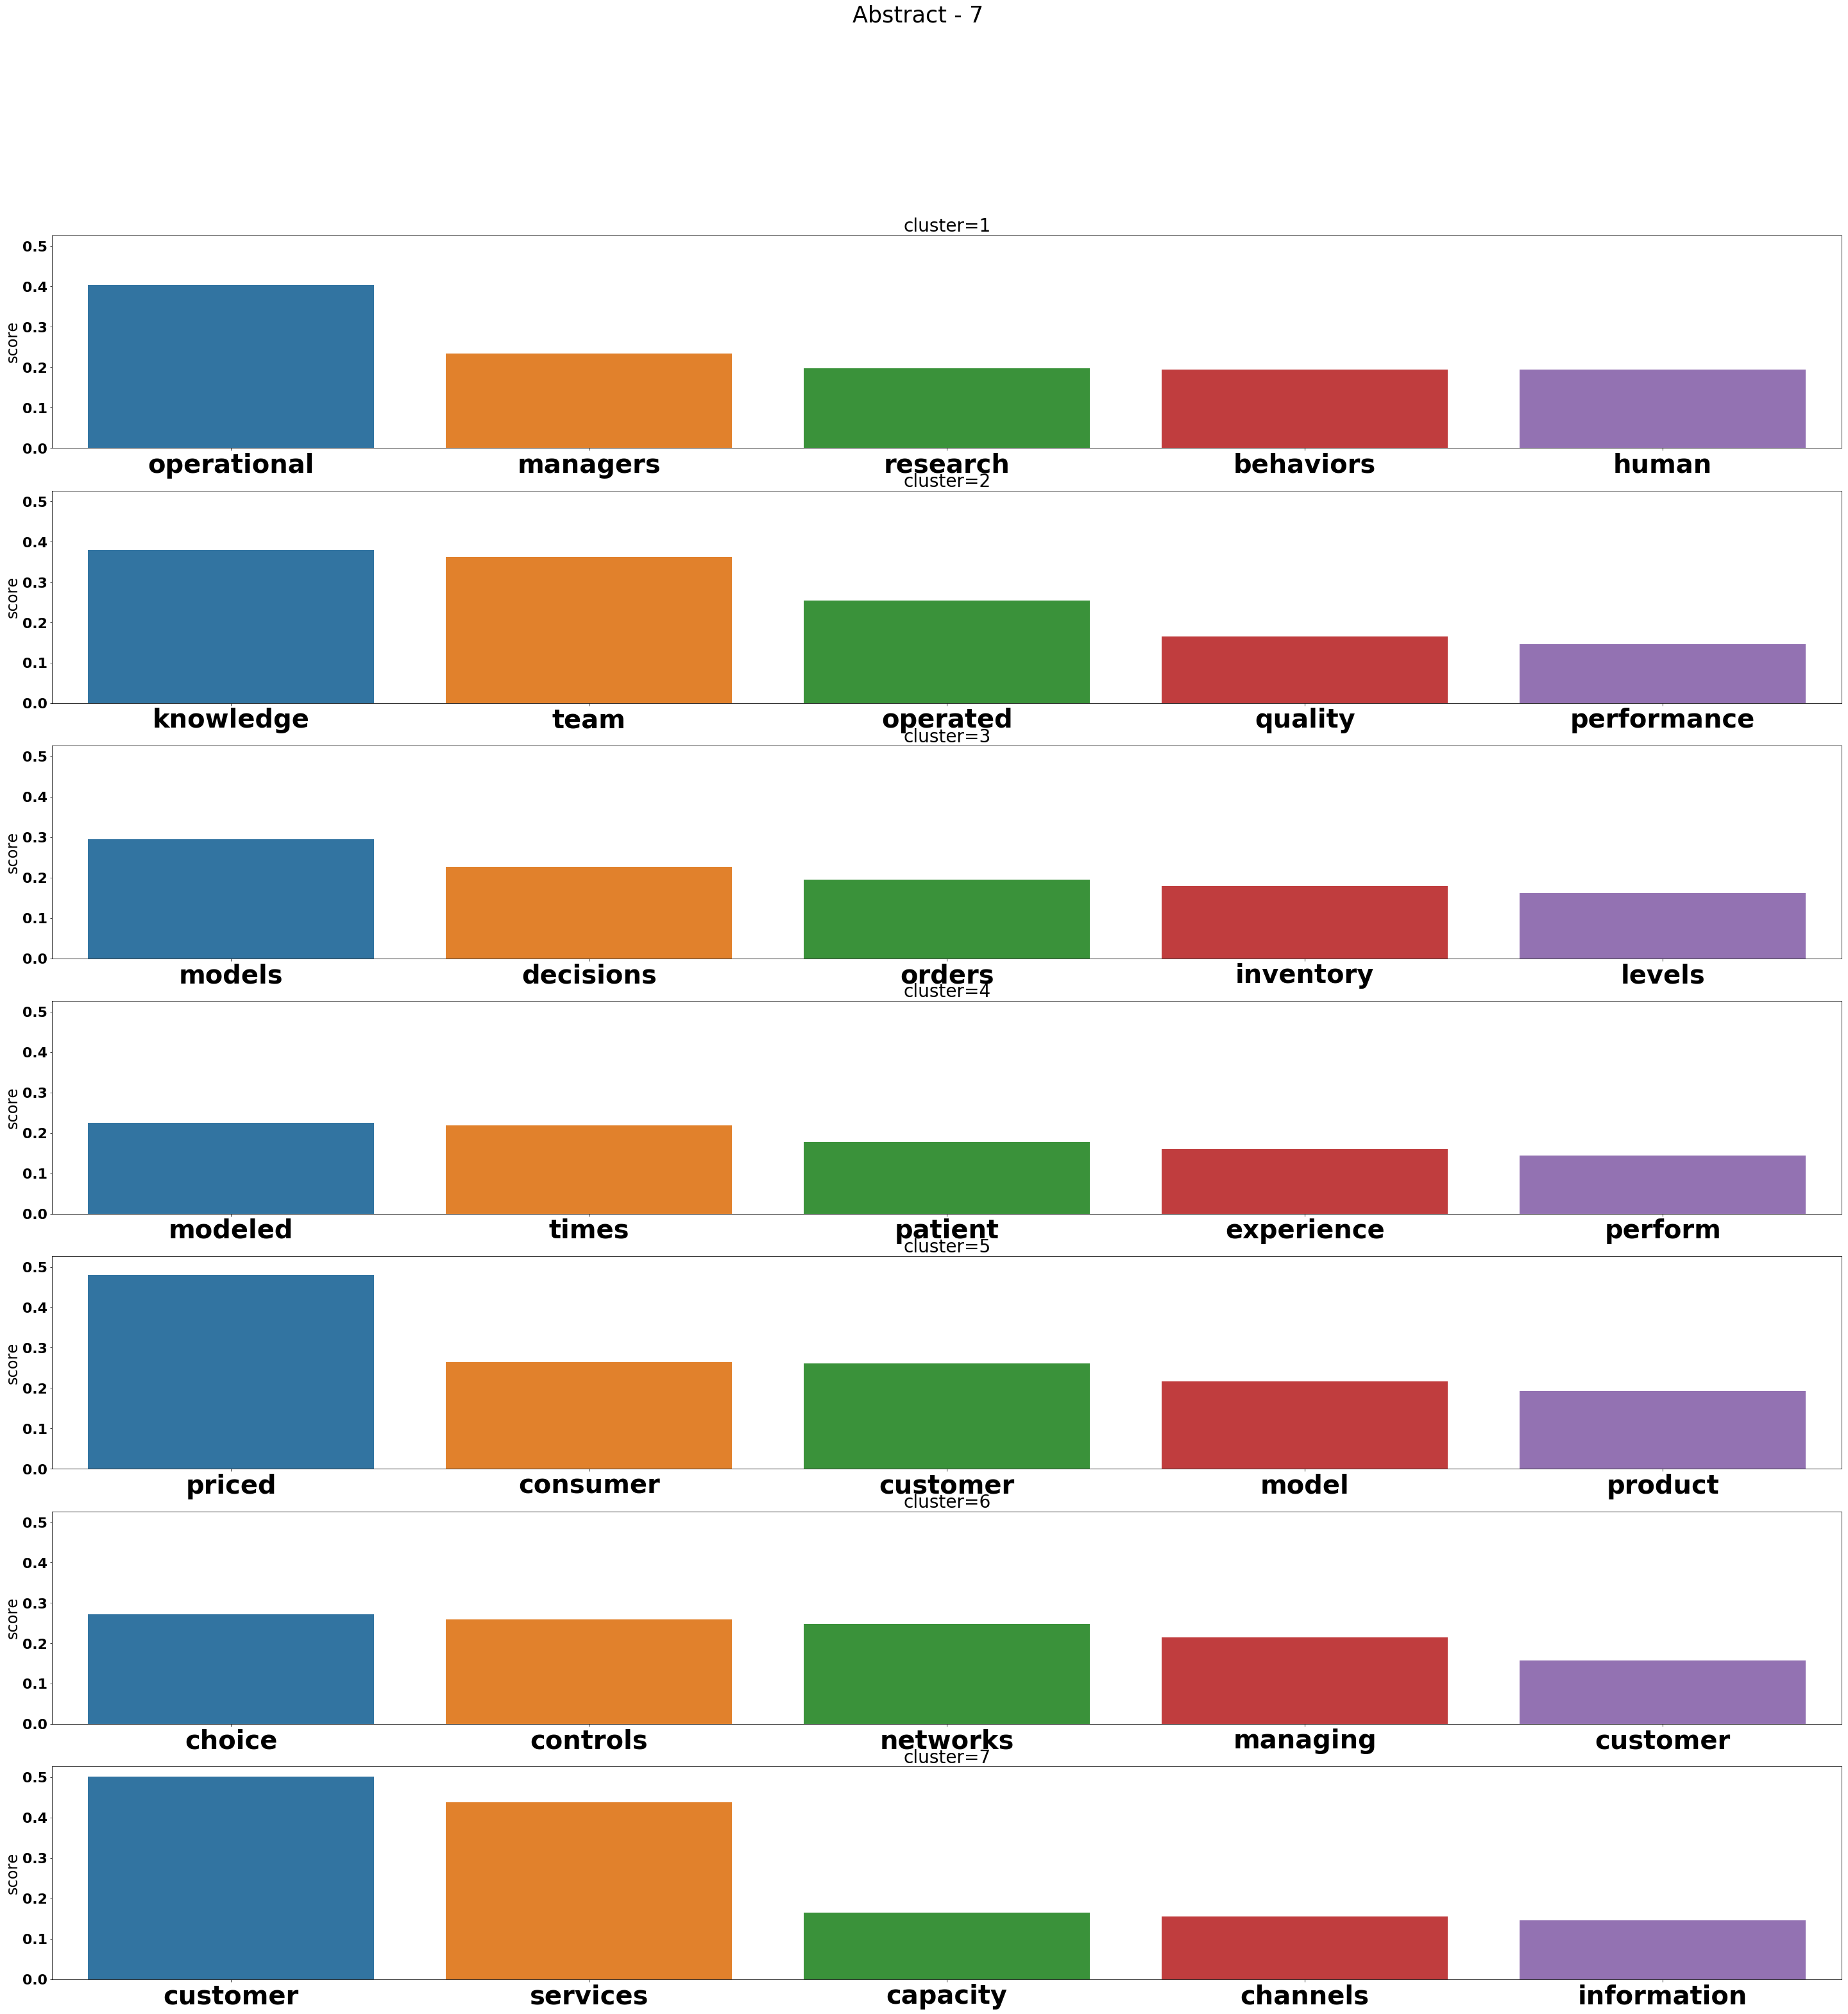

In [77]:
plot_cluster_keywords(abstract_df, 7, "Abstract - 7")

### Categorical Evaluation

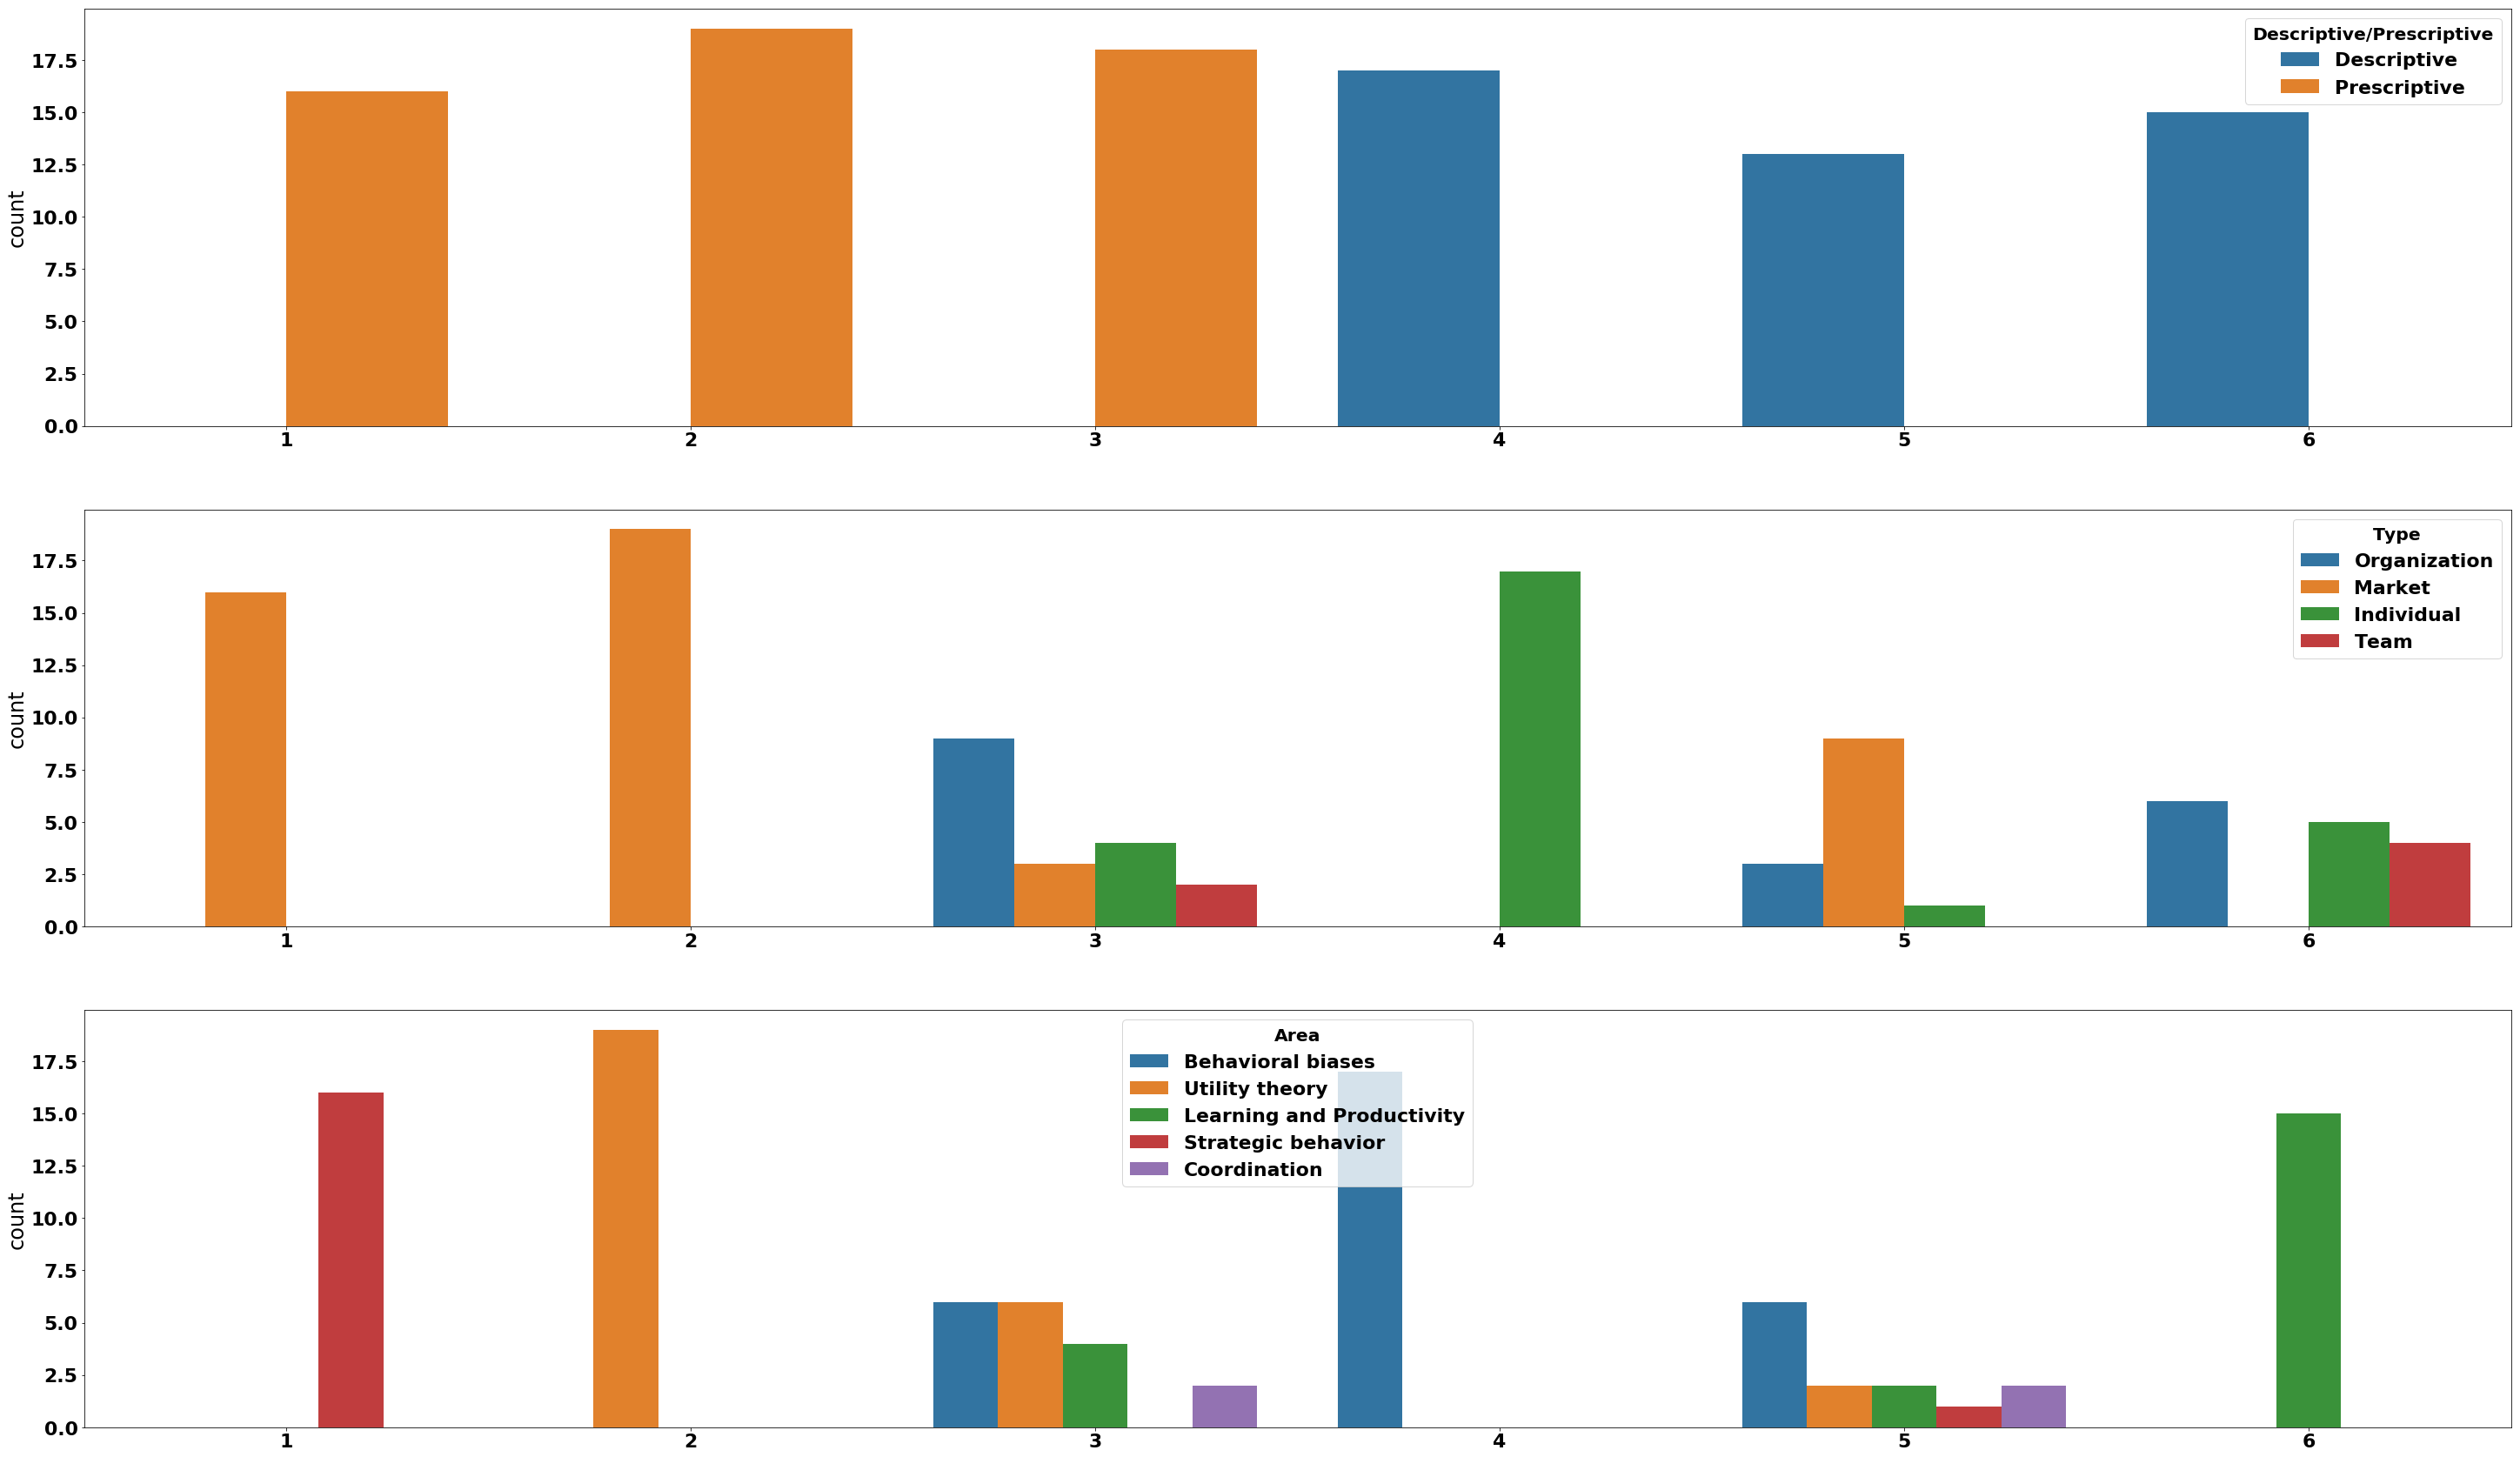

In [57]:
label_clusters = cluster(label_df, 6)

fig, axes = plt.subplots(nrows=3)
sns.countplot(x=label_clusters, data=df, hue='Descriptive/Prescriptive', ax=axes[0])
sns.countplot(x=label_clusters, data=df, hue='Type', ax=axes[1])
sns.countplot(x=label_clusters, data=df, hue='Area', ax=axes[2])
plt.savefig('plots/categorical_comparaison/labeled_clusters')

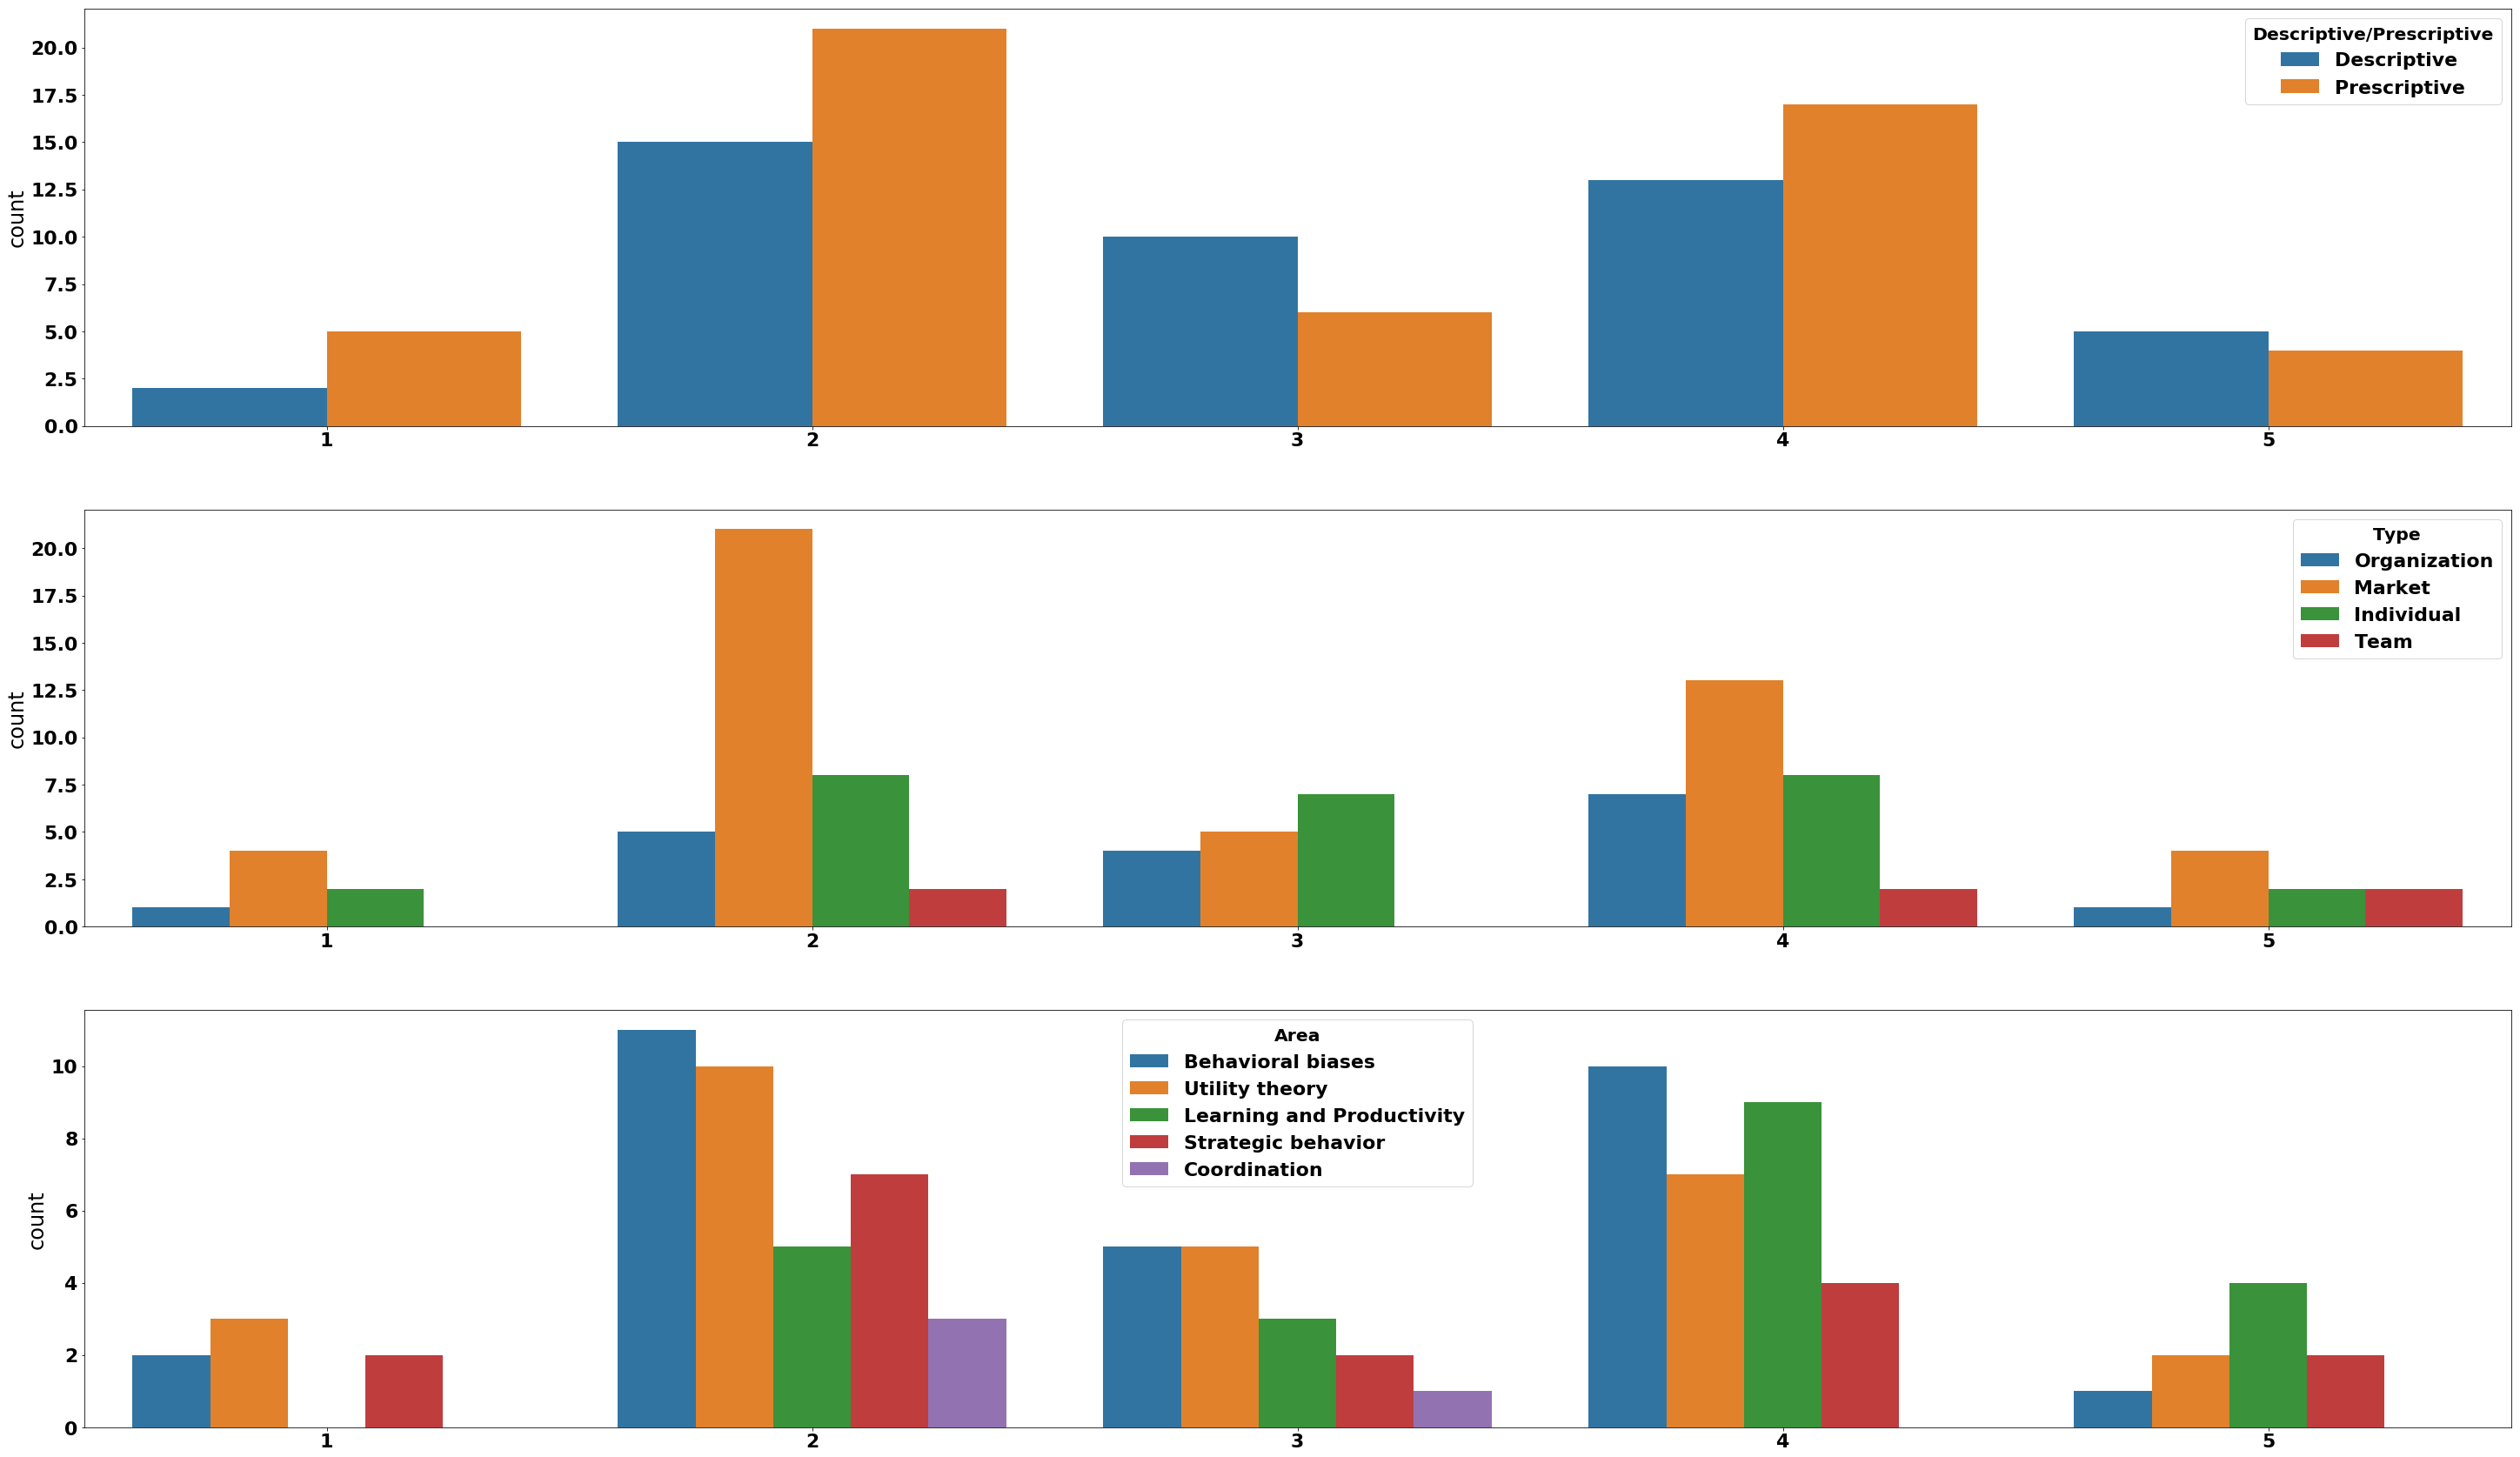

In [58]:
keyword_clusters = cluster(keyword_df, 5)

fig, axes = plt.subplots(nrows=3)
sns.countplot(x=keyword_clusters, data=df, hue='Descriptive/Prescriptive', ax=axes[0])
sns.countplot(x=keyword_clusters, data=df, hue='Type', ax=axes[1])
sns.countplot(x=keyword_clusters, data=df, hue='Area', ax=axes[2])
plt.savefig('plots/categorical_comparaison/keyword_clusters')

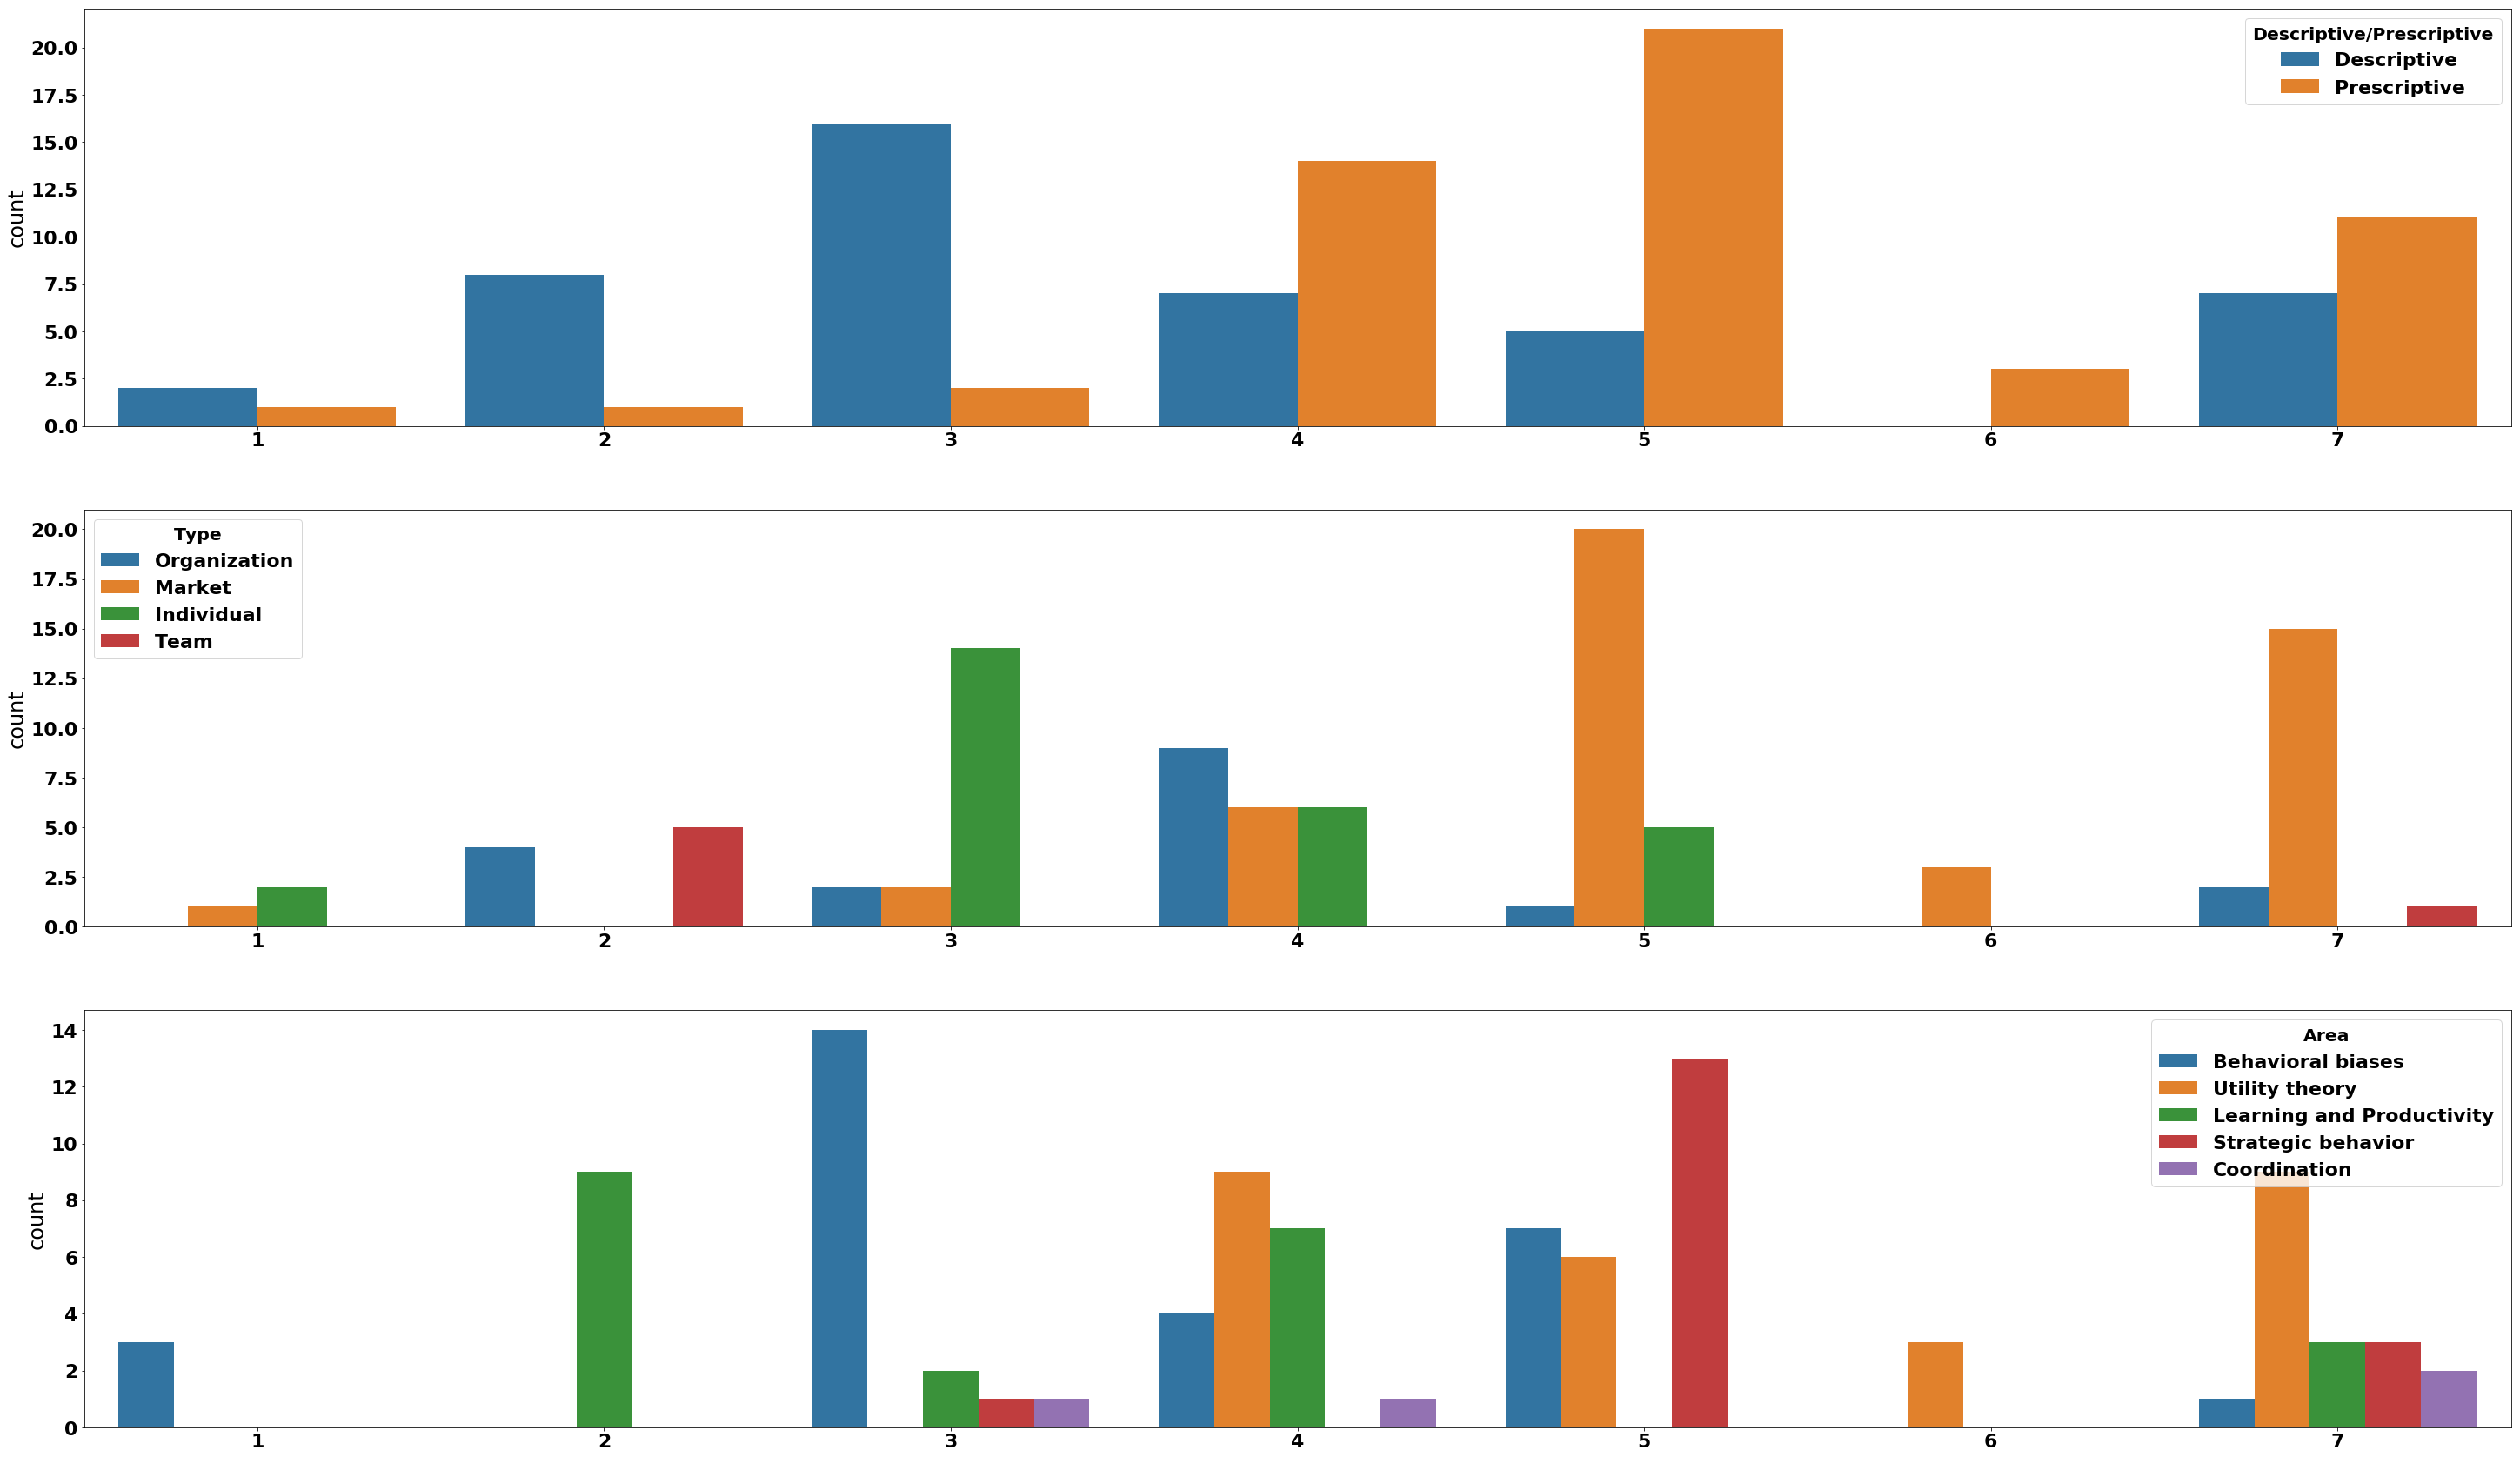

In [59]:
abstract_clusters = cluster(abstract_df, 7)

fig, axes = plt.subplots(nrows=3)
sns.countplot(x=abstract_clusters, data=df, hue='Descriptive/Prescriptive', ax=axes[0])
sns.countplot(x=abstract_clusters, data=df, hue='Type', ax=axes[1])
sns.countplot(x=abstract_clusters, data=df, hue='Area', ax=axes[2])
plt.savefig('plots/categorical_comparaison/abstract_clusters')

### Dendogram Evaluation

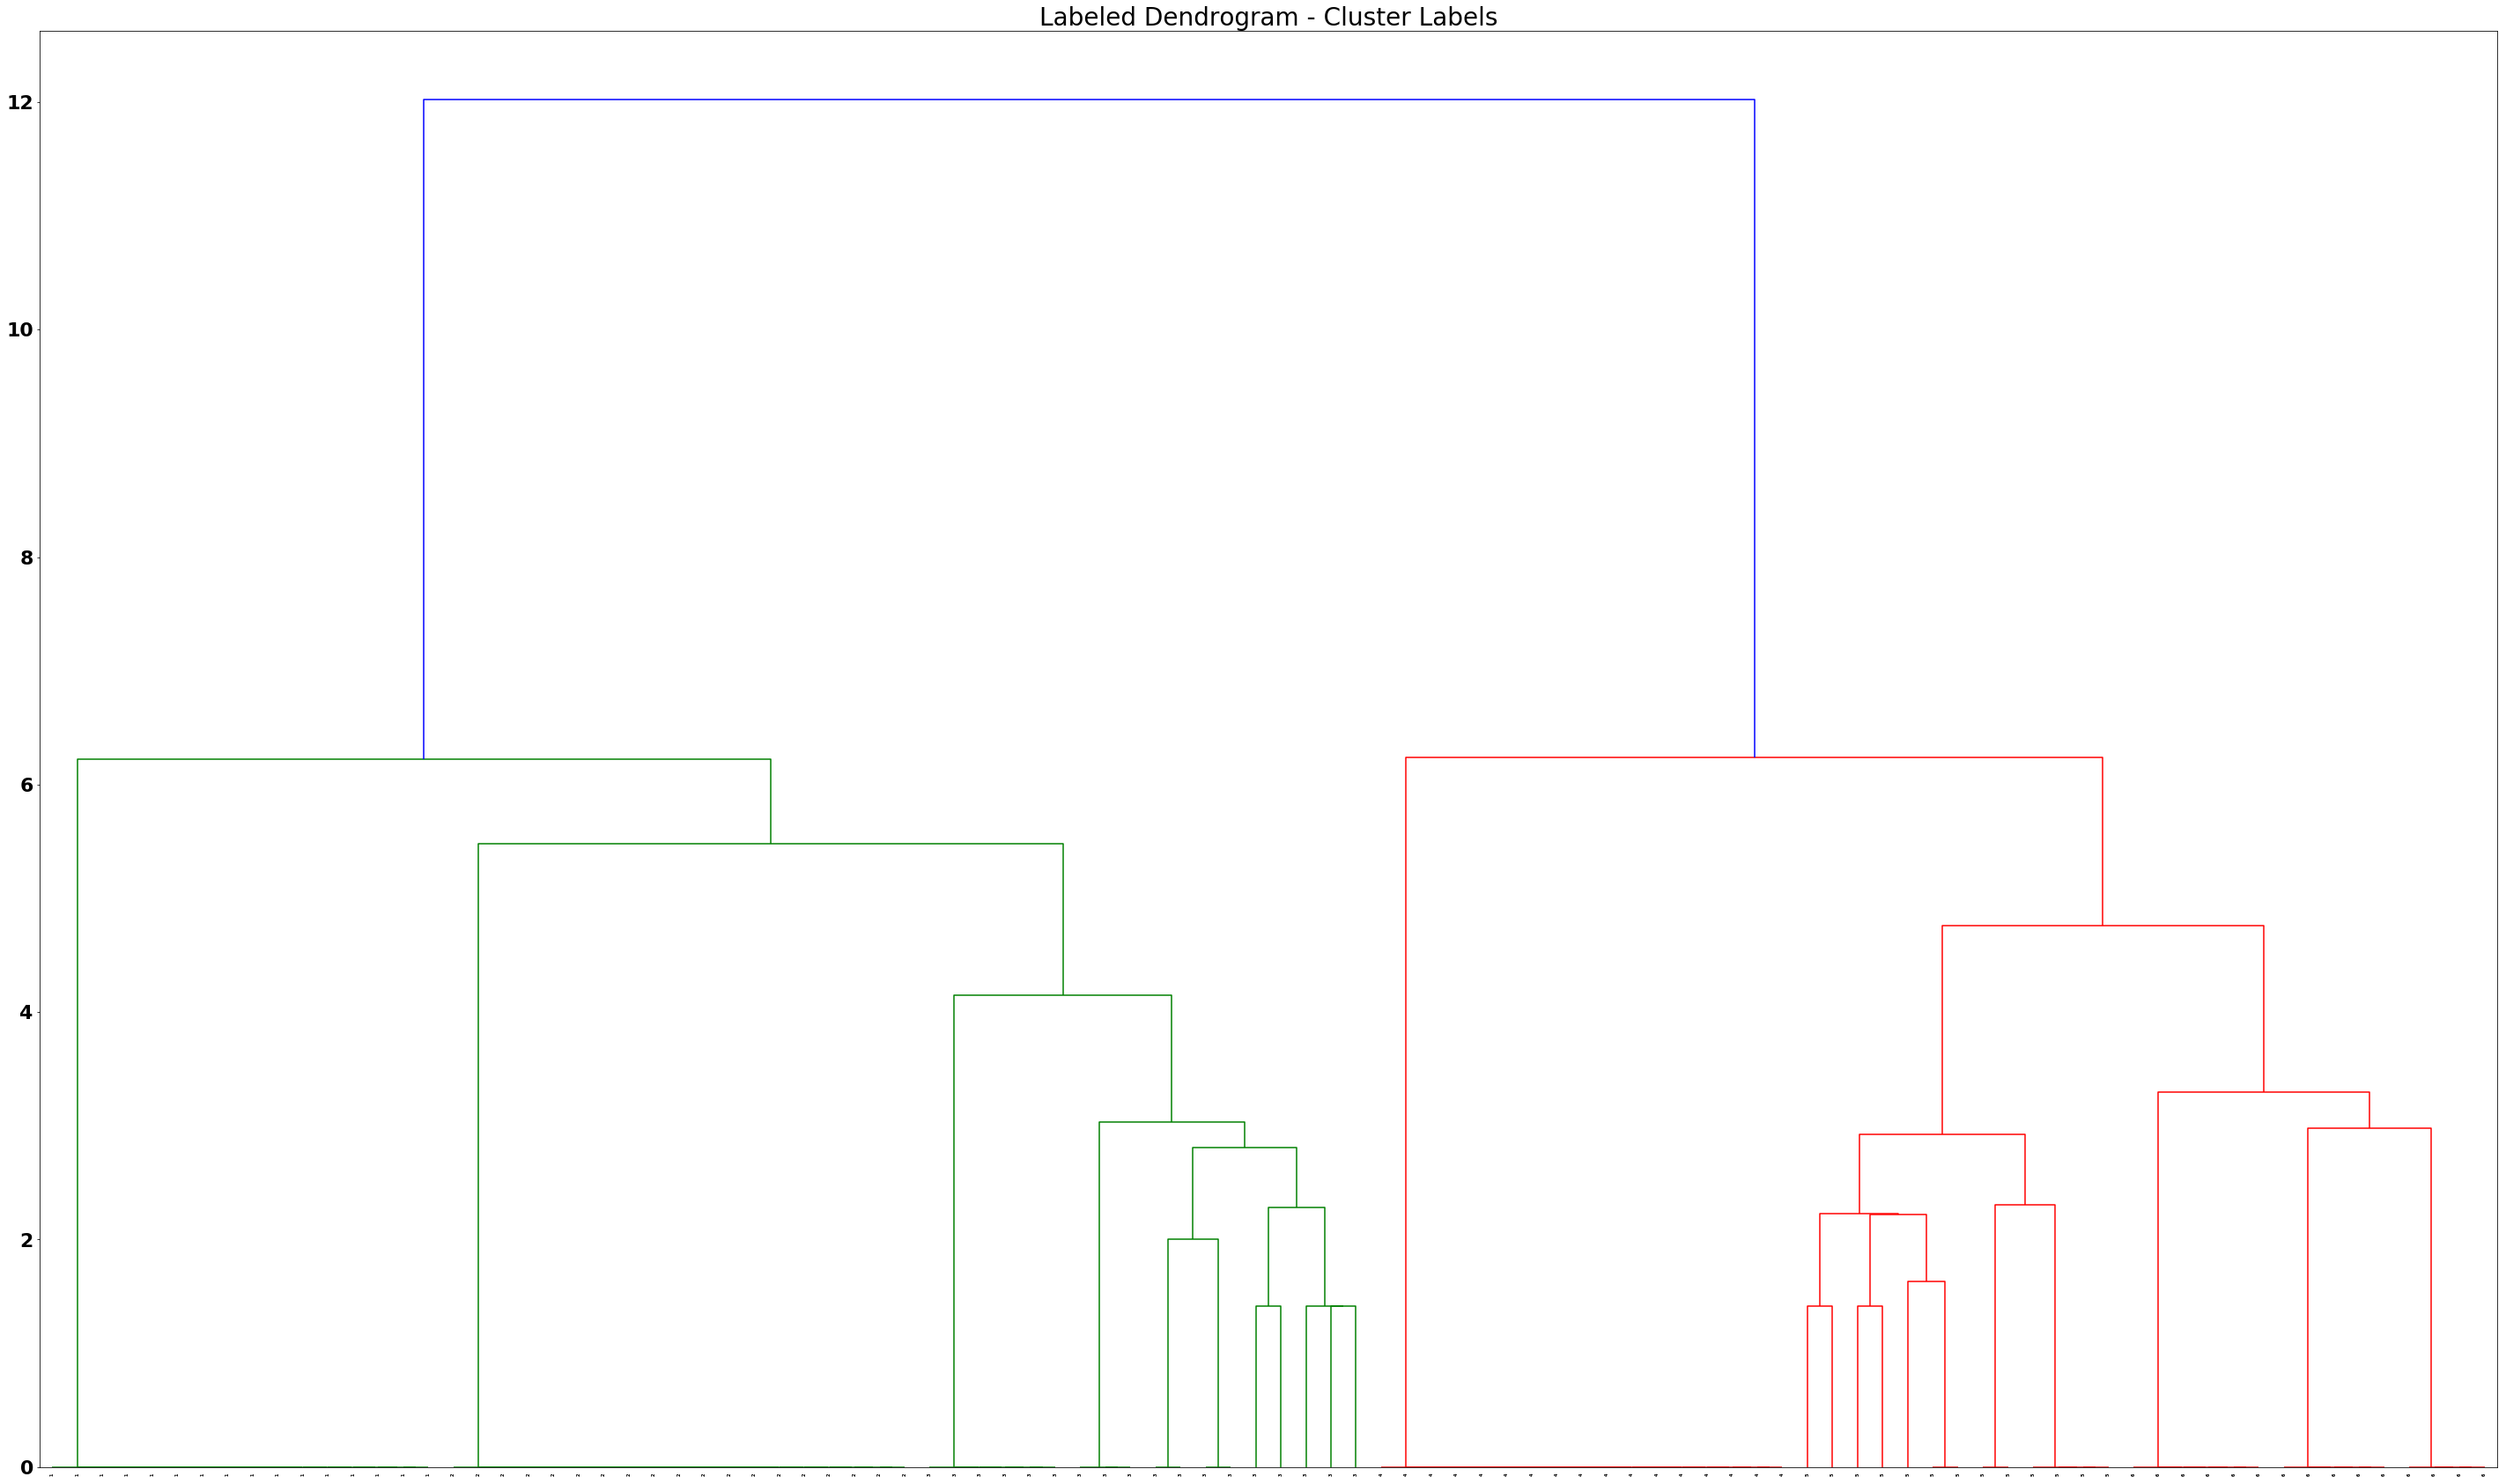

In [78]:
plt.title("Labeled Dendrogram - Cluster Labels")
dend = shc.dendrogram(shc.linkage(label_df, method='ward'), labels=label_clusters)
plt.savefig('plots/dendrograms/labeled_dendrogram_cluster_labels.pdf', format='pdf')

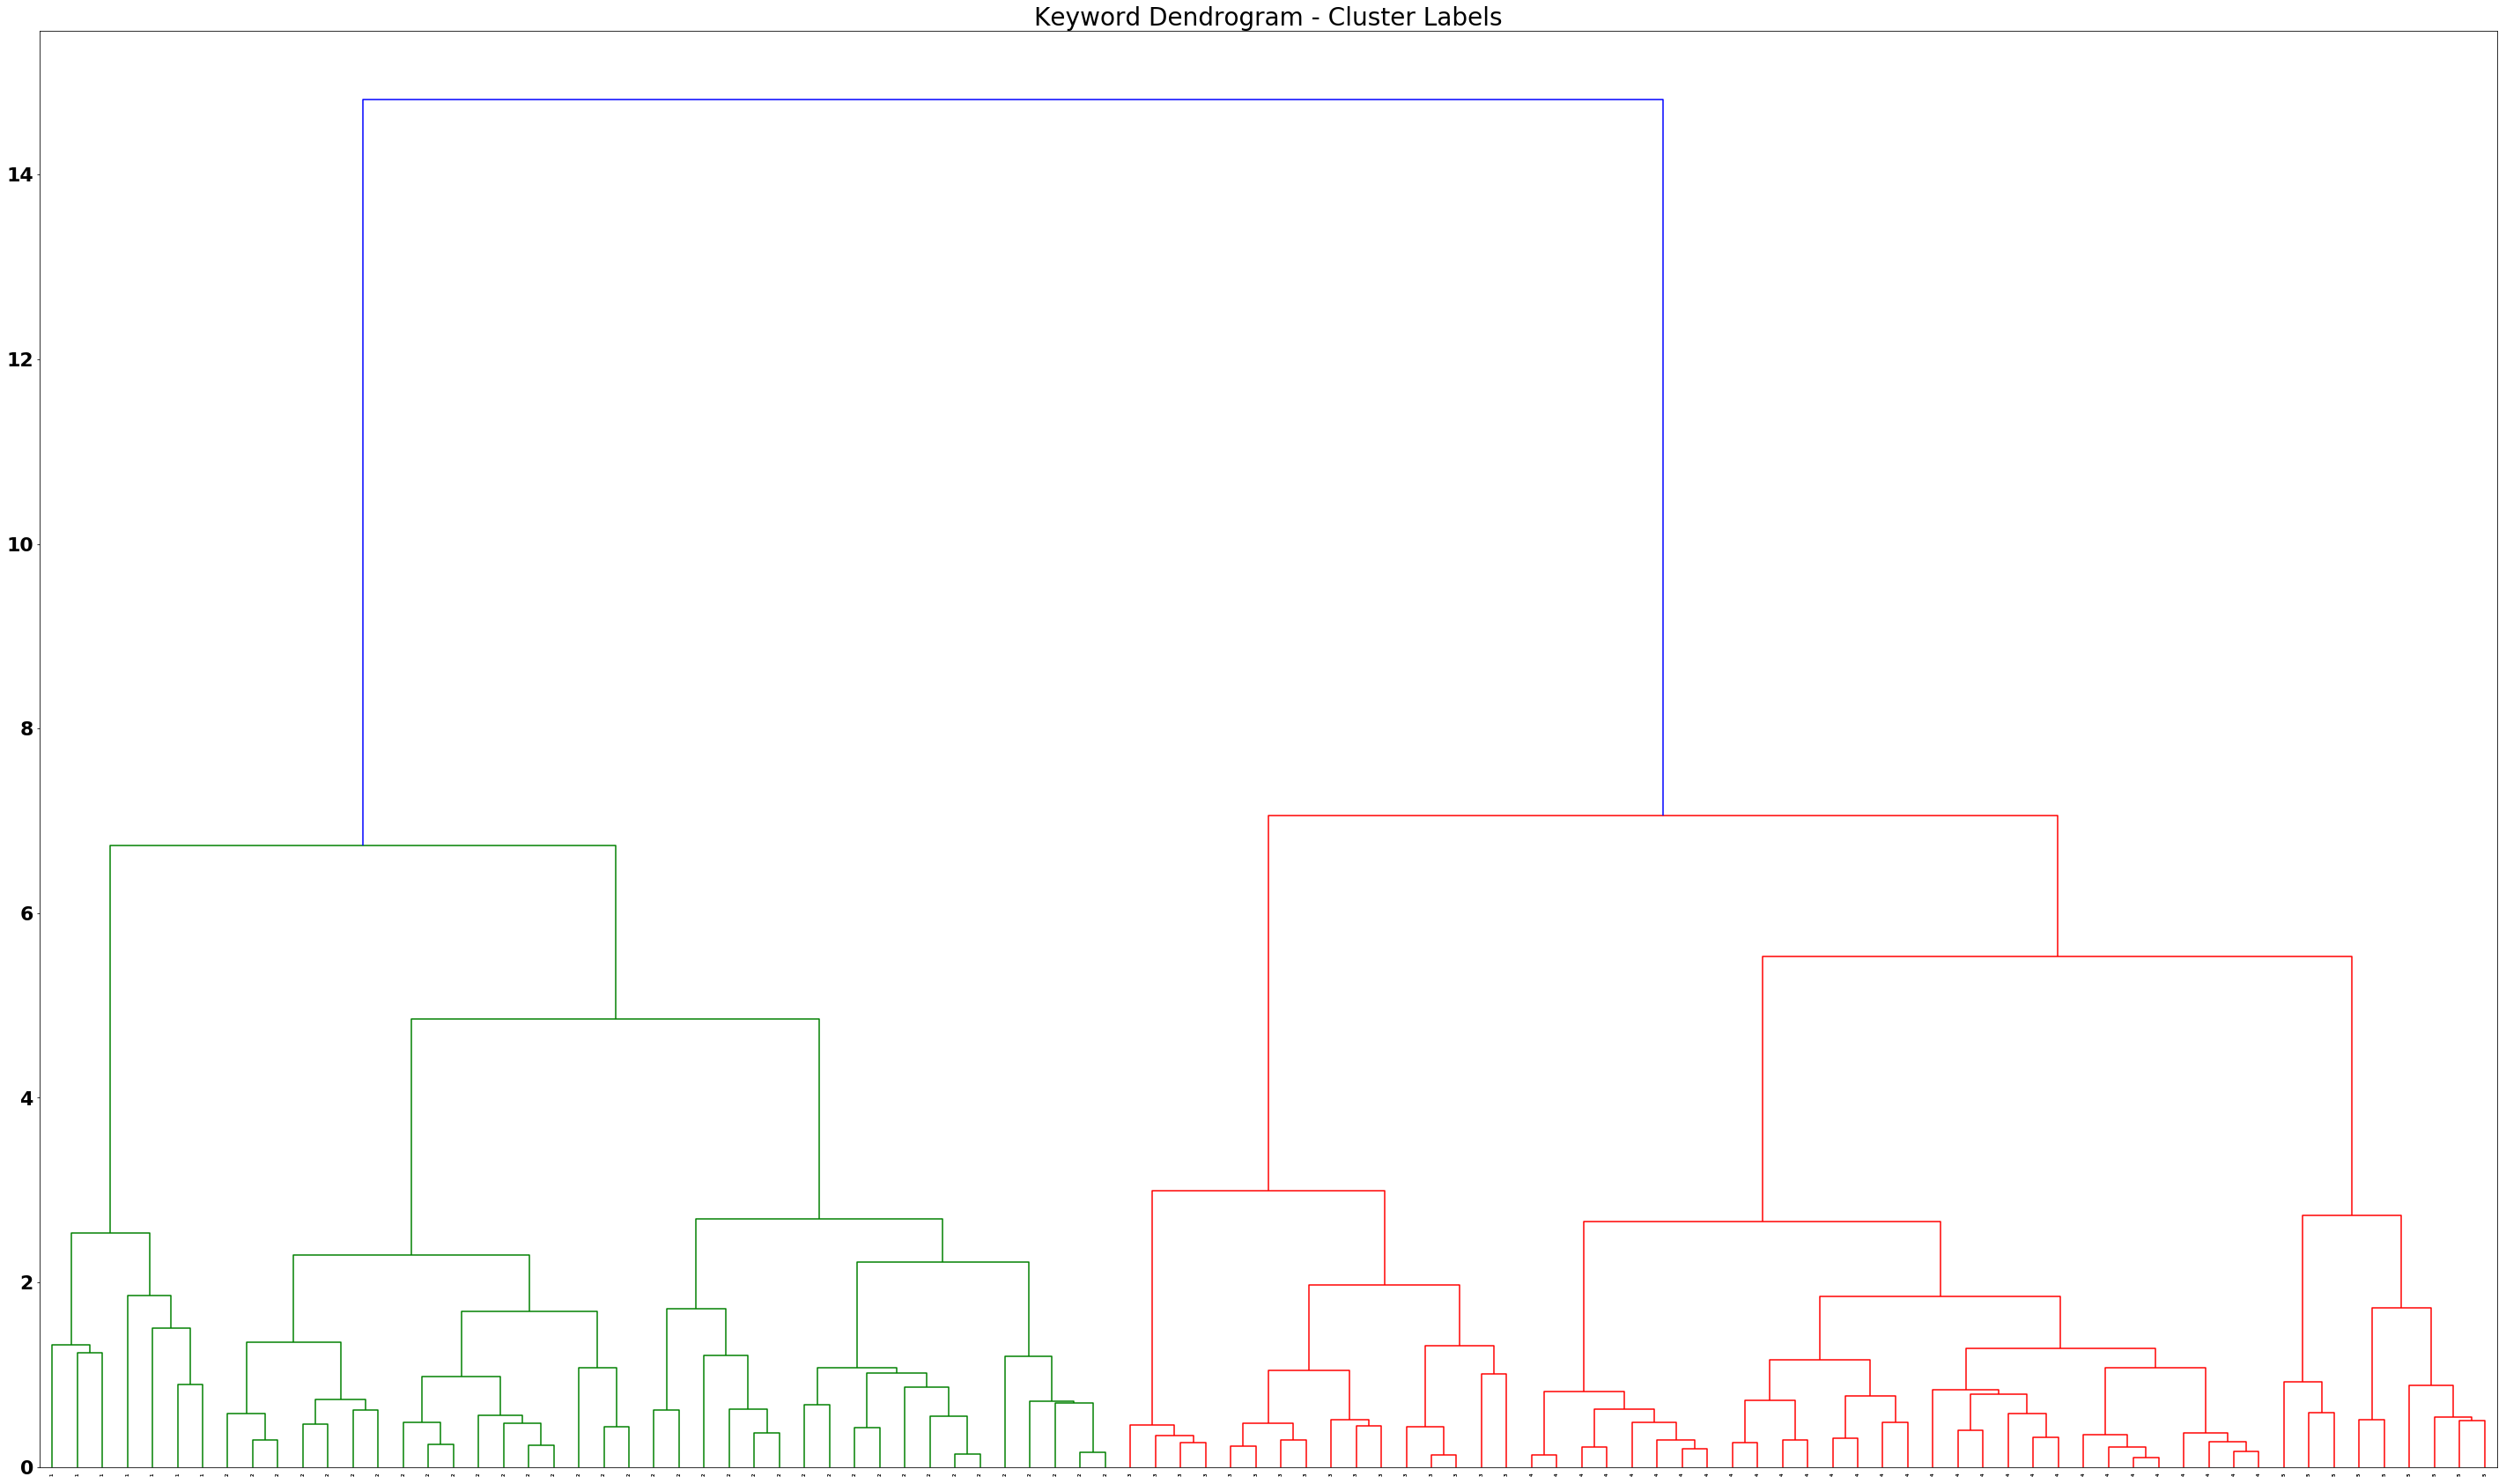

In [79]:
plt.title("Keyword Dendrogram - Cluster Labels")
dend = shc.dendrogram(shc.linkage(keyword_df, method='ward'), labels=keyword_clusters)
plt.savefig('plots/dendrograms/keyword_dendrogram_cluster_labels.pdf', format='pdf')

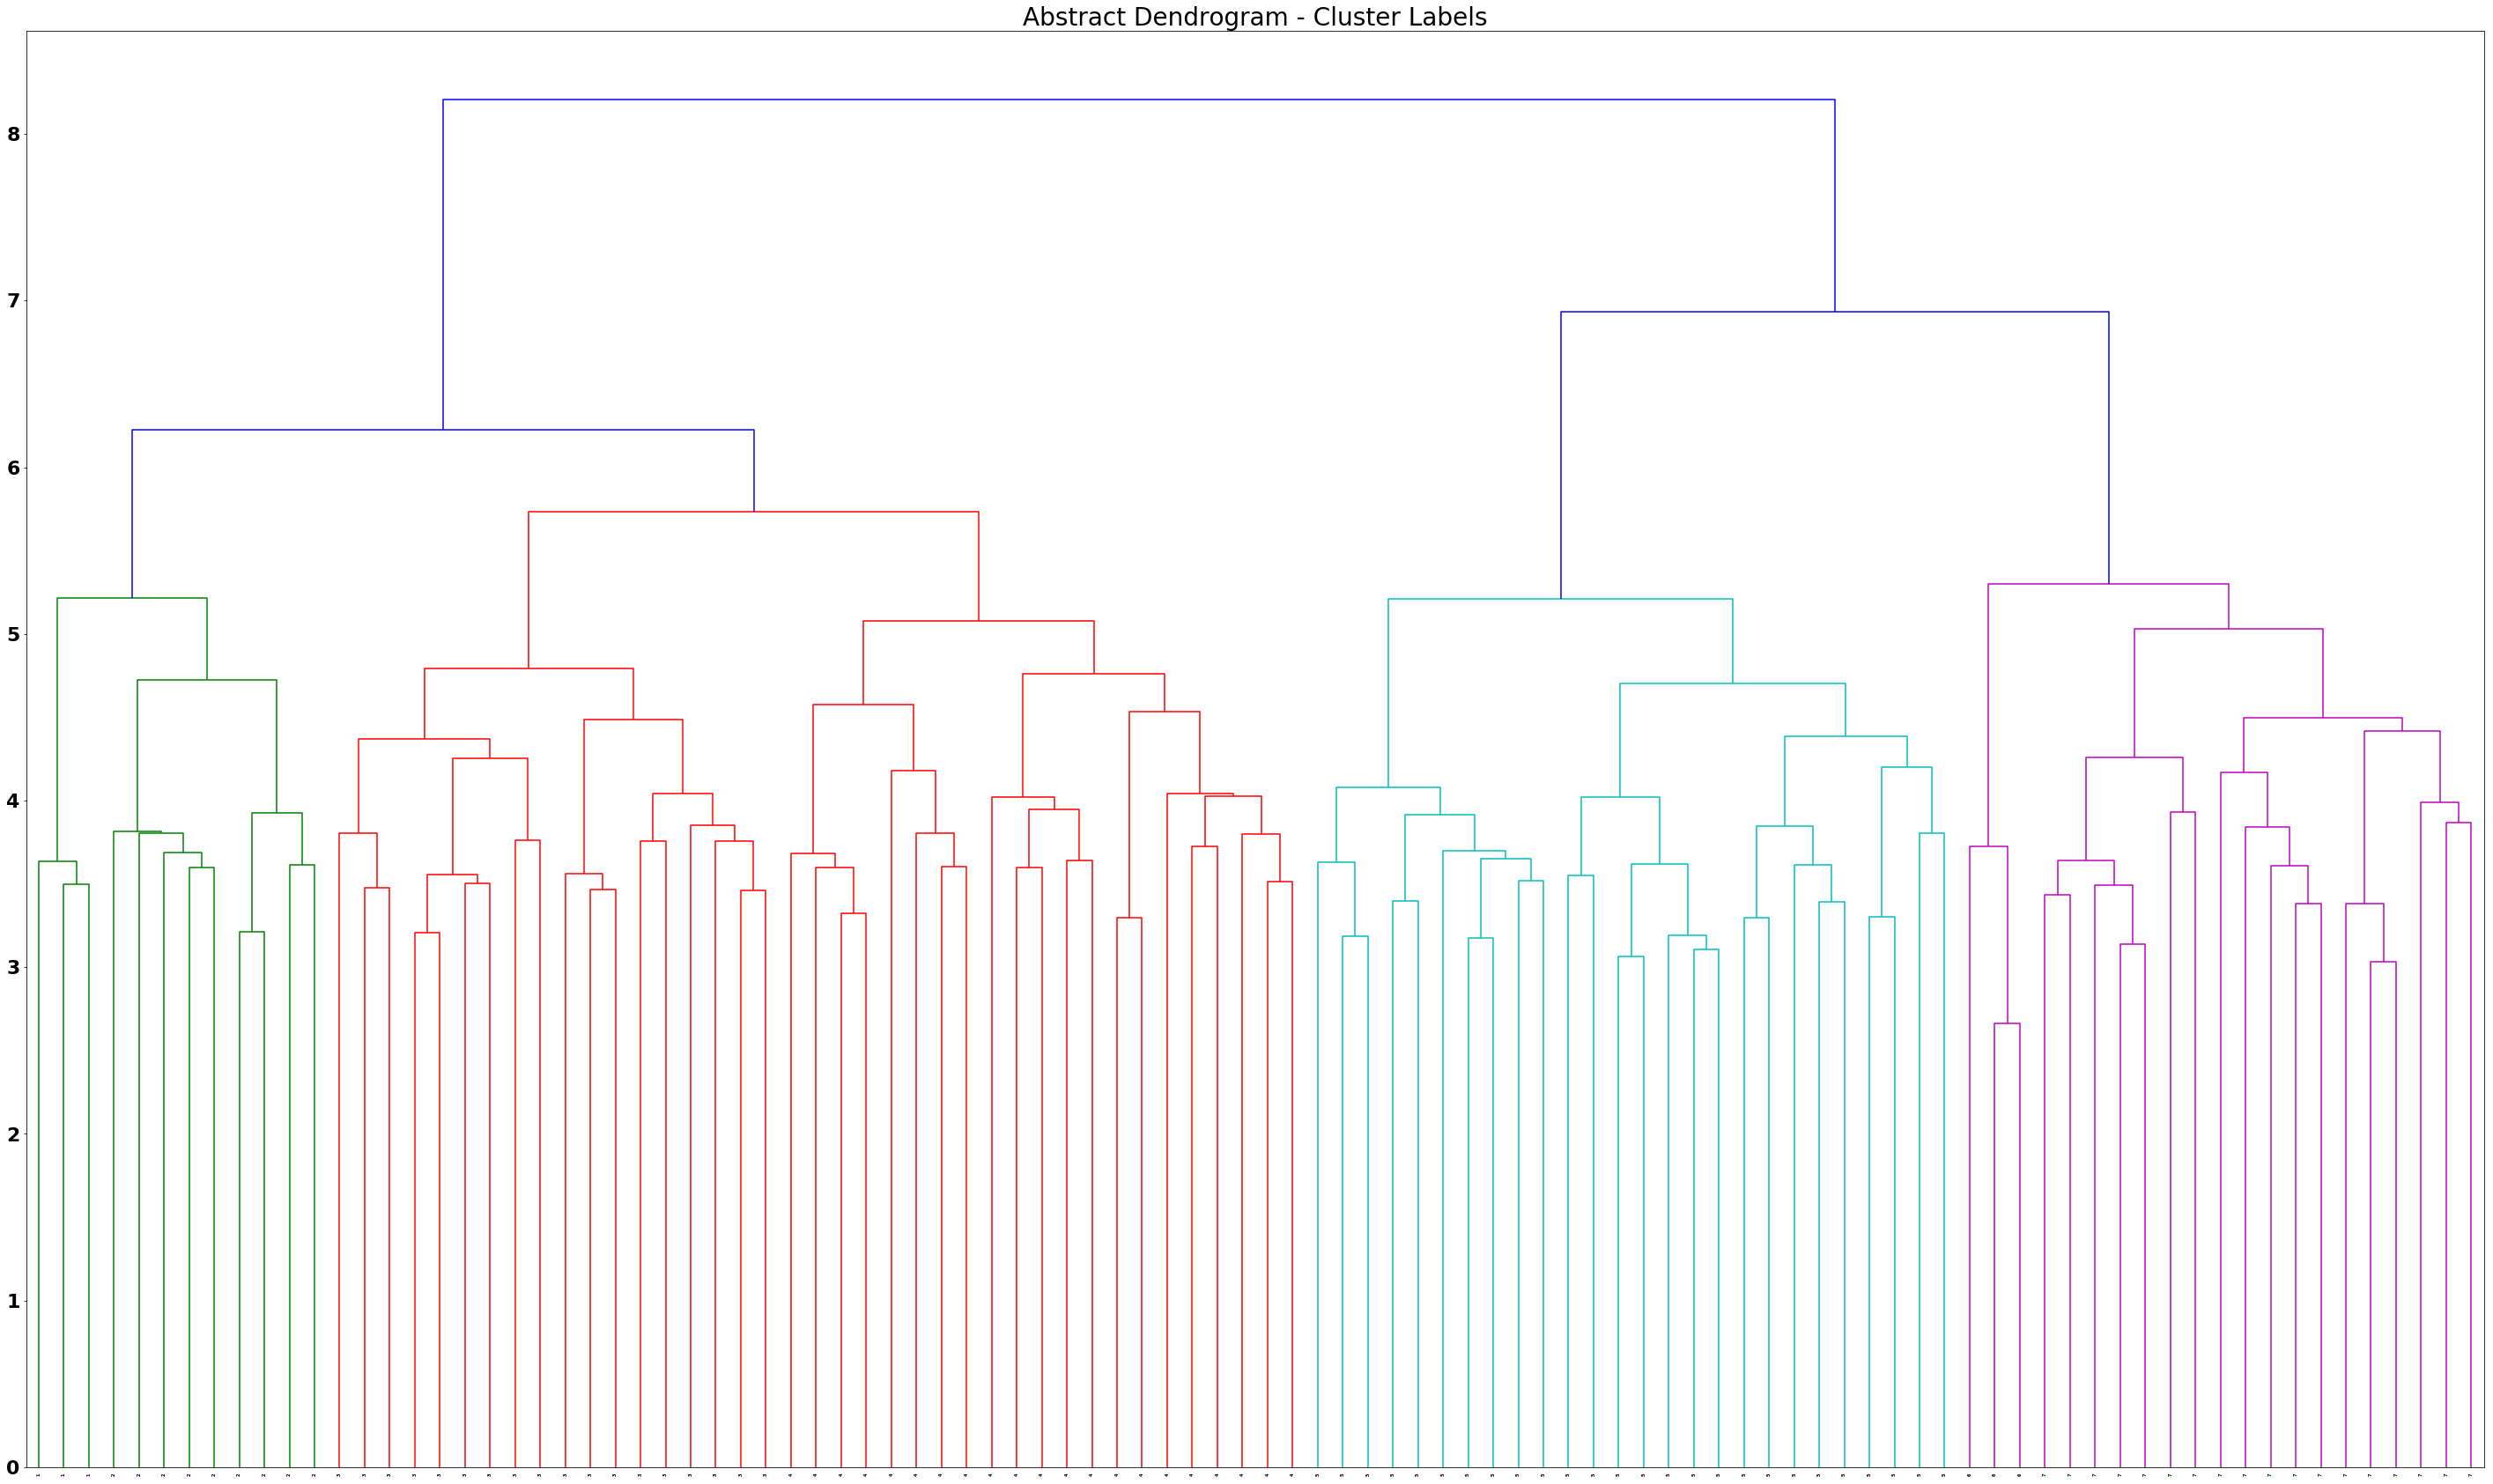

In [80]:
plt.title("Abstract Dendrogram - Cluster Labels")
dend = shc.dendrogram(shc.linkage(abstract_df, method='ward'), labels=abstract_clusters)
plt.savefig('plots/dendrograms/abstract_dendrogram_cluster_labels.pdf', format='pdf')

## Save Clusters

In [83]:
df['labeled_clusters'] = label_clusters
df['keyword_clusters'] = keyword_clusters
df['abstract_clusters'] = abstract_clusters

In [86]:
df.to_csv('data/clusters.csv')